In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.jla_supernovae.jla as jla
import simulators.jla_supernovae.jla_parser as jla_parser
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# Import data
jla_data, jla_cmats = jla_parser.b14_parse(z_min=None, z_max=None, qual_cut=False,
                                    jla_path='simulators/jla_supernovae/jla_data/')
data = jla_data['mb']
delta_m_cut = 10
auxiliary_data = np.column_stack([jla_data['zcmb'], jla_data['x1'], jla_data['color'], np.array([(jla_data['3rdvar'] > delta_m_cut)], dtype=int)[0]])

# Om, w0, M_b, alpha, beta, delta_m
npar = 6
theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])

# Define prior limits and boundaries
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
Q = np.diag([0.4, 0.75, 0.1, 0.025, 0.25, 0.05])**2
Q[0,1] = Q[1,0] = -0.8*0.4*0.75
Qinv = np.linalg.inv(Q)
prior_mean = np.array([  0.3  ,  -0.75 , -19.05 ,   0.125,   2.6  ,  -0.05 ])
prior_args = [prior_mean, Q, lower, upper]

# Covariance matrix
C = jla_parser.b14_covariance(jla_data, jla_cmats, theta_fiducial[3], theta_fiducial[4])
Cinv = np.linalg.inv(C)
L = np.linalg.cholesky(C)

# Derivative of the covariance matrix
n_sn = len(C)
dCdt = np.zeros((npar, n_sn, n_sn))

# Step size for derivatives
step = abs(0.01*theta_fiducial)

# N data points
ndata = len(jla_data['mb'])

# Simulation args
sim_args = [auxiliary_data, L]

# Compute the mean
mu = jla.apparent_magnitude(theta_fiducial, auxiliary_data)

# Compute the derivatives
dmdt = jla.dmudtheta(theta_fiducial, jla.simulation_seeded, step, npar, ndata, sim_args)
dmdt[2,:] = np.ones(n_sn)
dmdt[3,:] = -jla_data['x1']
dmdt[4,:] = jla_data['color']
dmdt[5,:] = (jla_data['3rdvar'] > 10)

# Fisher matrix
F, Finv = jla.fisher(dmdt, dCdt, Cinv, Qinv, npar)
fisher_errors = np.sqrt(np.diag(Finv))

# Compute projection vectors
Fpinv = np.linalg.inv(F[2:,2:])
P1 = np.dot(Fpinv, F[0,2:])
P2 = np.dot(Fpinv, F[1,2:])

# Simulation args for ABC
compressor_args = [theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, F, P1, P2]

# Parameter names for plotting
names = ['\Omega_m', 'w_0']
labels =  ['\\Omega_m', 'w_0']
ranges = {'\Omega_m':[lower[0], upper[0]], '\w0':[lower[1], upper[1]]}

# Compressed dataset
data = jla.compressor_projected(data, compressor_args)

# Define new separate priors over eta and theta
theta_fiducial = np.array([0.20181324,  -0.74762939])
Finv = Finv[0:2,0:2]
lower = np.array([0, -1.5])
upper = np.array([0.6, 0])
Q = np.diag([0.4, 0.75])**2
Q[0,1] = Q[1,0] = -0.8*0.4*0.75
Qinv = np.linalg.inv(Q)
prior_mean = np.array([  0.3  ,  -0.75])
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

eta_prior = priors.TruncatedGaussian(np.array([-19.05, 0.125, 2.6, -0.05]), 
                                     np.diag([0.1, 0.025, 0.25, 0.05])**2, 
                                     np.array([-20, 0, 0, -0.5]),
                                     np.array([-18, 1, 6, 0.5]))


/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_MASTER/delfi/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [3]:
# Define the simulator function: takes parameters, spits out simulated data
# Should have the form: simulator(parameters, args) -> simulated dataset
def simulator(theta, simulator_args):
    
    eta = eta_prior.draw()
    return jla.simulation(np.concatenate([theta, eta]), simulator_args)
simulator_args = sim_args

In [4]:
# Define the compression function: takes data, spits out compressed summaries
# Should have the form compressor(data, args) -> compressed summaries
# NB: compression should be set-up like a quasi maximum-likelihood estimator
compressor = jla.compressor_projected
compressor_args = compressor_args

In [5]:
# Create the DELFI MDN object
n_components = 3

mdn = nde.DelfiMixtureDensityNetwork(data, prior, [lower, upper], Finv, theta_fiducial, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges, results_dir='simulators/jla_supernovae/results_marginalized/')

Generating fisher pre-training data...
Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 68s 2ms/step - loss: 1.9290 - val_loss: 1.5450
Epoch 2/100
45000/45000 [==============================] - 81s 2ms/step - loss: 1.4949 - val_loss: 1.4699
Epoch 3/100
45000/45000 [==============================] - 61s 1ms/step - loss: 1.4691 - val_loss: 1.4861
Epoch 4/100
45000/45000 [==============================] - 60s 1ms/step - loss: 1.4608 - val_loss: 1.4615
Epoch 5/100
45000/45000 [==============================] - 61s 1ms/step - loss: 1.4547 - val_loss: 1.4521
Epoch 6/100
45000/45000 [==============================] - 67s 1ms/step - loss: 1.4532 - val_loss: 1.4438
Epoch 7/100
45000/45000 [==============================] - 61s 1ms/step - loss: 1.4496 - val_loss: 1.4579
Epoch 8/100
45000/45000 [==============================] - 61s 1ms/step - loss: 1.4504 - val_loss: 1.4599
Epoch 9/100
45000/45000 [==

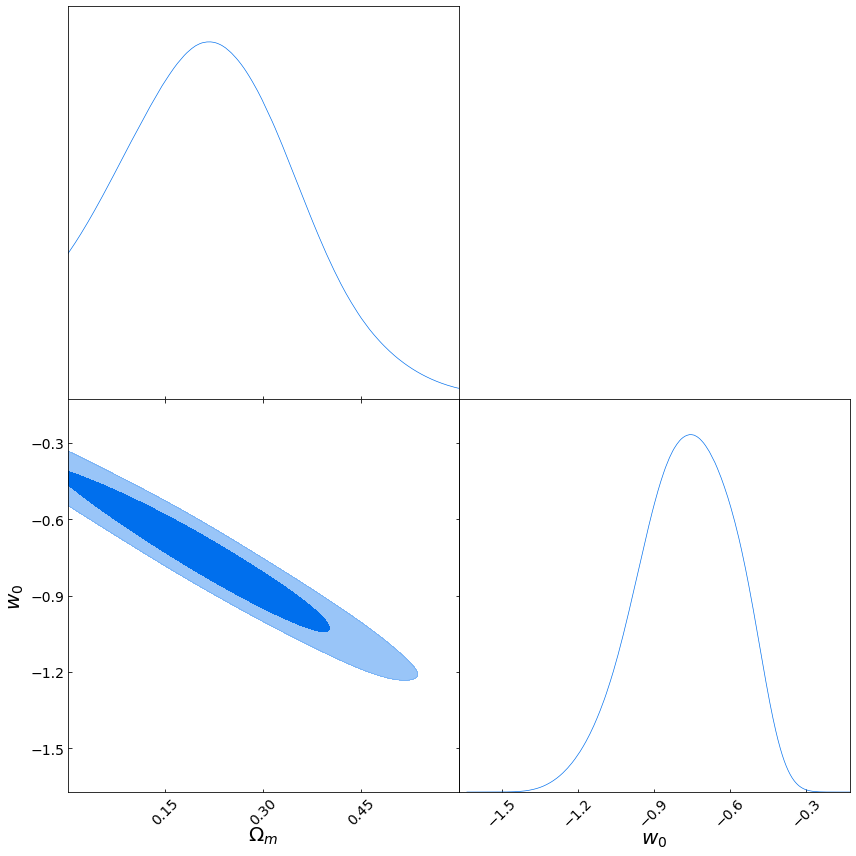

In [6]:
# Do the Fisher pre-training
mdn.fisher_pretraining(50000, prior, epochs=100)

Running initial 100 sims...
Done.
Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 0s 1ms/step - loss: 3.3737 - val_loss: 4.2610
Epoch 2/100
90/90 [==============================] - 0s 1ms/step - loss: 3.0657 - val_loss: 3.5617
Epoch 3/100
90/90 [==============================] - 0s 1ms/step - loss: 2.6091 - val_loss: 3.0248
Epoch 4/100
90/90 [==============================] - 0s 1ms/step - loss: 2.2439 - val_loss: 2.8664
Epoch 5/100
90/90 [==============================] - 0s 1ms/step - loss: 2.0760 - val_loss: 2.8810
Epoch 6/100
90/90 [==============================] - 0s 1ms/step - loss: 2.0491 - val_loss: 2.8562
Epoch 7/100
90/90 [==============================] - 0s 1ms/step - loss: 2.0752 - val_loss: 2.8191
Epoch 8/100
90/90 [==============================] - 0s 1ms/step - loss: 2.0914 - val_loss: 2.7244
Epoch 9/100
90/90 [==============================] - 0s 1ms/step - loss: 2.0682 - val_loss: 2.5854
Epoch 10/100
90/90 [===========

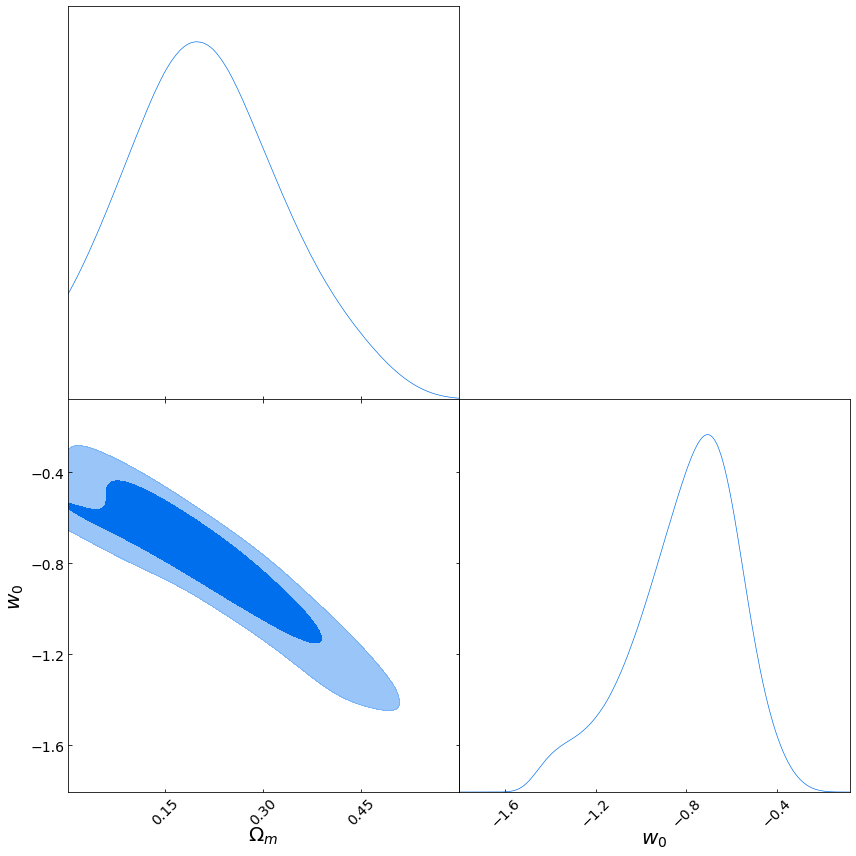

Population 1/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 180 samples, validate on 20 samples
Epoch 1/100
180/180 [==============================] - 0s 1ms/step - loss: 1.7501 - val_loss: 1.6025
Epoch 2/100
180/180 [==============================] - 0s 1ms/step - loss: 1.6646 - val_loss: 1.5889
Epoch 3/100
180/180 [==============================] - 0s 1ms/step - loss: 1.5999 - val_loss: 1.6058
Epoch 4/100
180/180 [==============================] - 0s 1ms/step - loss: 1.5658 - val_loss: 1.6140
Epoch 5/100
180/180 [==============================] - 0s 1ms/step - loss: 1.5394 - val_loss: 1.5972
Epoch 6/100
180/180 [==============================] - 0s 1ms/step - loss: 1.4949 - val_loss: 1.5721
Epoch 7/100
180/180 [==============================] - 0s 1ms/step - loss: 1.4682 - val_loss: 1.5547
Epoch 8/100
180/180 [==============================] - 0s 1ms/step - loss: 1.4637 - val_loss: 1.5376
Epoch 9/100
180/180 [==============================] - 0s 1ms/step - l

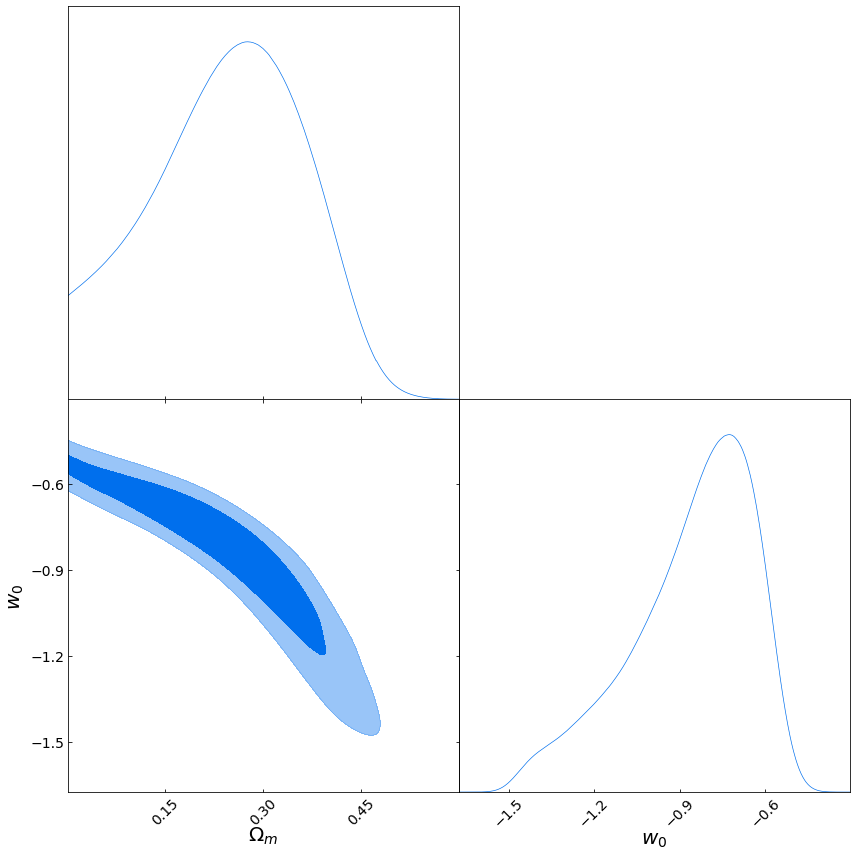

Population 2/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 270 samples, validate on 30 samples
Epoch 1/100
270/270 [==============================] - 0s 1ms/step - loss: 1.3108 - val_loss: 1.6546
Epoch 2/100
270/270 [==============================] - 0s 1ms/step - loss: 1.3000 - val_loss: 1.6214
Epoch 3/100
270/270 [==============================] - 0s 1ms/step - loss: 1.2914 - val_loss: 1.6249
Epoch 4/100
270/270 [==============================] - 0s 1ms/step - loss: 1.2893 - val_loss: 1.5993
Epoch 5/100
270/270 [==============================] - 0s 1ms/step - loss: 1.2811 - val_loss: 1.6039
Epoch 6/100
270/270 [==============================] - 0s 1ms/step - loss: 1.2862 - val_loss: 1.6222
Epoch 7/100
270/270 [==============================] - 0s 1ms/step - loss: 1.2816 - val_loss: 1.6139
Epoch 8/100
270/270 [==============================] - 0s 1ms/step - loss: 1.2795 - val_loss: 1.6152
Epoch 9/100
270/270 [==============================] - 0s 1ms/step - l

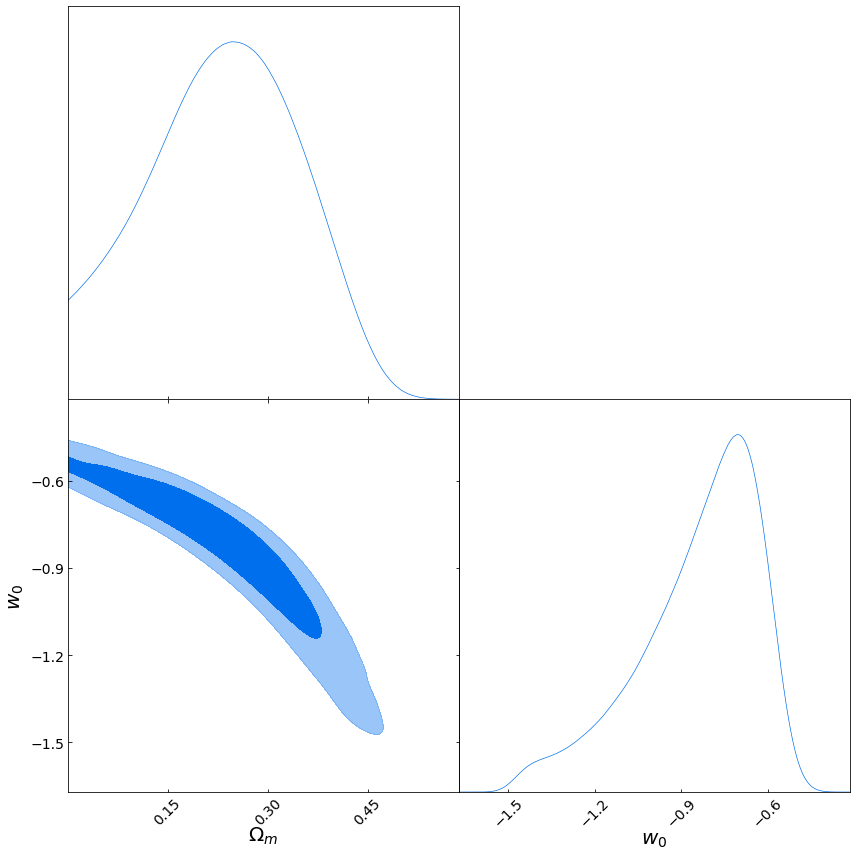

Population 3/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 360 samples, validate on 40 samples
Epoch 1/100
360/360 [==============================] - 0s 1ms/step - loss: 1.3092 - val_loss: 1.0808
Epoch 2/100
360/360 [==============================] - 0s 1ms/step - loss: 1.3174 - val_loss: 1.1342
Epoch 3/100
360/360 [==============================] - 0s 1ms/step - loss: 1.3180 - val_loss: 1.1068
Epoch 4/100
360/360 [==============================] - 0s 1ms/step - loss: 1.3026 - val_loss: 1.0874
Epoch 5/100
360/360 [==============================] - 0s 1ms/step - loss: 1.2996 - val_loss: 1.1508
Epoch 6/100
360/360 [==============================] - 0s 1ms/step - loss: 1.3030 - val_loss: 1.1007
Train on 360 samples, validate on 40 samples
Epoch 1/100
360/360 [==============================] - 0s 1ms/step - loss: 1.2937 - val_loss: 1.0900
Epoch 2/100
360/360 [==============================] - 0s 1ms/step - loss: 1.2954 - val_loss: 1.0891
Epoch 3/100
360/360 [====

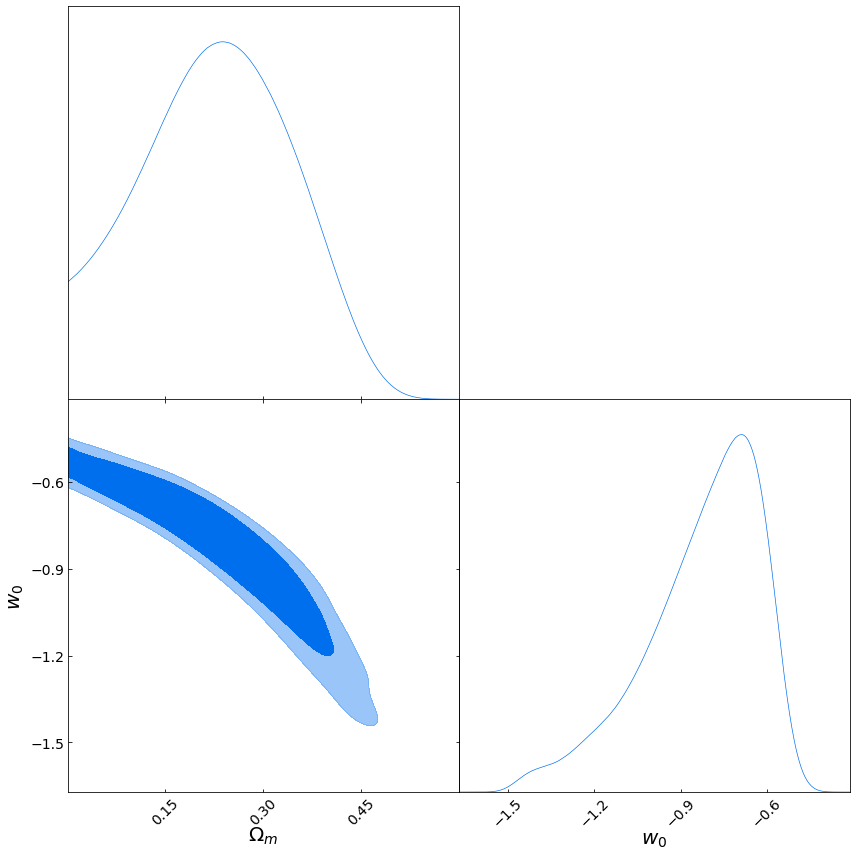

Population 4/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 1s 1ms/step - loss: 1.3095 - val_loss: 1.2650
Epoch 2/100
450/450 [==============================] - 1s 1ms/step - loss: 1.3160 - val_loss: 1.2680
Epoch 3/100
450/450 [==============================] - 1s 1ms/step - loss: 1.3101 - val_loss: 1.2580
Epoch 4/100
450/450 [==============================] - 1s 1ms/step - loss: 1.3232 - val_loss: 1.2777
Epoch 5/100
450/450 [==============================] - 1s 1ms/step - loss: 1.2977 - val_loss: 1.2701
Epoch 6/100
450/450 [==============================] - 1s 1ms/step - loss: 1.2925 - val_loss: 1.2802
Epoch 7/100
450/450 [==============================] - 1s 1ms/step - loss: 1.3020 - val_loss: 1.2871
Epoch 8/100
450/450 [==============================] - 1s 1ms/step - loss: 1.3036 - val_loss: 1.2752
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [====

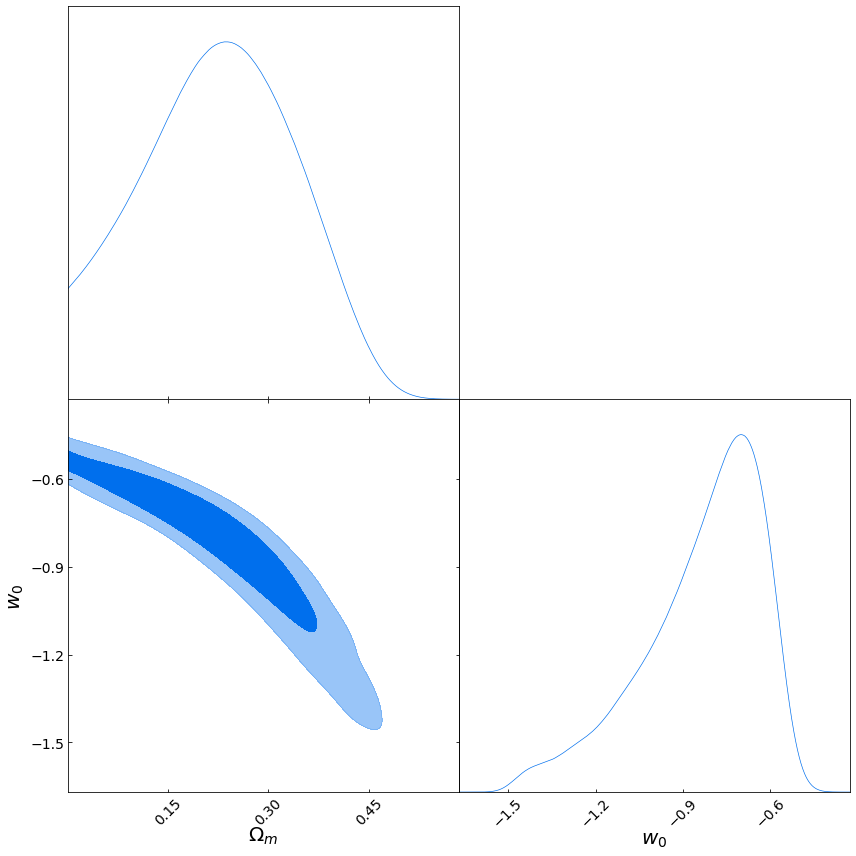

Population 5/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 540 samples, validate on 60 samples
Epoch 1/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3027 - val_loss: 1.1090
Epoch 2/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3055 - val_loss: 1.1398
Epoch 3/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3089 - val_loss: 1.1017
Epoch 4/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3008 - val_loss: 1.1025
Epoch 5/100
540/540 [==============================] - 1s 1ms/step - loss: 1.2931 - val_loss: 1.1498
Epoch 6/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3051 - val_loss: 1.0975
Epoch 7/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3037 - val_loss: 1.1236
Epoch 8/100
540/540 [==============================] - 1s 1ms/step - loss: 1.2989 - val_loss: 1.0631
Epoch 9/100
540/540 [==============================] - 1s 1ms/step - l

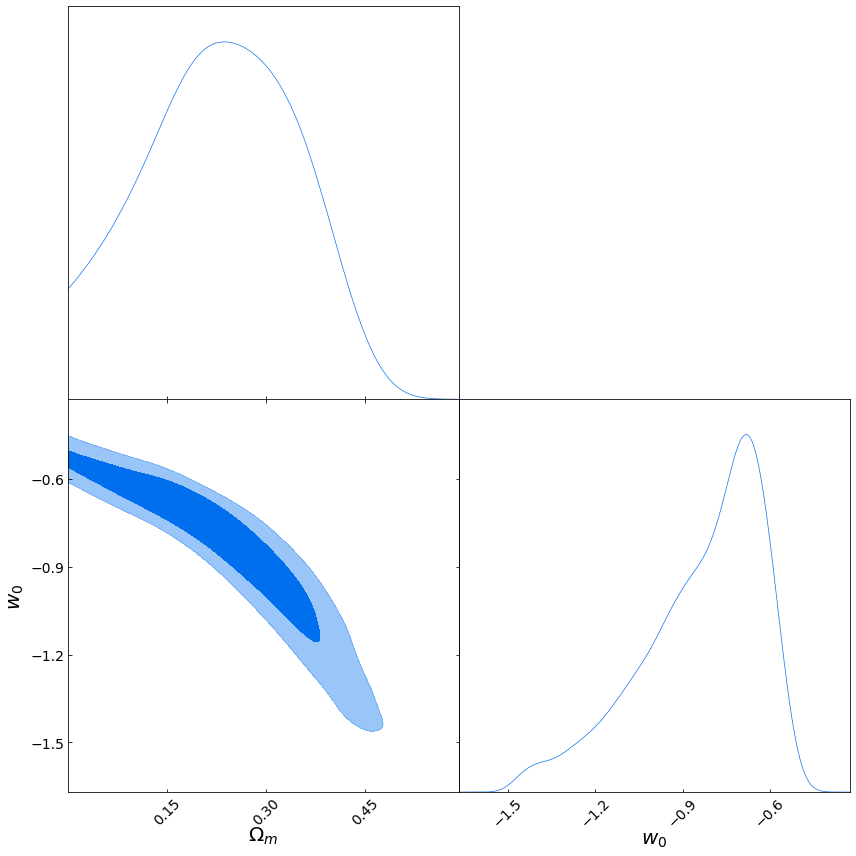

Population 6/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 630 samples, validate on 70 samples
Epoch 1/100
630/630 [==============================] - 1s 1ms/step - loss: 1.2801 - val_loss: 1.3266
Epoch 2/100
630/630 [==============================] - 1s 1ms/step - loss: 1.2878 - val_loss: 1.4248
Epoch 3/100
630/630 [==============================] - 1s 1ms/step - loss: 1.2990 - val_loss: 1.3492
Epoch 4/100
630/630 [==============================] - 1s 1ms/step - loss: 1.2769 - val_loss: 1.3368
Epoch 5/100
630/630 [==============================] - 1s 1ms/step - loss: 1.2775 - val_loss: 1.4040
Epoch 6/100
630/630 [==============================] - 1s 1ms/step - loss: 1.2770 - val_loss: 1.3025
Epoch 7/100
630/630 [==============================] - 1s 1ms/step - loss: 1.2858 - val_loss: 1.3138
Epoch 8/100
630/630 [==============================] - 1s 1ms/step - loss: 1.2782 - val_loss: 1.3895
Epoch 9/100
630/630 [==============================] - 1s 1ms/step - l

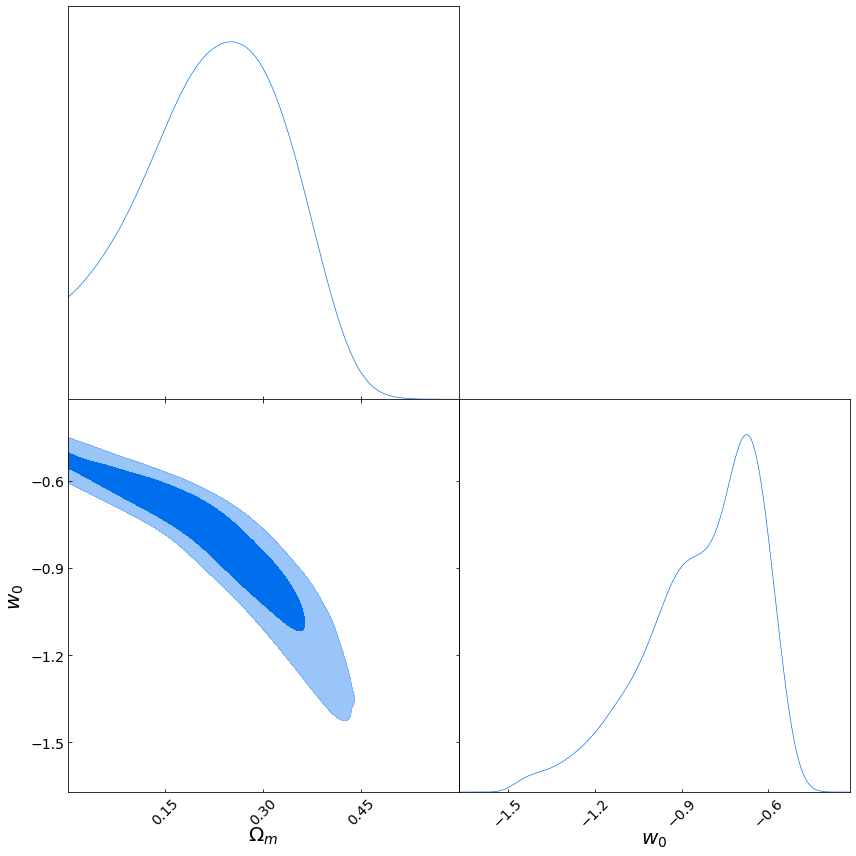

Population 7/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 1s 1ms/step - loss: 1.2852 - val_loss: 1.2433
Epoch 2/100
720/720 [==============================] - 1s 1ms/step - loss: 1.2899 - val_loss: 1.2438
Epoch 3/100
720/720 [==============================] - 1s 1ms/step - loss: 1.2998 - val_loss: 1.2545
Epoch 4/100
720/720 [==============================] - 1s 1ms/step - loss: 1.2913 - val_loss: 1.2500
Epoch 5/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3014 - val_loss: 1.2346
Epoch 6/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3047 - val_loss: 1.2109
Epoch 7/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3417 - val_loss: 1.2451
Epoch 8/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3066 - val_loss: 1.2300
Epoch 9/100
720/720 [==============================] - 1s 1ms/step - l

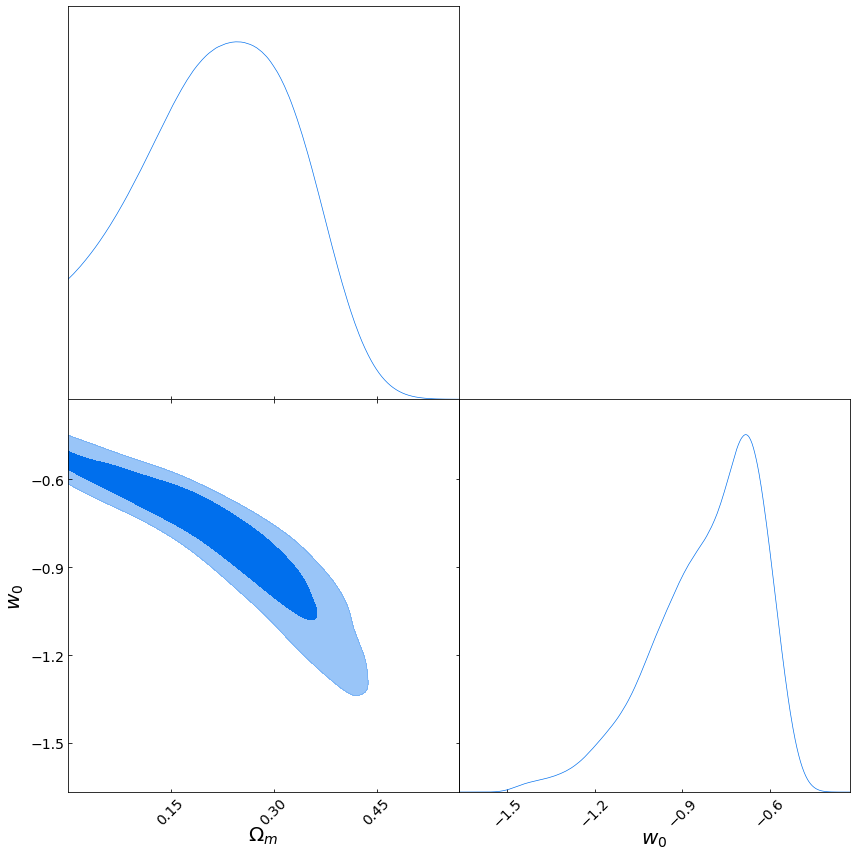

Population 8/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 810 samples, validate on 90 samples
Epoch 1/100
810/810 [==============================] - 1s 1ms/step - loss: 1.2732 - val_loss: 1.2397
Epoch 2/100
810/810 [==============================] - 1s 1ms/step - loss: 1.2907 - val_loss: 1.2279
Epoch 3/100
810/810 [==============================] - 1s 1ms/step - loss: 1.3047 - val_loss: 1.1939
Epoch 4/100
810/810 [==============================] - 1s 1ms/step - loss: 1.3193 - val_loss: 1.2039
Epoch 5/100
810/810 [==============================] - 1s 1ms/step - loss: 1.3116 - val_loss: 1.2262
Epoch 6/100
810/810 [==============================] - 1s 1ms/step - loss: 1.2955 - val_loss: 1.1969
Epoch 7/100
810/810 [==============================] - 1s 1ms/step - loss: 1.2836 - val_loss: 1.2152
Epoch 8/100
810/810 [==============================] - 1s 1ms/step - loss: 1.3006 - val_loss: 1.2428
Train on 810 samples, validate on 90 samples
Epoch 1/100
810/810 [====

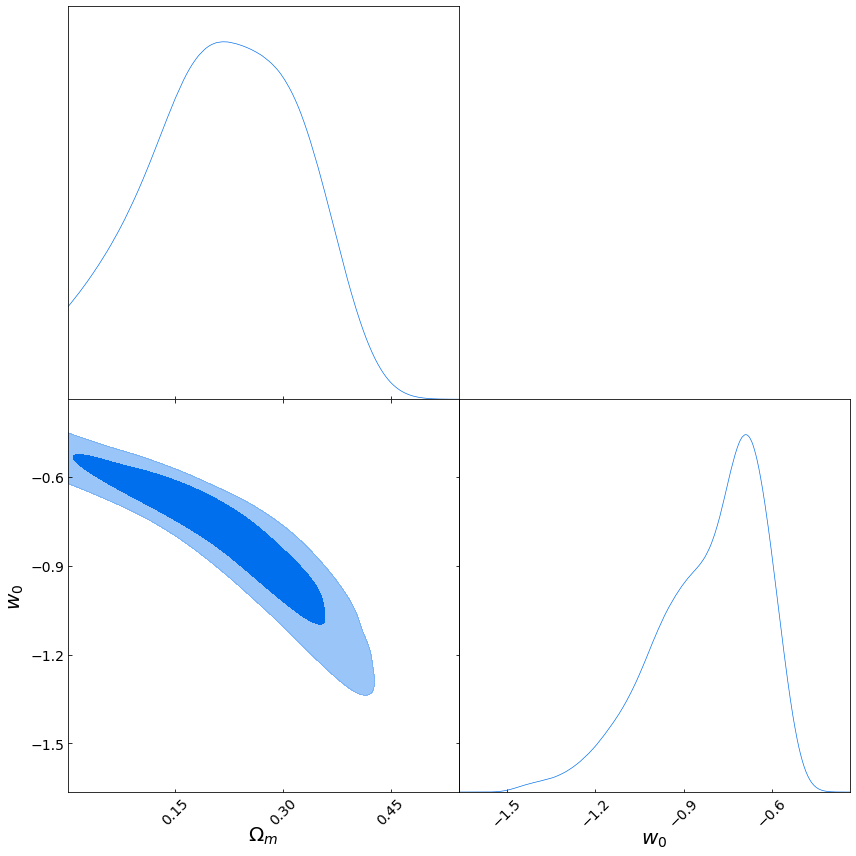

Population 9/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 1ms/step - loss: 1.2662 - val_loss: 1.5699
Epoch 2/100
900/900 [==============================] - 1s 1ms/step - loss: 1.2710 - val_loss: 1.6304
Epoch 3/100
900/900 [==============================] - 1s 1ms/step - loss: 1.2632 - val_loss: 1.5360
Epoch 4/100
900/900 [==============================] - 1s 1ms/step - loss: 1.2654 - val_loss: 1.5283
Epoch 5/100
900/900 [==============================] - 1s 1ms/step - loss: 1.2677 - val_loss: 1.5435
Epoch 6/100
900/900 [==============================] - 1s 1ms/step - loss: 1.2625 - val_loss: 1.5409
Epoch 7/100
900/900 [==============================] - 1s 1ms/step - loss: 1.2614 - val_loss: 1.5615
Epoch 8/100
900/900 [==============================] - 1s 1ms/step - loss: 1.2661 - val_loss: 1.5396
Epoch 9/100
900/900 [==============================] - 1s 1ms/step - 

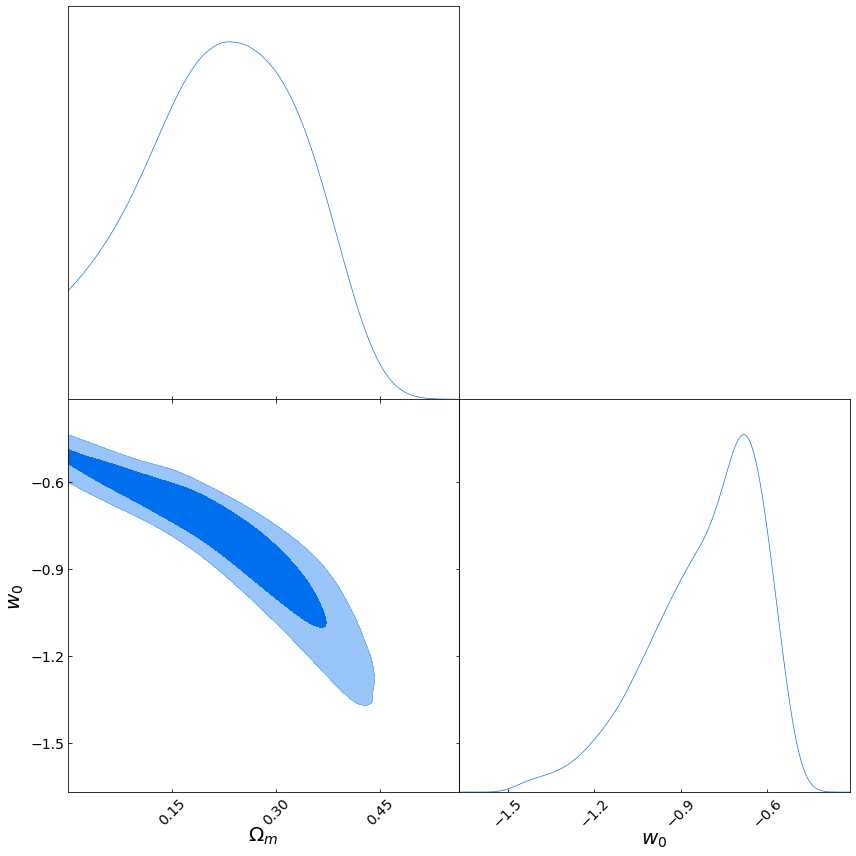

Population 10/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 990 samples, validate on 110 samples
Epoch 1/100
990/990 [==============================] - 1s 1ms/step - loss: 1.2947 - val_loss: 1.3269
Epoch 2/100
990/990 [==============================] - 1s 1ms/step - loss: 1.2919 - val_loss: 1.2969
Epoch 3/100
990/990 [==============================] - 1s 1ms/step - loss: 1.2937 - val_loss: 1.2996
Epoch 4/100
990/990 [==============================] - 1s 1ms/step - loss: 1.3027 - val_loss: 1.2986
Epoch 5/100
990/990 [==============================] - 1s 1ms/step - loss: 1.3000 - val_loss: 1.3272
Epoch 6/100
990/990 [==============================] - 1s 1ms/step - loss: 1.2956 - val_loss: 1.2959
Epoch 7/100
990/990 [==============================] - 3s 3ms/step - loss: 1.2863 - val_loss: 1.2877
Epoch 8/100
990/990 [==============================] - 3s 3ms/step - loss: 1.2889 - val_loss: 1.2964
Epoch 9/100
990/990 [==============================] - 1s 1ms/step -

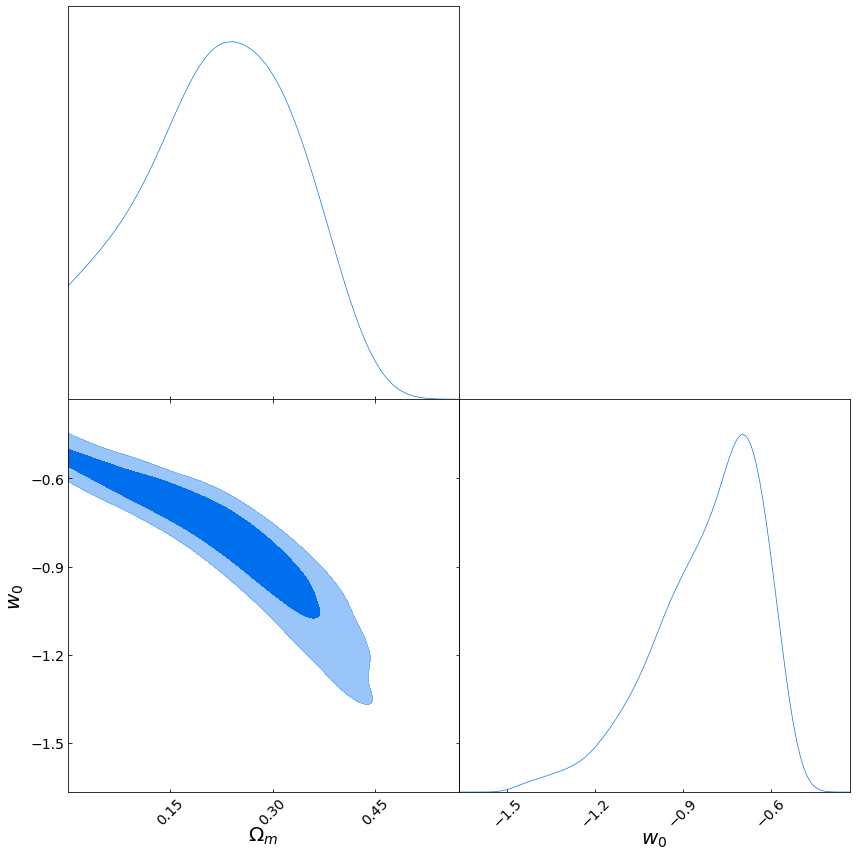

Population 11/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 1080 samples, validate on 120 samples
Epoch 1/100
1080/1080 [==============================] - 1s 1ms/step - loss: 1.2848 - val_loss: 1.5259
Epoch 2/100
1080/1080 [==============================] - 2s 1ms/step - loss: 1.2794 - val_loss: 1.5408
Epoch 3/100
1080/1080 [==============================] - 2s 1ms/step - loss: 1.2875 - val_loss: 1.5144
Epoch 4/100
1080/1080 [==============================] - 2s 1ms/step - loss: 1.2784 - val_loss: 1.5415
Epoch 5/100
1080/1080 [==============================] - 2s 1ms/step - loss: 1.2799 - val_loss: 1.4984
Epoch 6/100
1080/1080 [==============================] - 2s 1ms/step - loss: 1.2755 - val_loss: 1.5831
Epoch 7/100
1080/1080 [==============================] - 2s 1ms/step - loss: 1.2815 - val_loss: 1.5510
Epoch 8/100
1080/1080 [==============================] - 2s 1ms/step - loss: 1.2889 - val_loss: 1.5107
Epoch 9/100
1080/1080 [============================

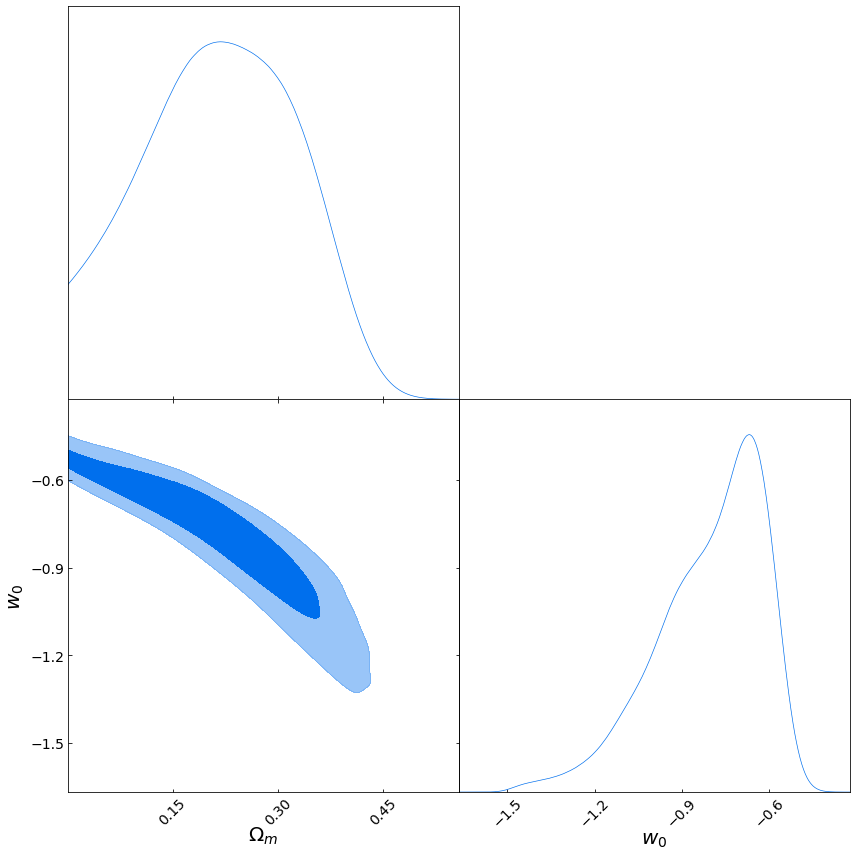

Population 12/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 1170 samples, validate on 130 samples
Epoch 1/100
1170/1170 [==============================] - 2s 1ms/step - loss: 1.2862 - val_loss: 1.3767
Epoch 2/100
1170/1170 [==============================] - 2s 1ms/step - loss: 1.2883 - val_loss: 1.3764
Epoch 3/100
1170/1170 [==============================] - 2s 2ms/step - loss: 1.2909 - val_loss: 1.3760
Epoch 4/100
1170/1170 [==============================] - 2s 2ms/step - loss: 1.2898 - val_loss: 1.4113
Epoch 5/100
1170/1170 [==============================] - 2s 2ms/step - loss: 1.3053 - val_loss: 1.4348
Epoch 6/100
1170/1170 [==============================] - 2s 2ms/step - loss: 1.3041 - val_loss: 1.4213
Epoch 7/100
1170/1170 [==============================] - 2s 1ms/step - loss: 1.2915 - val_loss: 1.3875
Epoch 8/100
1170/1170 [==============================] - 2s 1ms/step - loss: 1.2943 - val_loss: 1.4064
Train on 1170 samples, validate on 130 samples
Epoc

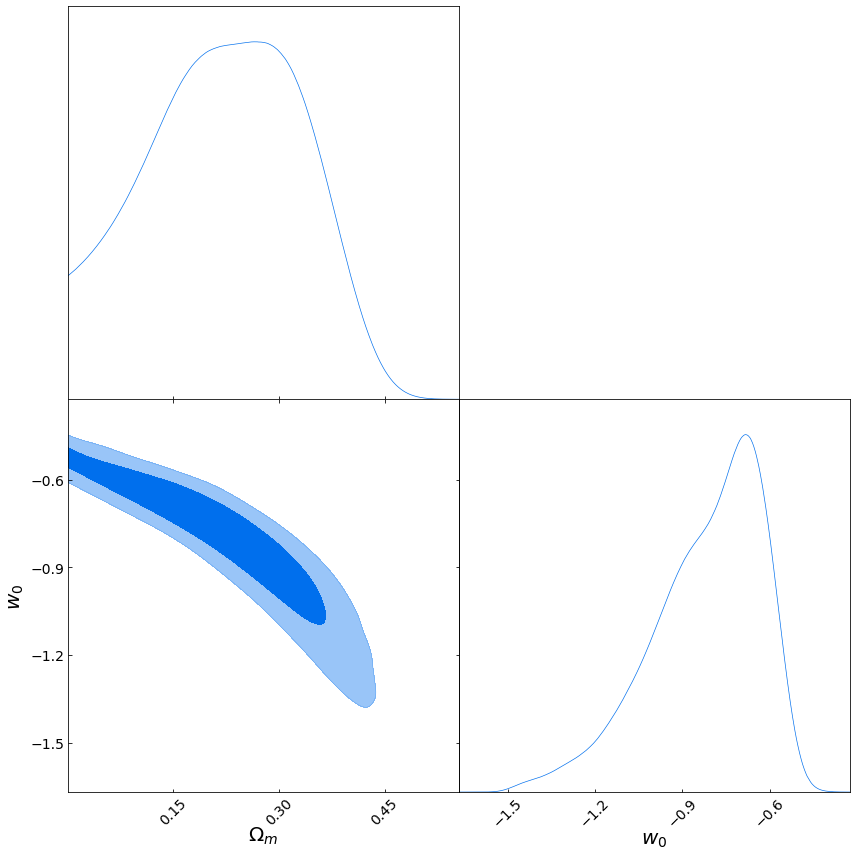

Population 13/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 1260 samples, validate on 140 samples
Epoch 1/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.2963 - val_loss: 1.4797
Epoch 2/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.3003 - val_loss: 1.4796
Epoch 3/100
1260/1260 [==============================] - 2s 2ms/step - loss: 1.3113 - val_loss: 1.4784
Epoch 4/100
1260/1260 [==============================] - 2s 2ms/step - loss: 1.3016 - val_loss: 1.4652
Epoch 5/100
1260/1260 [==============================] - 2s 2ms/step - loss: 1.3034 - val_loss: 1.4788
Epoch 6/100
1260/1260 [==============================] - 2s 2ms/step - loss: 1.3036 - val_loss: 1.4648
Epoch 7/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.3030 - val_loss: 1.4626
Epoch 8/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.3007 - val_loss: 1.4669
Epoch 9/100
1260/1260 [============================

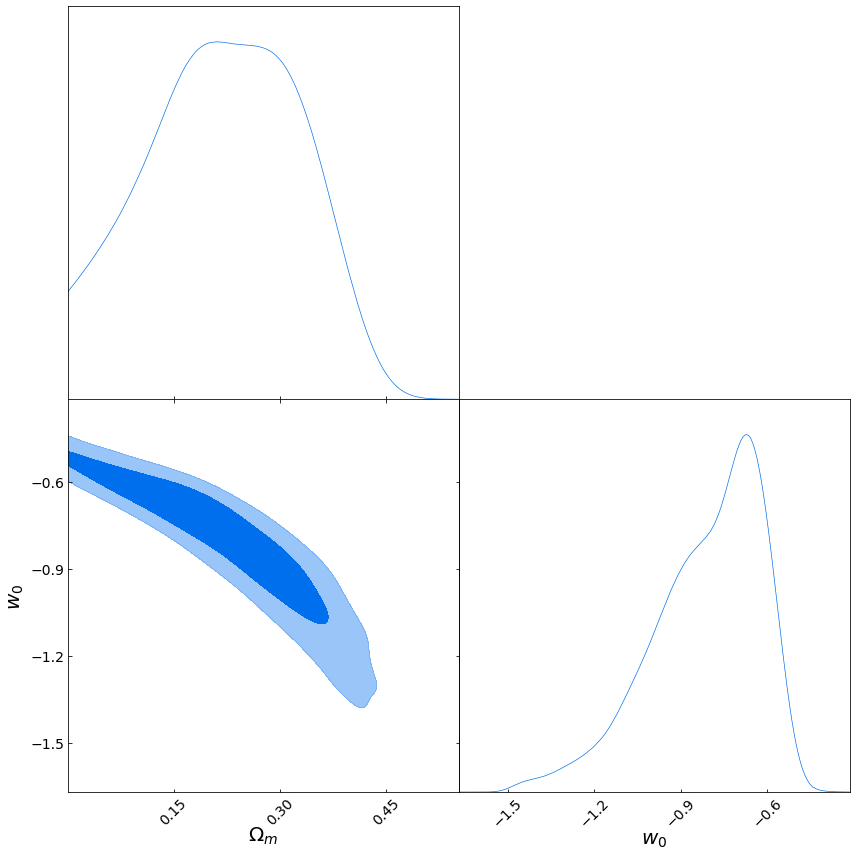

Population 14/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 2s 1ms/step - loss: 1.3007 - val_loss: 1.4115
Epoch 2/100
1350/1350 [==============================] - 2s 1ms/step - loss: 1.3159 - val_loss: 1.4107
Epoch 3/100
1350/1350 [==============================] - 2s 1ms/step - loss: 1.3161 - val_loss: 1.4286
Epoch 4/100
1350/1350 [==============================] - 2s 1ms/step - loss: 1.3117 - val_loss: 1.4571
Epoch 5/100
1350/1350 [==============================] - 2s 1ms/step - loss: 1.3070 - val_loss: 1.4302
Epoch 6/100
1350/1350 [==============================] - 2s 1ms/step - loss: 1.3115 - val_loss: 1.4414
Epoch 7/100
1350/1350 [==============================] - 2s 1ms/step - loss: 1.3137 - val_loss: 1.4479
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 2s 1ms/step - loss: 1.3256 - val_loss: 1.4592
Epoc

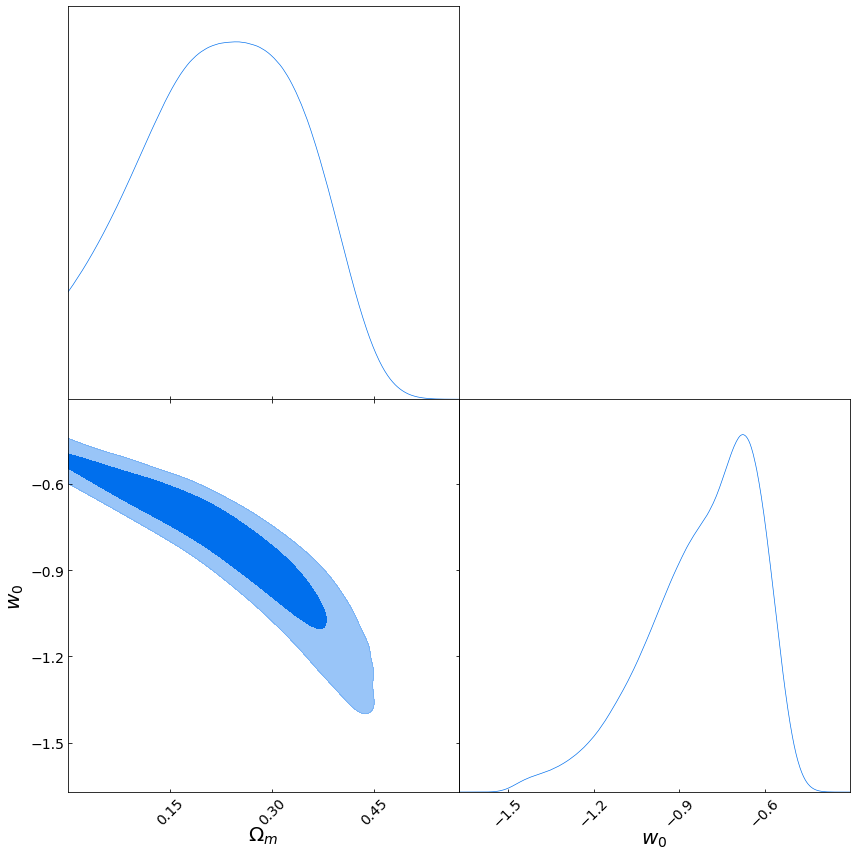

Population 15/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 1440 samples, validate on 160 samples
Epoch 1/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3125 - val_loss: 1.3813
Epoch 2/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3144 - val_loss: 1.3754
Epoch 3/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3124 - val_loss: 1.3787
Epoch 4/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3202 - val_loss: 1.3802
Epoch 5/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3181 - val_loss: 1.3789
Epoch 6/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3356 - val_loss: 1.3887
Epoch 7/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3164 - val_loss: 1.3806
Train on 1440 samples, validate on 160 samples
Epoch 1/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3081 - val_loss: 1.3810
Epoc

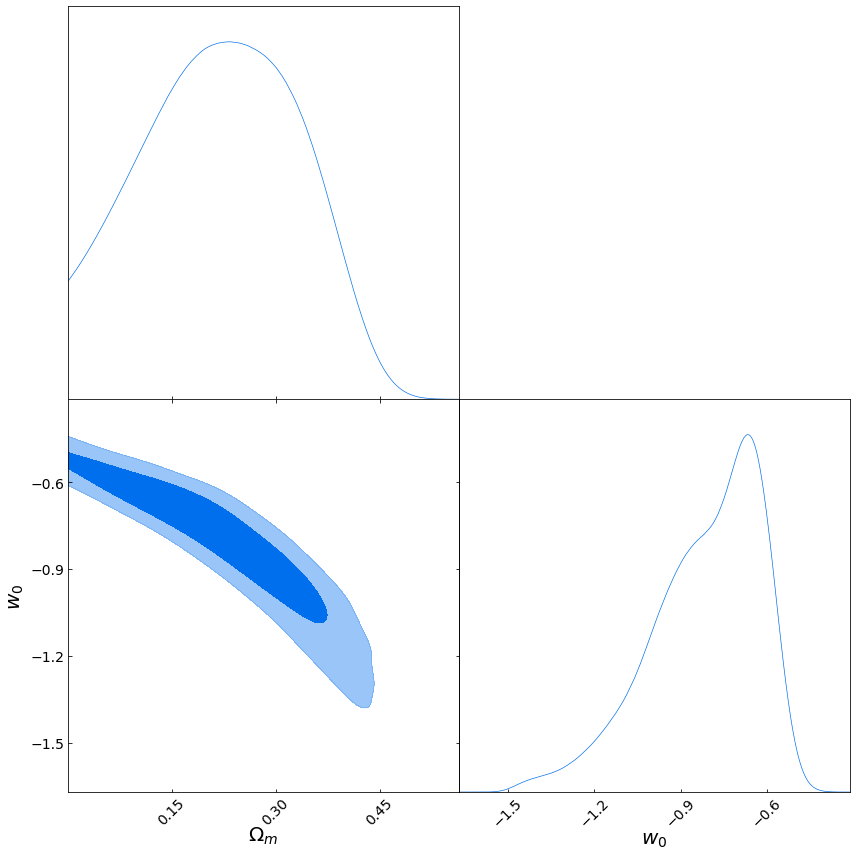

Population 16/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 1530 samples, validate on 170 samples
Epoch 1/100
1530/1530 [==============================] - 2s 1ms/step - loss: 1.3173 - val_loss: 1.3307
Epoch 2/100
1530/1530 [==============================] - 2s 1ms/step - loss: 1.3210 - val_loss: 1.3363
Epoch 3/100
1530/1530 [==============================] - 2s 1ms/step - loss: 1.3218 - val_loss: 1.3370
Epoch 4/100
1530/1530 [==============================] - 2s 1ms/step - loss: 1.3151 - val_loss: 1.3406
Epoch 5/100
1530/1530 [==============================] - 2s 1ms/step - loss: 1.3111 - val_loss: 1.3642
Epoch 6/100
1530/1530 [==============================] - 2s 1ms/step - loss: 1.3221 - val_loss: 1.3669
Train on 1530 samples, validate on 170 samples
Epoch 1/100
1530/1530 [==============================] - 2s 1ms/step - loss: 1.3147 - val_loss: 1.3580
Epoch 2/100
1530/1530 [==============================] - 2s 1ms/step - loss: 1.3167 - val_loss: 1.3488
Epoc

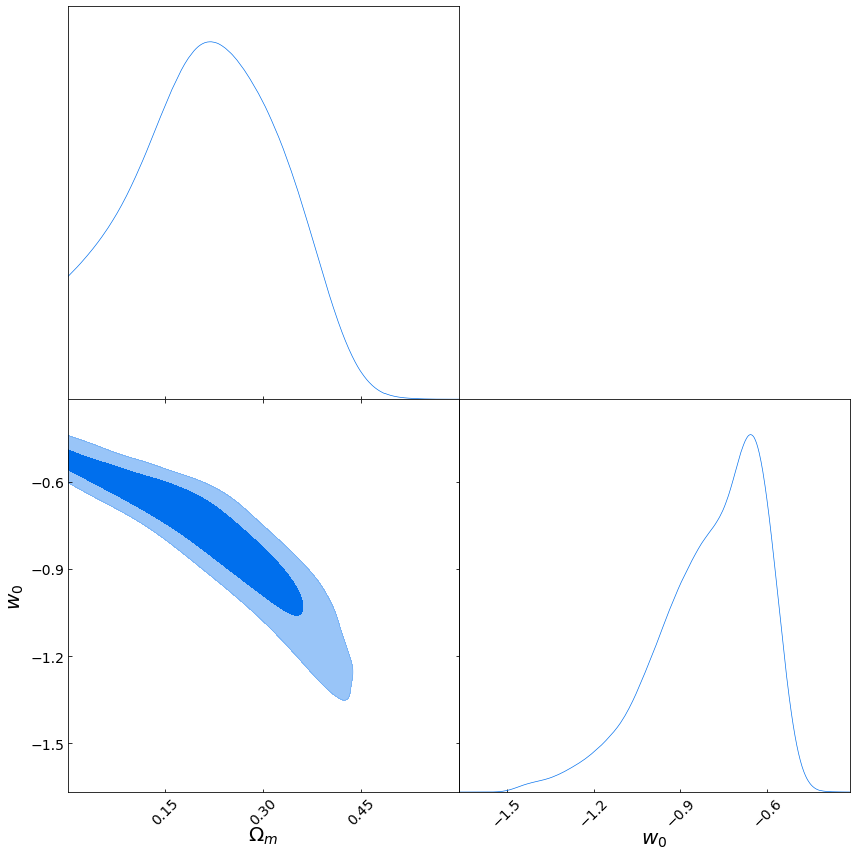

Population 17/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 1620 samples, validate on 180 samples
Epoch 1/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3123 - val_loss: 1.2902
Epoch 2/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3311 - val_loss: 1.2843
Epoch 3/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3373 - val_loss: 1.3153
Epoch 4/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3260 - val_loss: 1.3254
Epoch 5/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3141 - val_loss: 1.2804
Epoch 6/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3159 - val_loss: 1.2883
Epoch 7/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3120 - val_loss: 1.2884
Epoch 8/100
1620/1620 [==============================] - 5s 3ms/step - loss: 1.3263 - val_loss: 1.2996
Epoch 9/100
1620/1620 [============================

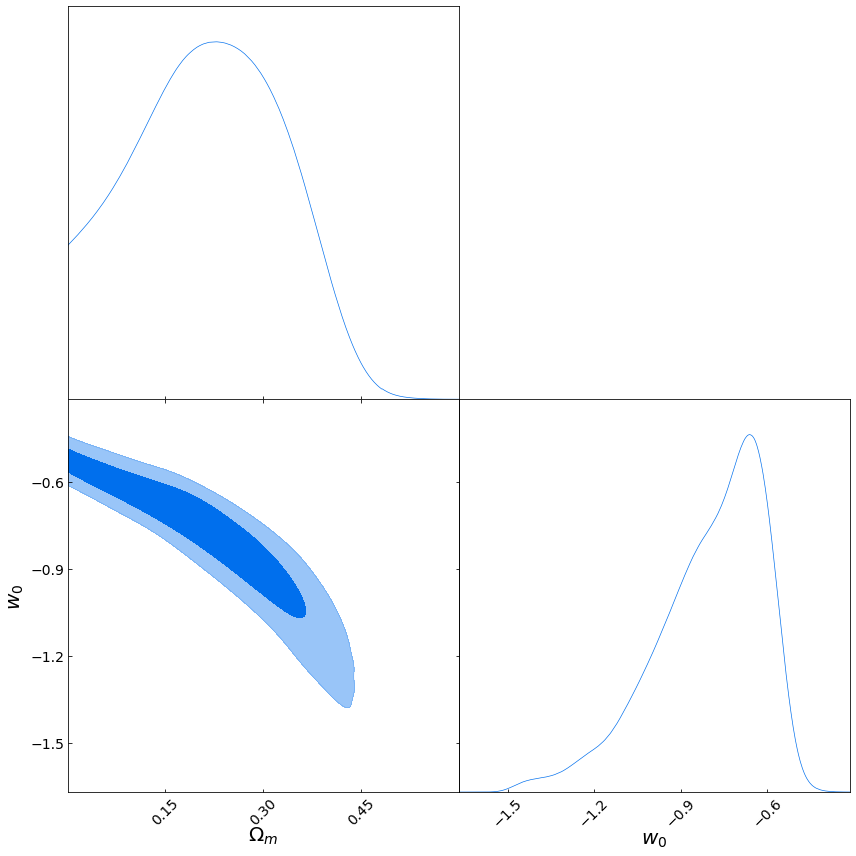

Population 18/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 1710 samples, validate on 190 samples
Epoch 1/100
1710/1710 [==============================] - 2s 1ms/step - loss: 1.3099 - val_loss: 1.3225
Epoch 2/100
1710/1710 [==============================] - 2s 1ms/step - loss: 1.3273 - val_loss: 1.3077
Epoch 3/100
1710/1710 [==============================] - 2s 1ms/step - loss: 1.3224 - val_loss: 1.3832
Epoch 4/100
1710/1710 [==============================] - 2s 1ms/step - loss: 1.3338 - val_loss: 1.2892
Epoch 5/100
1710/1710 [==============================] - 2s 1ms/step - loss: 1.3143 - val_loss: 1.3489
Epoch 6/100
1710/1710 [==============================] - 2s 1ms/step - loss: 1.3211 - val_loss: 1.3470
Epoch 7/100
1710/1710 [==============================] - 2s 1ms/step - loss: 1.3206 - val_loss: 1.2976
Epoch 8/100
1710/1710 [==============================] - 2s 1ms/step - loss: 1.3257 - val_loss: 1.2823
Epoch 9/100
1710/1710 [============================

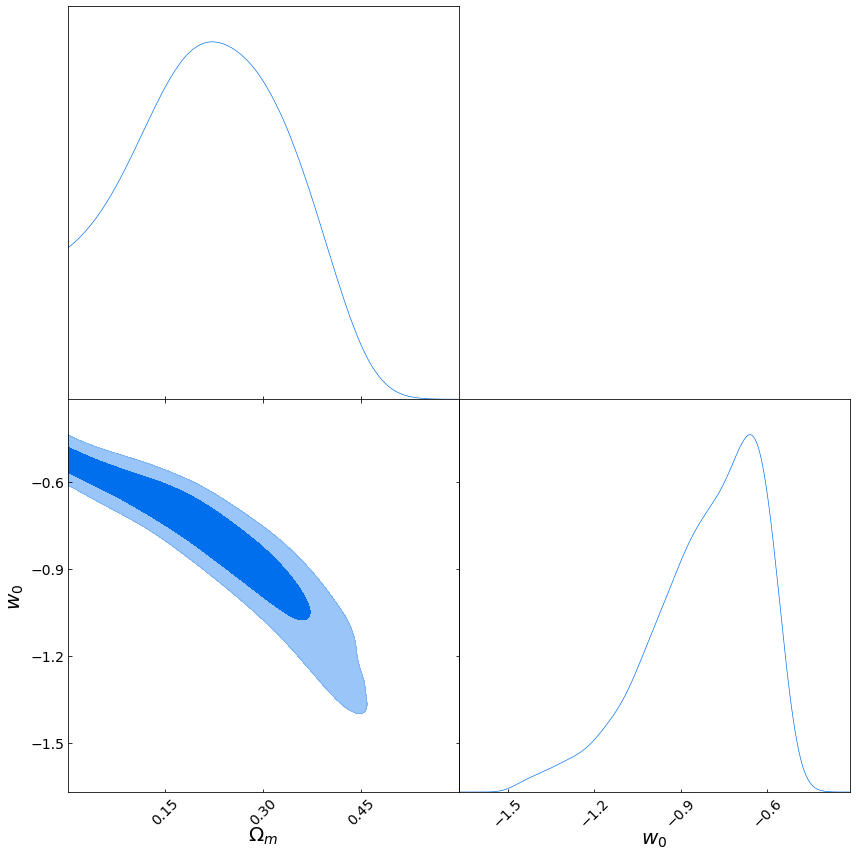

Population 19/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 2s 1ms/step - loss: 1.3069 - val_loss: 1.3019
Epoch 2/100
1800/1800 [==============================] - 3s 1ms/step - loss: 1.3113 - val_loss: 1.3127
Epoch 3/100
1800/1800 [==============================] - 2s 1ms/step - loss: 1.3112 - val_loss: 1.2917
Epoch 4/100
1800/1800 [==============================] - 2s 1ms/step - loss: 1.3079 - val_loss: 1.3173
Epoch 5/100
1800/1800 [==============================] - 2s 1ms/step - loss: 1.3168 - val_loss: 1.3008
Epoch 6/100
1800/1800 [==============================] - 2s 1ms/step - loss: 1.3217 - val_loss: 1.3052
Epoch 7/100
1800/1800 [==============================] - 2s 1ms/step - loss: 1.3048 - val_loss: 1.2899
Epoch 8/100
1800/1800 [==============================] - 2s 1ms/step - loss: 1.3096 - val_loss: 1.2856
Epoch 9/100
1800/1800 [============================

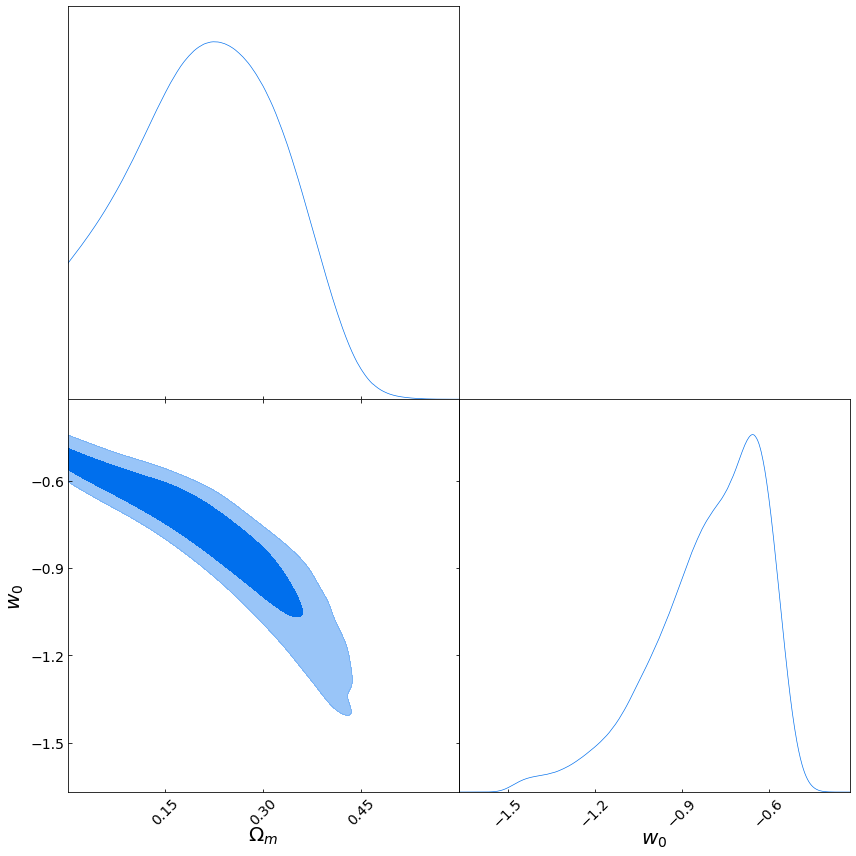

Population 20/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 1890 samples, validate on 210 samples
Epoch 1/100
1890/1890 [==============================] - 3s 1ms/step - loss: 1.3117 - val_loss: 1.2950
Epoch 2/100
1890/1890 [==============================] - 3s 1ms/step - loss: 1.3104 - val_loss: 1.2841
Epoch 3/100
1890/1890 [==============================] - 3s 1ms/step - loss: 1.3144 - val_loss: 1.2989
Epoch 4/100
1890/1890 [==============================] - 3s 1ms/step - loss: 1.3140 - val_loss: 1.2898
Epoch 5/100
1890/1890 [==============================] - 3s 1ms/step - loss: 1.3163 - val_loss: 1.3502
Epoch 6/100
1890/1890 [==============================] - 3s 1ms/step - loss: 1.3373 - val_loss: 1.2958
Epoch 7/100
1890/1890 [==============================] - 3s 1ms/step - loss: 1.3162 - val_loss: 1.2835
Epoch 8/100
1890/1890 [==============================] - 3s 1ms/step - loss: 1.3091 - val_loss: 1.2939
Epoch 9/100
1890/1890 [============================

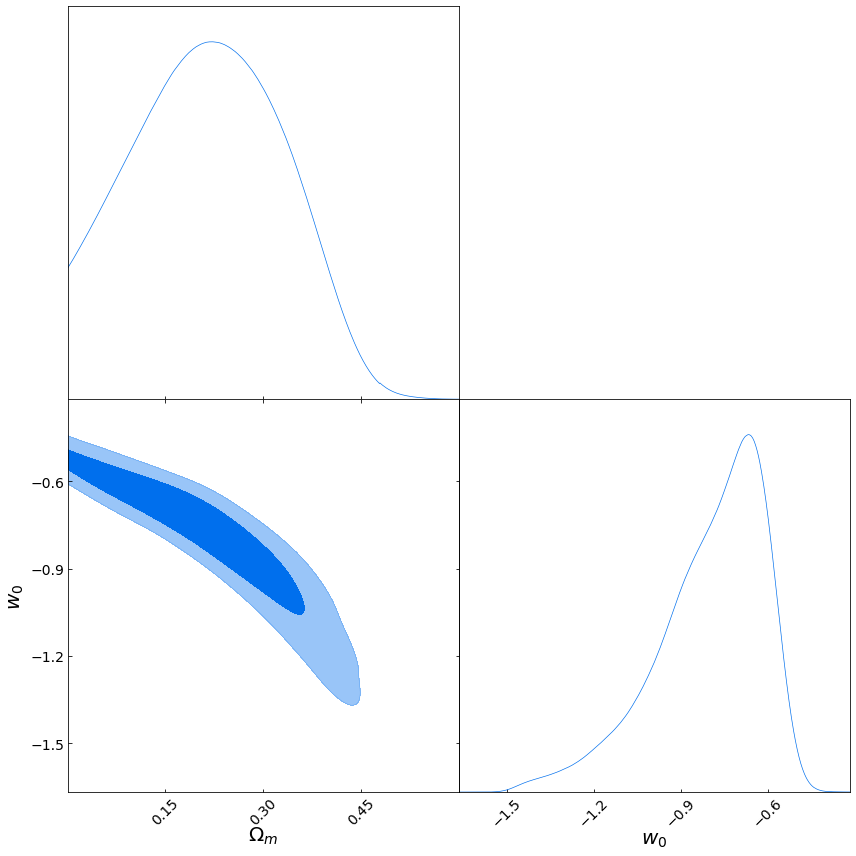

Population 21/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 1980 samples, validate on 220 samples
Epoch 1/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3006 - val_loss: 1.4886
Epoch 2/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.2959 - val_loss: 1.4777
Epoch 3/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3052 - val_loss: 1.4921
Epoch 4/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3030 - val_loss: 1.4843
Epoch 5/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3067 - val_loss: 1.4679
Epoch 6/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.2998 - val_loss: 1.5181
Epoch 7/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3029 - val_loss: 1.5199
Epoch 8/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3113 - val_loss: 1.4838
Epoch 9/100
1980/1980 [============================

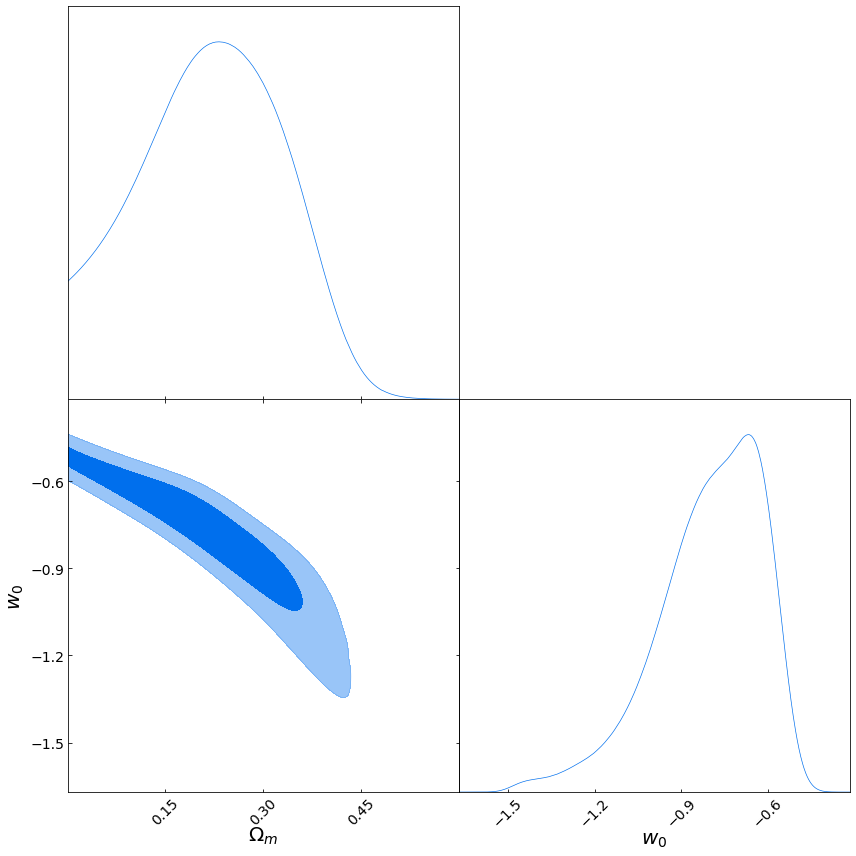

Population 22/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 2070 samples, validate on 230 samples
Epoch 1/100
2070/2070 [==============================] - 3s 1ms/step - loss: 1.3003 - val_loss: 1.5082
Epoch 2/100
2070/2070 [==============================] - 3s 1ms/step - loss: 1.3021 - val_loss: 1.5171
Epoch 3/100
2070/2070 [==============================] - 3s 1ms/step - loss: 1.3013 - val_loss: 1.5405
Epoch 4/100
2070/2070 [==============================] - 3s 1ms/step - loss: 1.3113 - val_loss: 1.5312
Epoch 5/100
2070/2070 [==============================] - 3s 1ms/step - loss: 1.3060 - val_loss: 1.5147
Epoch 6/100
2070/2070 [==============================] - 3s 1ms/step - loss: 1.3070 - val_loss: 1.4987
Epoch 7/100
2070/2070 [==============================] - 3s 1ms/step - loss: 1.3031 - val_loss: 1.5096
Epoch 8/100
2070/2070 [==============================] - 3s 1ms/step - loss: 1.3200 - val_loss: 1.5617
Epoch 9/100
2070/2070 [============================

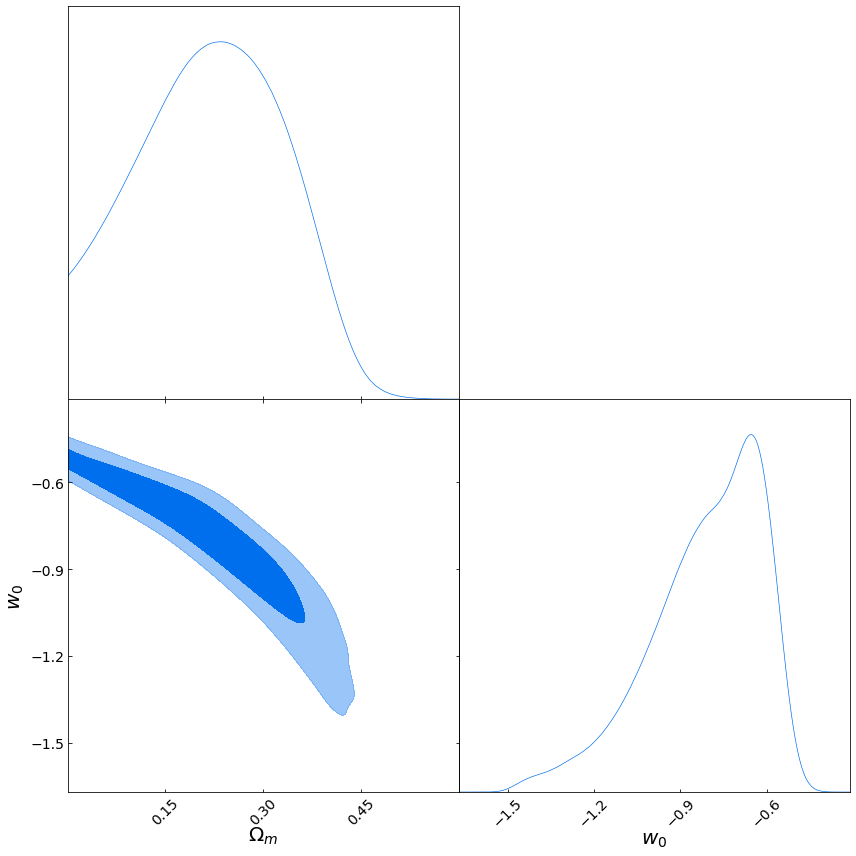

Population 23/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 2160 samples, validate on 240 samples
Epoch 1/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3084 - val_loss: 1.4890
Epoch 2/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3143 - val_loss: 1.4731
Epoch 3/100
2160/2160 [==============================] - 4s 2ms/step - loss: 1.3169 - val_loss: 1.4574
Epoch 4/100
2160/2160 [==============================] - 3s 2ms/step - loss: 1.3072 - val_loss: 1.4752
Epoch 5/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3136 - val_loss: 1.4985
Epoch 6/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3165 - val_loss: 1.4716
Epoch 7/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3132 - val_loss: 1.4792
Epoch 8/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3112 - val_loss: 1.4735
Train on 2160 samples, validate on 240 samples
Epoc

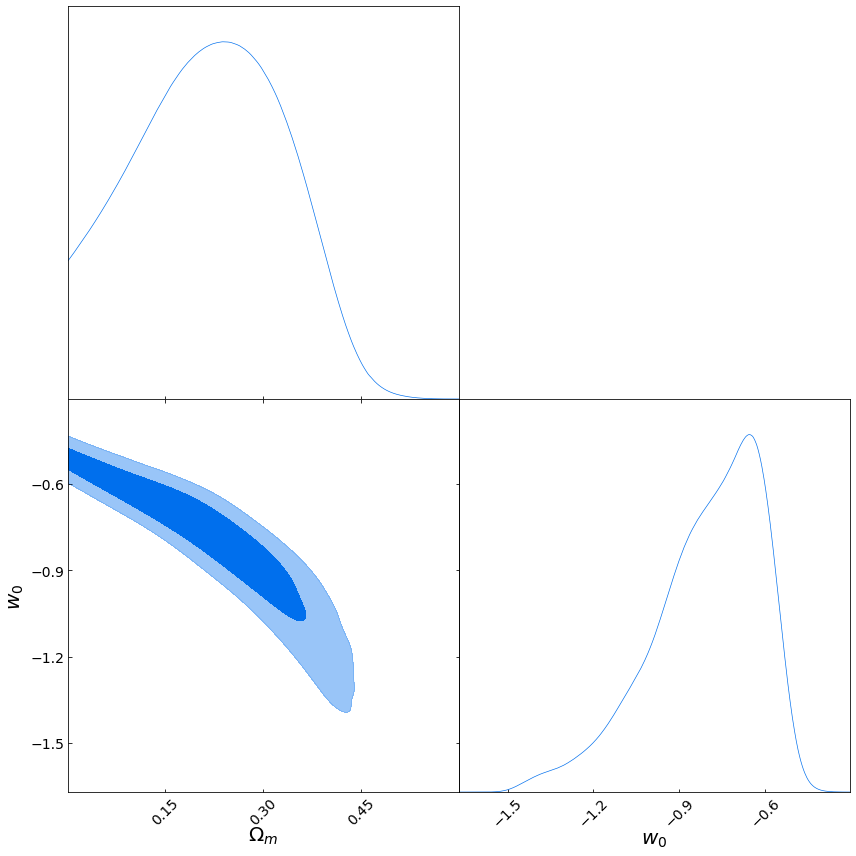

Population 24/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 2250 samples, validate on 250 samples
Epoch 1/100
2250/2250 [==============================] - 9s 4ms/step - loss: 1.3195 - val_loss: 1.4038
Epoch 2/100
2250/2250 [==============================] - 10s 4ms/step - loss: 1.3234 - val_loss: 1.3972
Epoch 3/100
2250/2250 [==============================] - 4s 2ms/step - loss: 1.3203 - val_loss: 1.3998
Epoch 4/100
2250/2250 [==============================] - 4s 2ms/step - loss: 1.3254 - val_loss: 1.4089
Epoch 5/100
2250/2250 [==============================] - 4s 2ms/step - loss: 1.3177 - val_loss: 1.3999
Epoch 6/100
2250/2250 [==============================] - 4s 2ms/step - loss: 1.3216 - val_loss: 1.4383
Epoch 7/100
2250/2250 [==============================] - 6s 3ms/step - loss: 1.3267 - val_loss: 1.3896
Epoch 8/100
2250/2250 [==============================] - 3s 2ms/step - loss: 1.3208 - val_loss: 1.3942
Epoch 9/100
2250/2250 [===========================

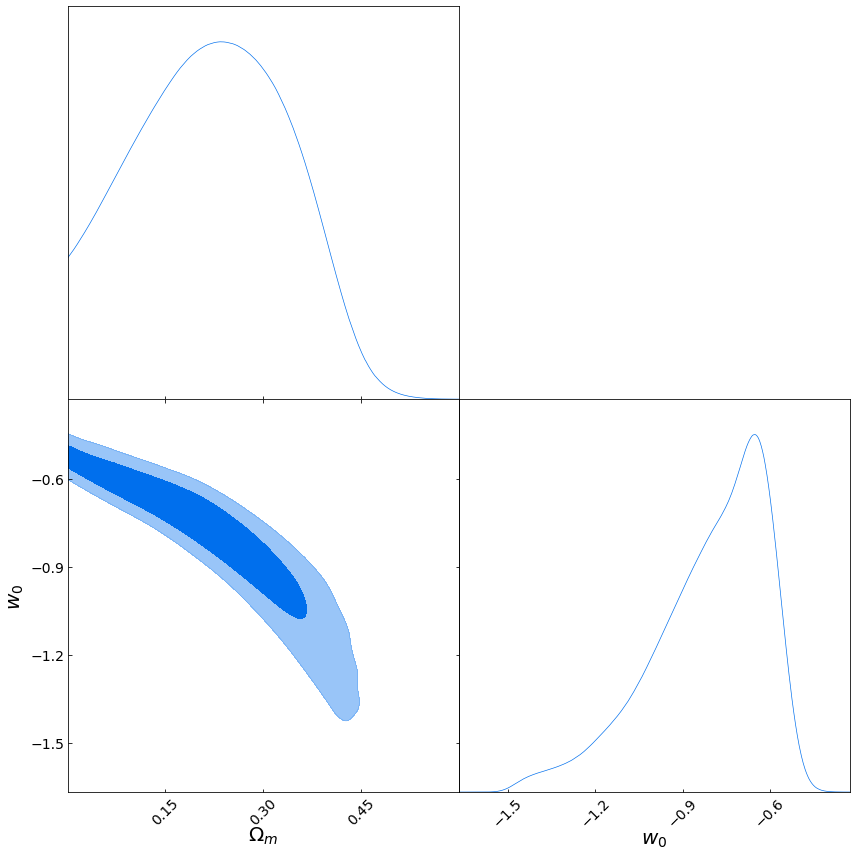

Population 25/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 2340 samples, validate on 260 samples
Epoch 1/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3287 - val_loss: 1.3944
Epoch 2/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3269 - val_loss: 1.3963
Epoch 3/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3316 - val_loss: 1.3977
Epoch 4/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3335 - val_loss: 1.4043
Epoch 5/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3292 - val_loss: 1.3964
Epoch 6/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3285 - val_loss: 1.4029
Train on 2340 samples, validate on 260 samples
Epoch 1/100
2340/2340 [==============================] - 4s 2ms/step - loss: 1.3188 - val_loss: 1.4090
Epoch 2/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3193 - val_loss: 1.4152
Epoc

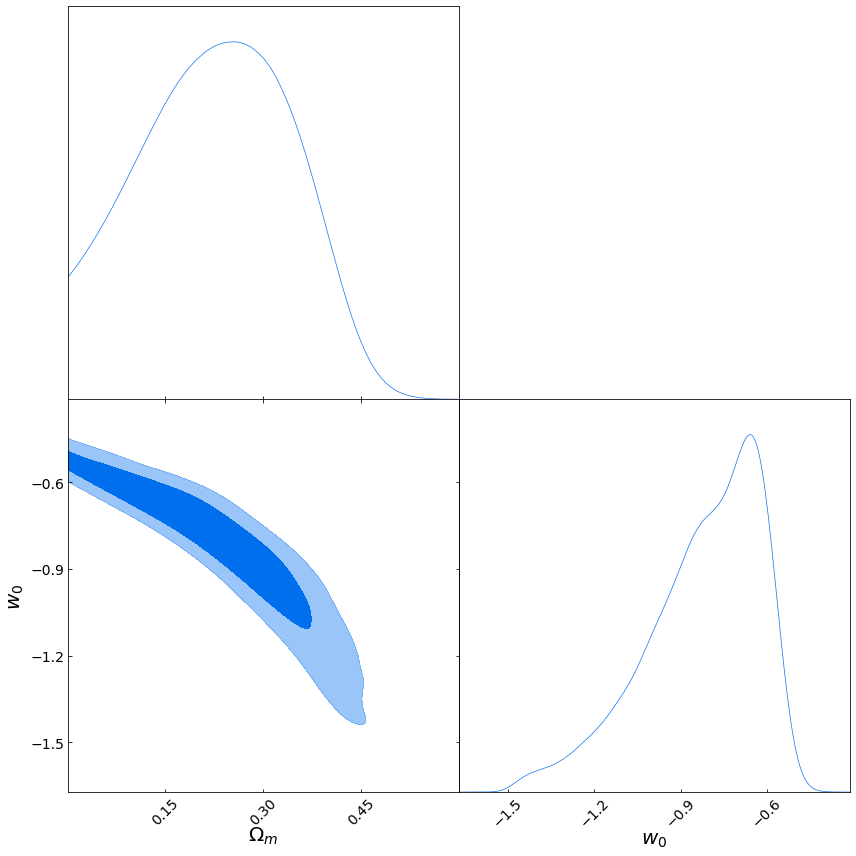

Population 26/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 2430 samples, validate on 270 samples
Epoch 1/100
2430/2430 [==============================] - 3s 1ms/step - loss: 1.3265 - val_loss: 1.3915
Epoch 2/100
2430/2430 [==============================] - 3s 1ms/step - loss: 1.3249 - val_loss: 1.3981
Epoch 3/100
2430/2430 [==============================] - 3s 1ms/step - loss: 1.3356 - val_loss: 1.4025
Epoch 4/100
2430/2430 [==============================] - 3s 1ms/step - loss: 1.3265 - val_loss: 1.3988
Epoch 5/100
2430/2430 [==============================] - 3s 1ms/step - loss: 1.3245 - val_loss: 1.4371
Epoch 6/100
2430/2430 [==============================] - 3s 1ms/step - loss: 1.3238 - val_loss: 1.3750
Epoch 7/100
2430/2430 [==============================] - 3s 1ms/step - loss: 1.3230 - val_loss: 1.3842
Epoch 8/100
2430/2430 [==============================] - 4s 1ms/step - loss: 1.3298 - val_loss: 1.3701
Epoch 9/100
2430/2430 [============================

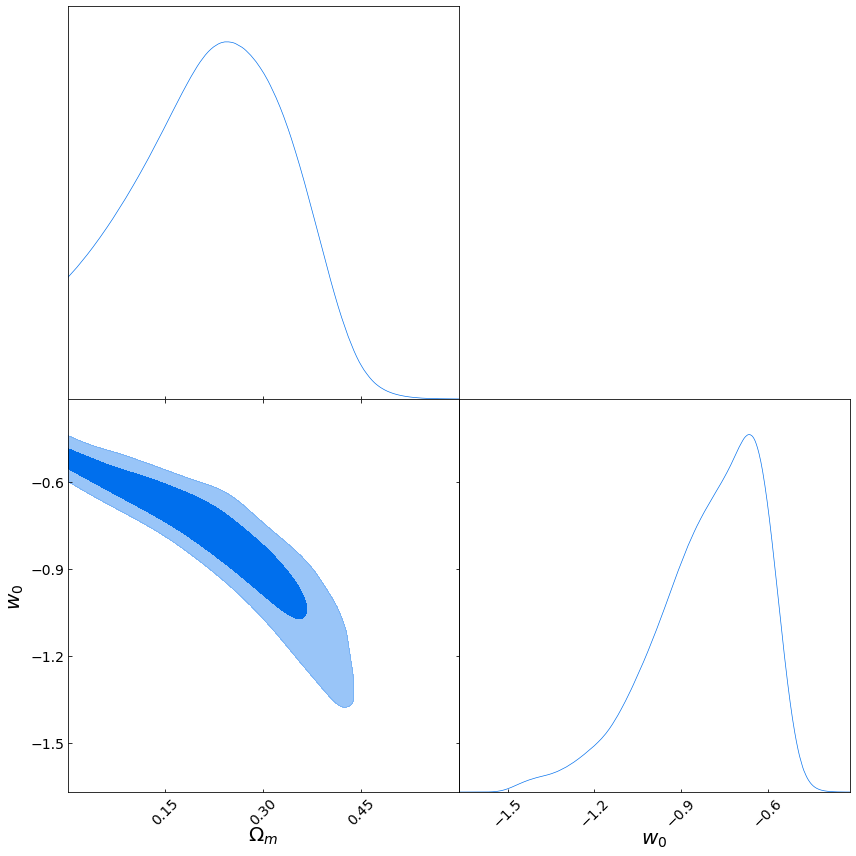

Population 27/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 2520 samples, validate on 280 samples
Epoch 1/100
2520/2520 [==============================] - 4s 1ms/step - loss: 1.3311 - val_loss: 1.3108
Epoch 2/100
2520/2520 [==============================] - 4s 1ms/step - loss: 1.3384 - val_loss: 1.3066
Epoch 3/100
2520/2520 [==============================] - 4s 1ms/step - loss: 1.3464 - val_loss: 1.3187
Epoch 4/100
2520/2520 [==============================] - 4s 2ms/step - loss: 1.3393 - val_loss: 1.3217
Epoch 5/100
2520/2520 [==============================] - 3s 1ms/step - loss: 1.3325 - val_loss: 1.3160
Epoch 6/100
2520/2520 [==============================] - 3s 1ms/step - loss: 1.3331 - val_loss: 1.3319
Epoch 7/100
2520/2520 [==============================] - 4s 1ms/step - loss: 1.3320 - val_loss: 1.3186
Train on 2520 samples, validate on 280 samples
Epoch 1/100
2520/2520 [==============================] - 4s 2ms/step - loss: 1.3462 - val_loss: 1.3212
Epoc

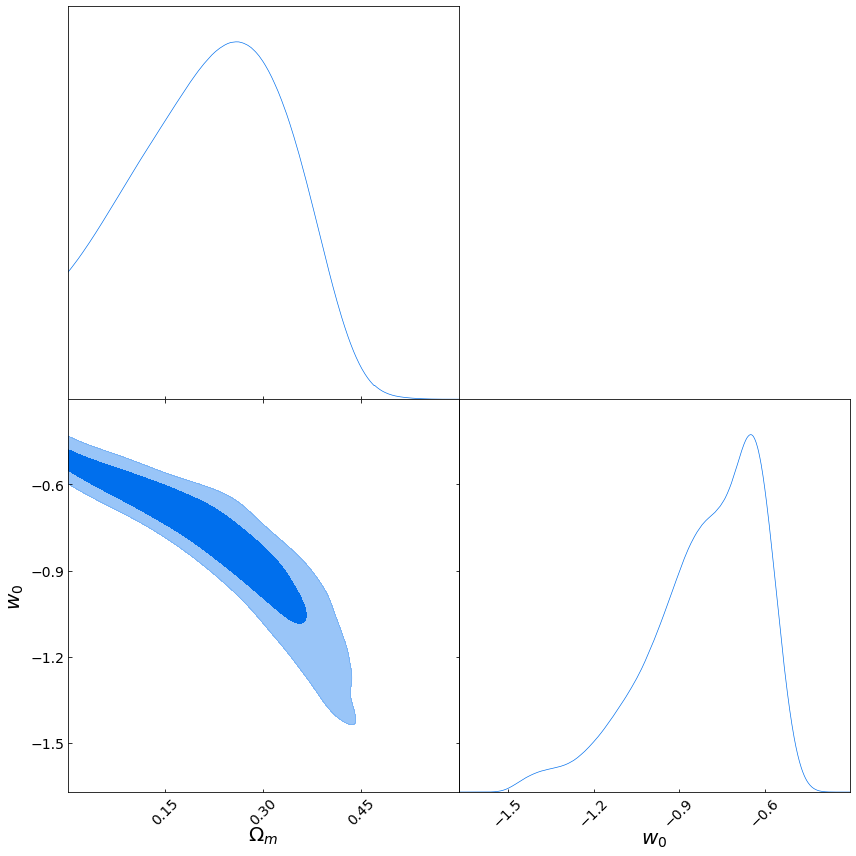

Population 28/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 2610 samples, validate on 290 samples
Epoch 1/100
2610/2610 [==============================] - 4s 1ms/step - loss: 1.3383 - val_loss: 1.3589
Epoch 2/100
2610/2610 [==============================] - 4s 1ms/step - loss: 1.3406 - val_loss: 1.3481
Epoch 3/100
2610/2610 [==============================] - 4s 1ms/step - loss: 1.3396 - val_loss: 1.3683
Epoch 4/100
2610/2610 [==============================] - 4s 1ms/step - loss: 1.3330 - val_loss: 1.3595
Epoch 5/100
2610/2610 [==============================] - 4s 1ms/step - loss: 1.3371 - val_loss: 1.3587
Epoch 6/100
2610/2610 [==============================] - 4s 1ms/step - loss: 1.3463 - val_loss: 1.3531
Epoch 7/100
2610/2610 [==============================] - 4s 1ms/step - loss: 1.3466 - val_loss: 1.3549
Train on 2610 samples, validate on 290 samples
Epoch 1/100
2610/2610 [==============================] - 4s 1ms/step - loss: 1.3403 - val_loss: 1.3532
Epoc

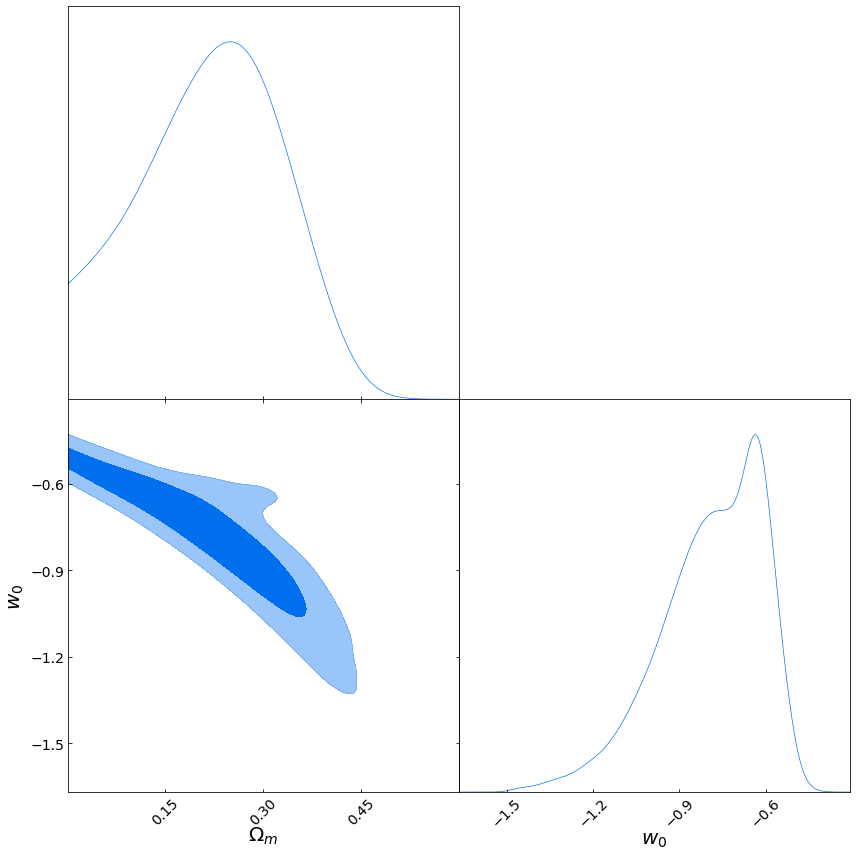

Population 29/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3330 - val_loss: 1.4019
Epoch 2/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3302 - val_loss: 1.4041
Epoch 3/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3273 - val_loss: 1.4004
Epoch 4/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3317 - val_loss: 1.3972
Epoch 5/100
2700/2700 [==============================] - 5s 2ms/step - loss: 1.3328 - val_loss: 1.4052
Epoch 6/100
2700/2700 [==============================] - 5s 2ms/step - loss: 1.3368 - val_loss: 1.4148
Epoch 7/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3393 - val_loss: 1.4003
Epoch 8/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3299 - val_loss: 1.3960
Epoch 9/100
2700/2700 [============================

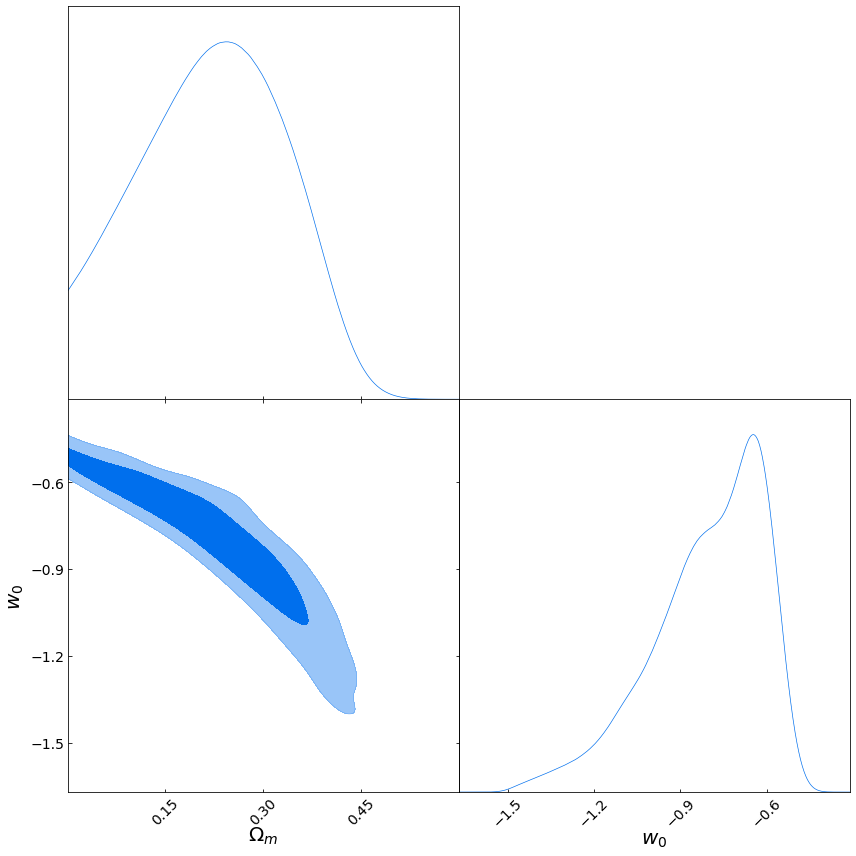

Population 30/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 2790 samples, validate on 310 samples
Epoch 1/100
2790/2790 [==============================] - 4s 1ms/step - loss: 1.3326 - val_loss: 1.3907
Epoch 2/100
2790/2790 [==============================] - 4s 1ms/step - loss: 1.3439 - val_loss: 1.3929
Epoch 3/100
2790/2790 [==============================] - 4s 1ms/step - loss: 1.3372 - val_loss: 1.4010
Epoch 4/100
2790/2790 [==============================] - 4s 1ms/step - loss: 1.3286 - val_loss: 1.3922
Epoch 5/100
2790/2790 [==============================] - 4s 1ms/step - loss: 1.3302 - val_loss: 1.3758
Epoch 6/100
2790/2790 [==============================] - 4s 1ms/step - loss: 1.3353 - val_loss: 1.3808
Epoch 7/100
2790/2790 [==============================] - 4s 1ms/step - loss: 1.3336 - val_loss: 1.3970
Epoch 8/100
2790/2790 [==============================] - 4s 1ms/step - loss: 1.3302 - val_loss: 1.4142
Epoch 9/100
2790/2790 [============================

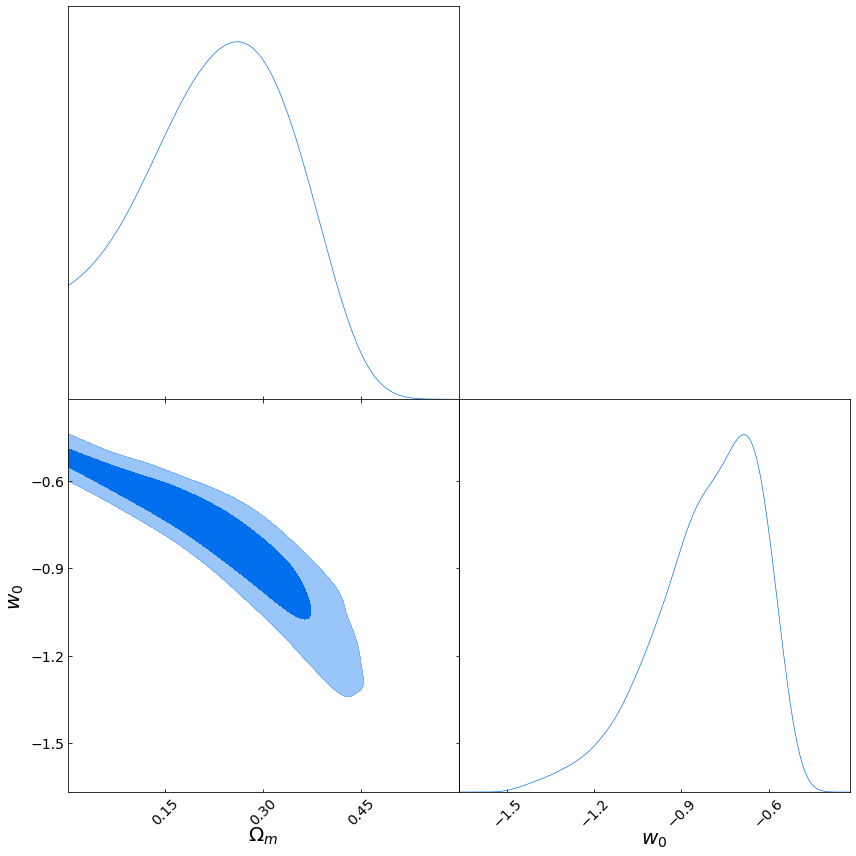

Population 31/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 2880 samples, validate on 320 samples
Epoch 1/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3320 - val_loss: 1.4106
Epoch 2/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3357 - val_loss: 1.4310
Epoch 3/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3349 - val_loss: 1.4044
Epoch 4/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3387 - val_loss: 1.4102
Epoch 5/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3304 - val_loss: 1.4094
Epoch 6/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3327 - val_loss: 1.3965
Epoch 7/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3398 - val_loss: 1.4266
Epoch 8/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3376 - val_loss: 1.4034
Epoch 9/100
2880/2880 [============================

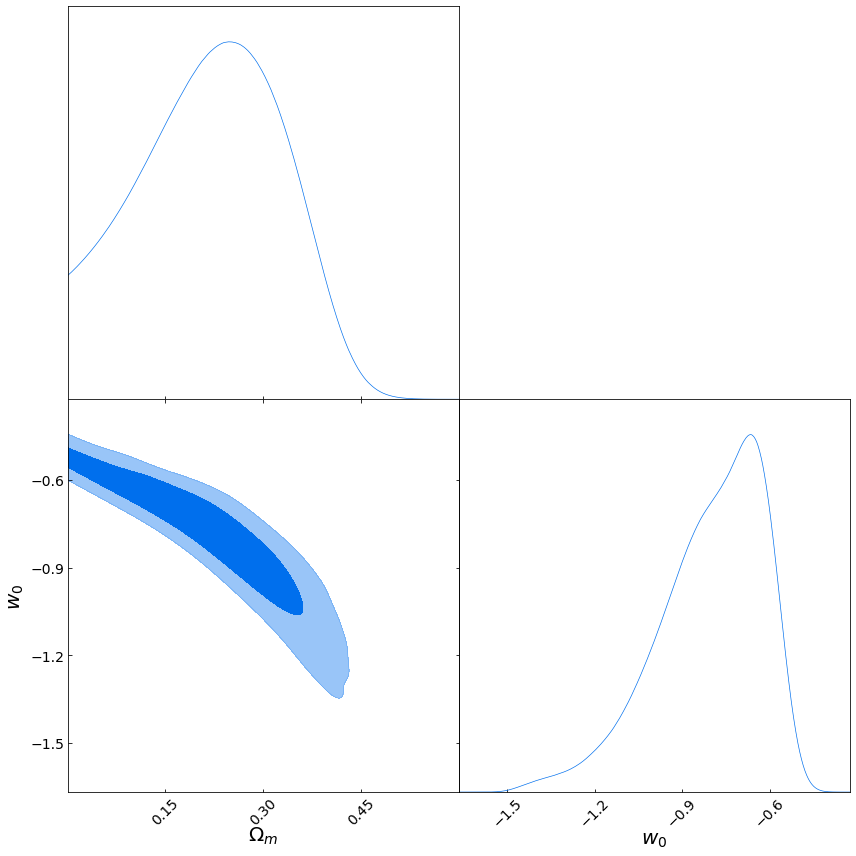

Population 32/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 2970 samples, validate on 330 samples
Epoch 1/100
2970/2970 [==============================] - 4s 1ms/step - loss: 1.3319 - val_loss: 1.4315
Epoch 2/100
2970/2970 [==============================] - 4s 1ms/step - loss: 1.3337 - val_loss: 1.4238
Epoch 3/100
2970/2970 [==============================] - 4s 1ms/step - loss: 1.3372 - val_loss: 1.4368
Epoch 4/100
2970/2970 [==============================] - 4s 1ms/step - loss: 1.3372 - val_loss: 1.4452
Epoch 5/100
2970/2970 [==============================] - 4s 1ms/step - loss: 1.3330 - val_loss: 1.4354
Epoch 6/100
2970/2970 [==============================] - 4s 1ms/step - loss: 1.3293 - val_loss: 1.4407
Epoch 7/100
2970/2970 [==============================] - 4s 1ms/step - loss: 1.3319 - val_loss: 1.4324
Train on 2970 samples, validate on 330 samples
Epoch 1/100
2970/2970 [==============================] - 4s 1ms/step - loss: 1.3297 - val_loss: 1.4326
Epoc

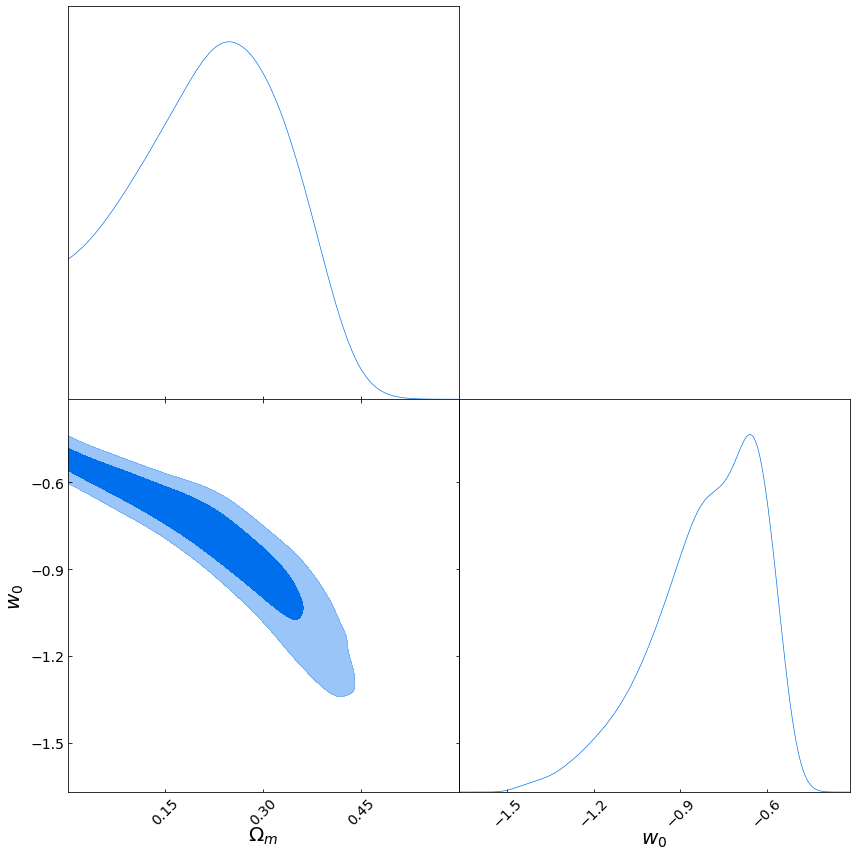

Population 33/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 3060 samples, validate on 340 samples
Epoch 1/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3400 - val_loss: 1.4433
Epoch 2/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3433 - val_loss: 1.4269
Epoch 3/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3386 - val_loss: 1.4393
Epoch 4/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3389 - val_loss: 1.4227
Epoch 5/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3348 - val_loss: 1.4394
Epoch 6/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3370 - val_loss: 1.4227
Epoch 7/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3372 - val_loss: 1.4462
Epoch 8/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3384 - val_loss: 1.4318
Epoch 9/100
3060/3060 [============================

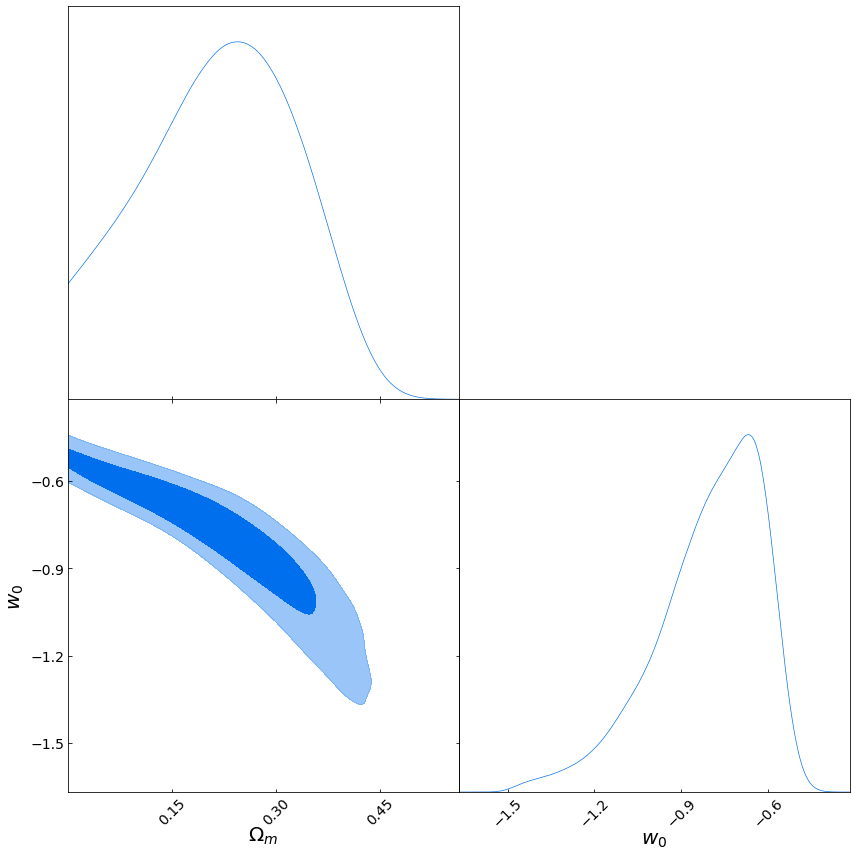

Population 34/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 3150 samples, validate on 350 samples
Epoch 1/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.3305 - val_loss: 1.4390
Epoch 2/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.3349 - val_loss: 1.4491
Epoch 3/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.3375 - val_loss: 1.4316
Epoch 4/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.3418 - val_loss: 1.4452
Epoch 5/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.3348 - val_loss: 1.4390
Epoch 6/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.3357 - val_loss: 1.4491
Epoch 7/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.3397 - val_loss: 1.4471
Epoch 8/100
3150/3150 [==============================] - 4s 1ms/step - loss: 1.3378 - val_loss: 1.4488
Train on 3150 samples, validate on 350 samples
Epoc

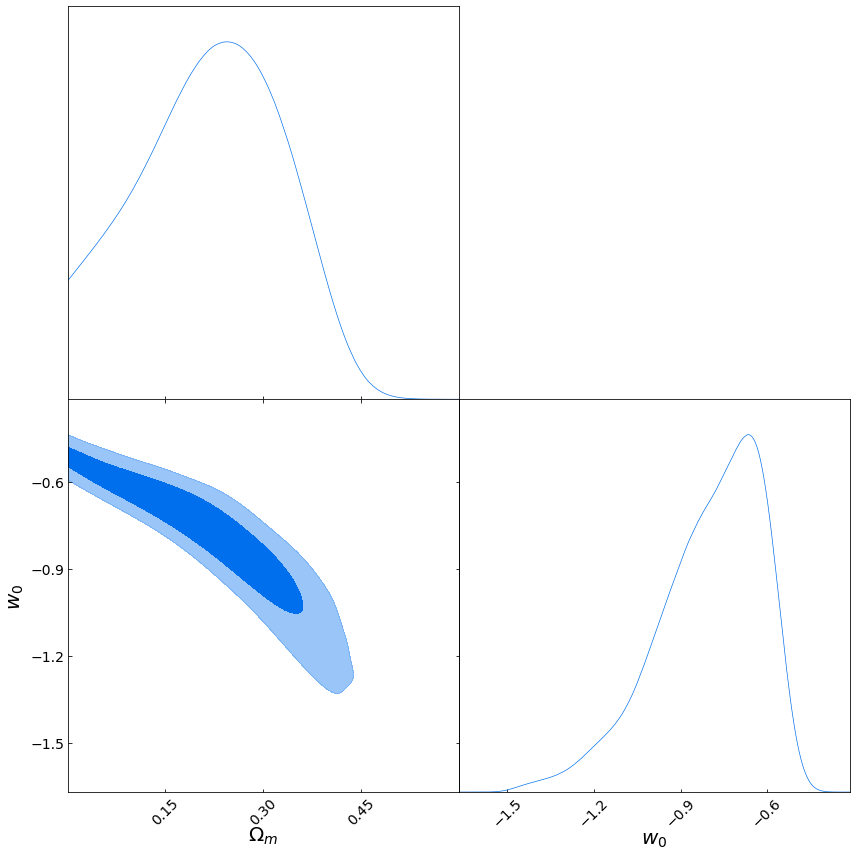

Population 35/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 3240 samples, validate on 360 samples
Epoch 1/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3427 - val_loss: 1.4511
Epoch 2/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3405 - val_loss: 1.4337
Epoch 3/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3413 - val_loss: 1.4280
Epoch 4/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3389 - val_loss: 1.4403
Epoch 5/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3612 - val_loss: 1.4266
Epoch 6/100
3240/3240 [==============================] - 4s 1ms/step - loss: 1.3370 - val_loss: 1.4402
Epoch 7/100
3240/3240 [==============================] - 4s 1ms/step - loss: 1.3410 - val_loss: 1.4560
Epoch 8/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3391 - val_loss: 1.4352
Epoch 9/100
3240/3240 [============================

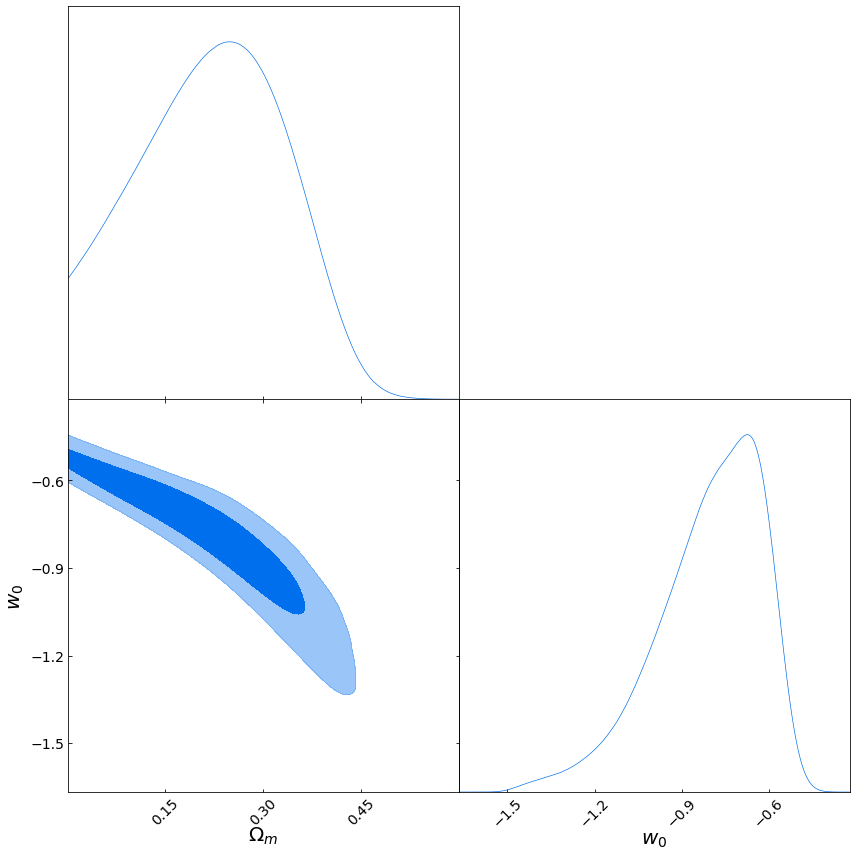

Population 36/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 3330 samples, validate on 370 samples
Epoch 1/100
3330/3330 [==============================] - 6s 2ms/step - loss: 1.3497 - val_loss: 1.4456
Epoch 2/100
3330/3330 [==============================] - 7s 2ms/step - loss: 1.3478 - val_loss: 1.4418
Epoch 3/100
3330/3330 [==============================] - 5s 2ms/step - loss: 1.3415 - val_loss: 1.4517
Epoch 4/100
3330/3330 [==============================] - 5s 1ms/step - loss: 1.3451 - val_loss: 1.4527
Epoch 5/100
3330/3330 [==============================] - 5s 1ms/step - loss: 1.3491 - val_loss: 1.4392
Epoch 6/100
3330/3330 [==============================] - 6s 2ms/step - loss: 1.3409 - val_loss: 1.4981
Epoch 7/100
3330/3330 [==============================] - 5s 2ms/step - loss: 1.3466 - val_loss: 1.4740
Epoch 8/100
3330/3330 [==============================] - 5s 2ms/step - loss: 1.3409 - val_loss: 1.4533
Epoch 9/100
3330/3330 [============================

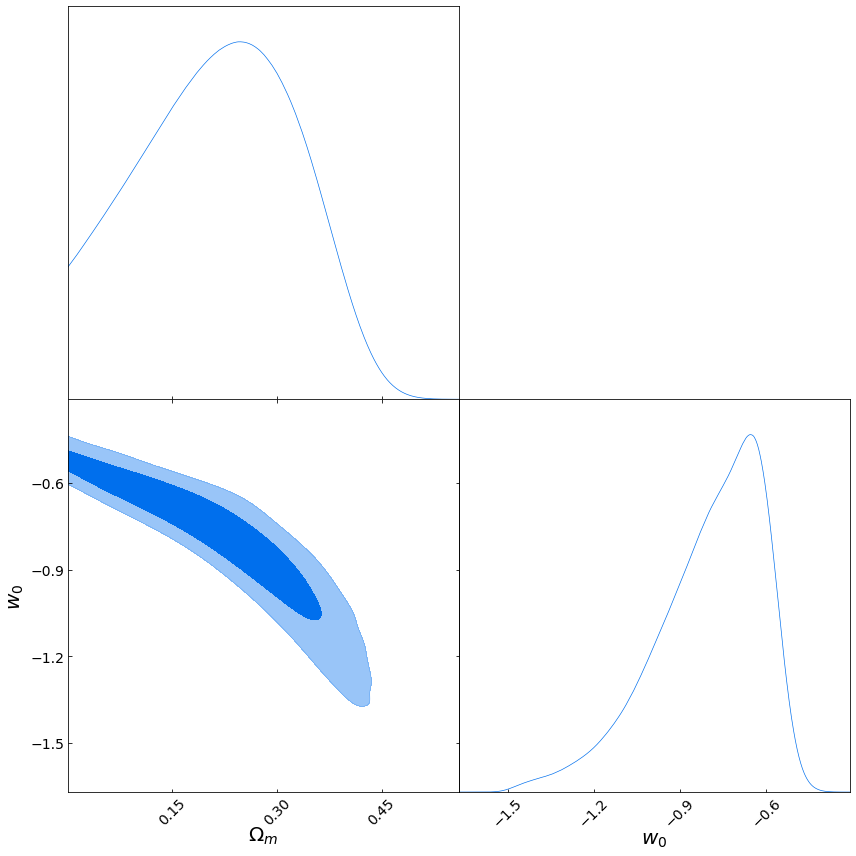

Population 37/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 3420 samples, validate on 380 samples
Epoch 1/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3410 - val_loss: 1.4461
Epoch 2/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3480 - val_loss: 1.4514
Epoch 3/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3389 - val_loss: 1.4563
Epoch 4/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3441 - val_loss: 1.4327
Epoch 5/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3447 - val_loss: 1.4507
Epoch 6/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3491 - val_loss: 1.4579
Epoch 7/100
3420/3420 [==============================] - 6s 2ms/step - loss: 1.3413 - val_loss: 1.4577
Epoch 8/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3474 - val_loss: 1.4983
Epoch 9/100
3420/3420 [============================

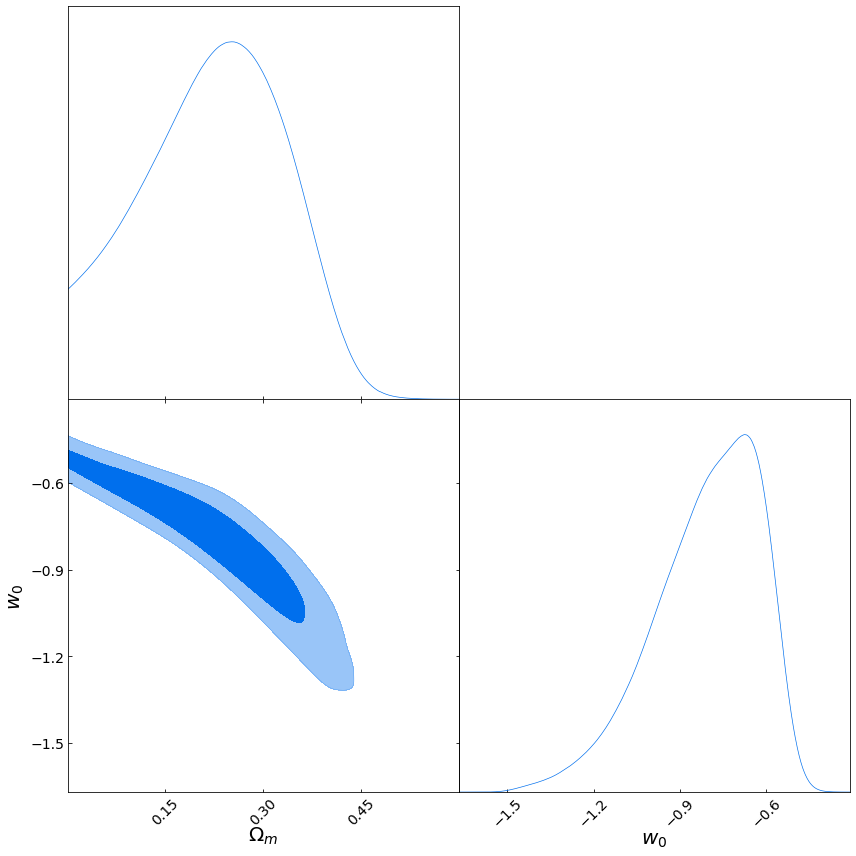

Population 38/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 3510 samples, validate on 390 samples
Epoch 1/100
3510/3510 [==============================] - 5s 2ms/step - loss: 1.3433 - val_loss: 1.4666
Epoch 2/100
3510/3510 [==============================] - 5s 1ms/step - loss: 1.3479 - val_loss: 1.4427
Epoch 3/100
3510/3510 [==============================] - 5s 1ms/step - loss: 1.3448 - val_loss: 1.4438
Epoch 4/100
3510/3510 [==============================] - 5s 1ms/step - loss: 1.3416 - val_loss: 1.4562
Epoch 5/100
3510/3510 [==============================] - 5s 1ms/step - loss: 1.3546 - val_loss: 1.4441
Epoch 6/100
3510/3510 [==============================] - 5s 1ms/step - loss: 1.3480 - val_loss: 1.4438
Epoch 7/100
3510/3510 [==============================] - 5s 1ms/step - loss: 1.3457 - val_loss: 1.4405
Epoch 8/100
3510/3510 [==============================] - 5s 1ms/step - loss: 1.3586 - val_loss: 1.4752
Epoch 9/100
3510/3510 [============================

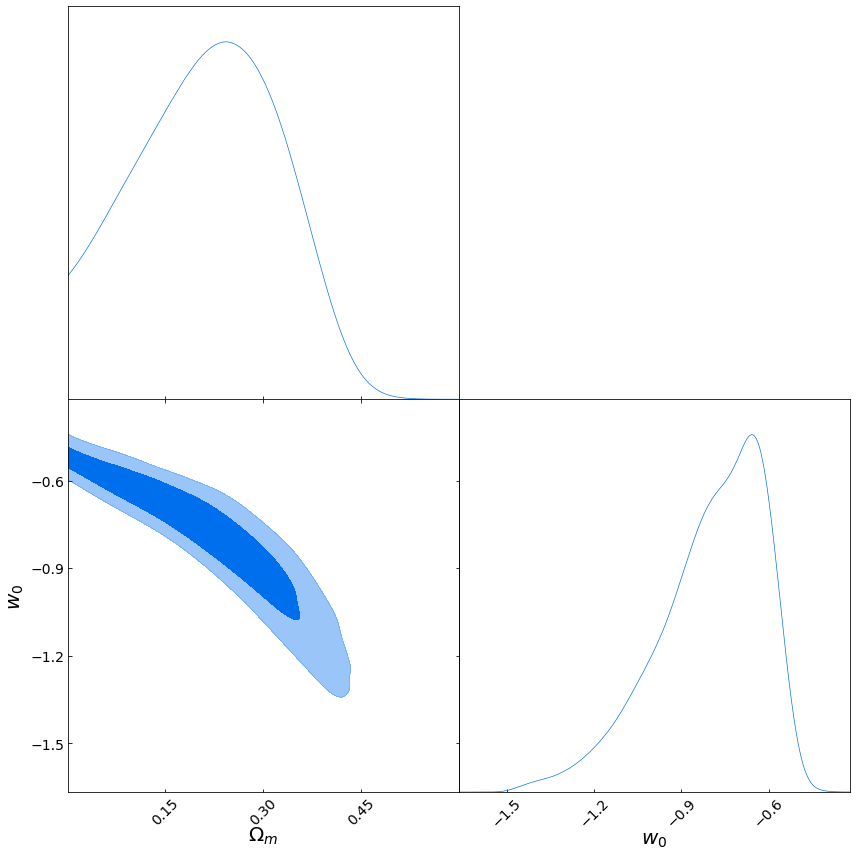

Population 39/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3493 - val_loss: 1.4695
Epoch 2/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3452 - val_loss: 1.4681
Epoch 3/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3466 - val_loss: 1.4691
Epoch 4/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3430 - val_loss: 1.5057
Epoch 5/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3464 - val_loss: 1.4635
Epoch 6/100
3600/3600 [==============================] - 6s 2ms/step - loss: 1.3525 - val_loss: 1.4758
Epoch 7/100
3600/3600 [==============================] - 5s 2ms/step - loss: 1.3511 - val_loss: 1.4877
Epoch 8/100
3600/3600 [==============================] - 6s 2ms/step - loss: 1.3580 - val_loss: 1.4745
Epoch 9/100
3600/3600 [============================

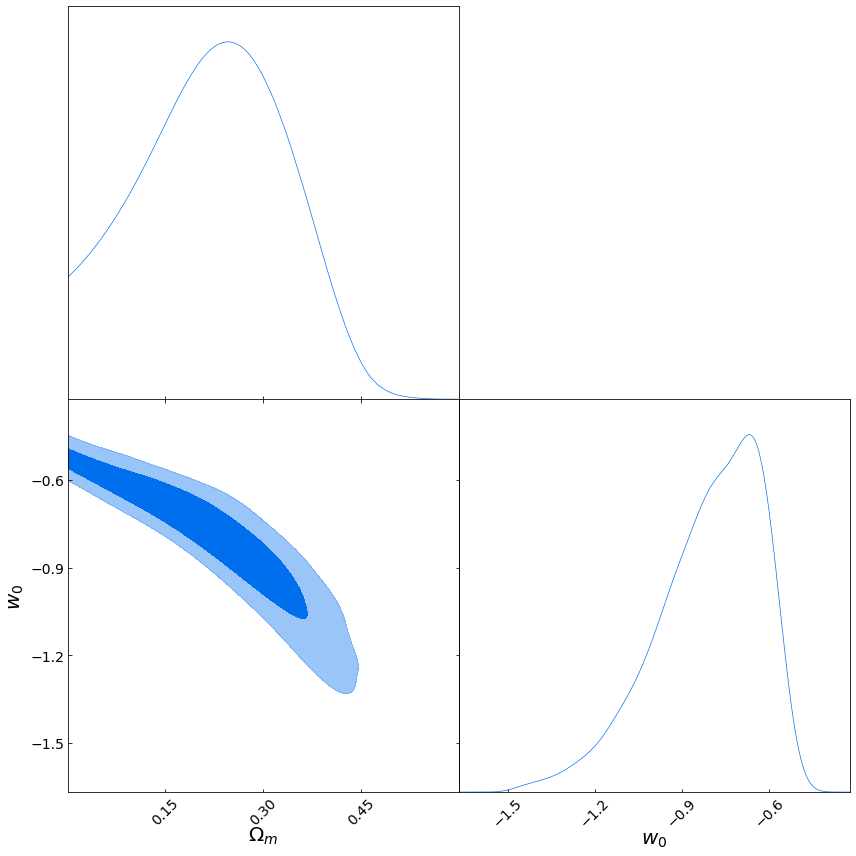

Population 40/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 3690 samples, validate on 410 samples
Epoch 1/100
3690/3690 [==============================] - 5s 1ms/step - loss: 1.3450 - val_loss: 1.4525
Epoch 2/100
3690/3690 [==============================] - 5s 1ms/step - loss: 1.3501 - val_loss: 1.4633
Epoch 3/100
3690/3690 [==============================] - 5s 1ms/step - loss: 1.3452 - val_loss: 1.4645
Epoch 4/100
3690/3690 [==============================] - 5s 1ms/step - loss: 1.3487 - val_loss: 1.4570
Epoch 5/100
3690/3690 [==============================] - 5s 1ms/step - loss: 1.3450 - val_loss: 1.4557
Epoch 6/100
3690/3690 [==============================] - 5s 1ms/step - loss: 1.3511 - val_loss: 1.4806
Train on 3690 samples, validate on 410 samples
Epoch 1/100
3690/3690 [==============================] - 5s 1ms/step - loss: 1.3461 - val_loss: 1.4822
Epoch 2/100
3690/3690 [==============================] - 5s 1ms/step - loss: 1.3467 - val_loss: 1.4783
Epoc

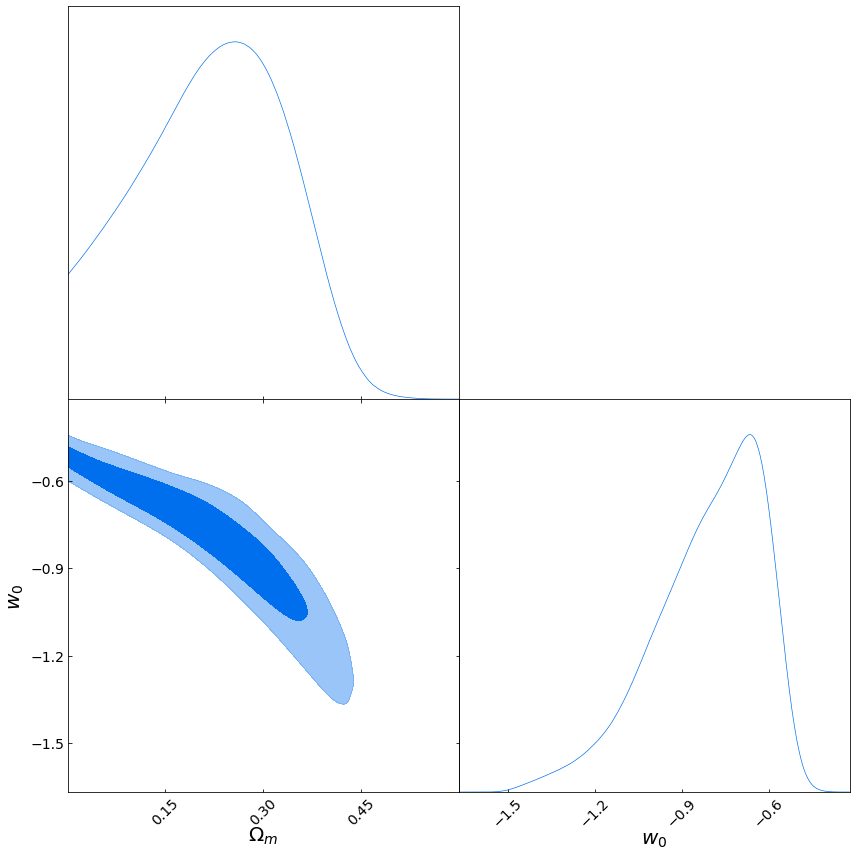

Population 41/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 3780 samples, validate on 420 samples
Epoch 1/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3500 - val_loss: 1.3620
Epoch 2/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3532 - val_loss: 1.3699
Epoch 3/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3490 - val_loss: 1.3787
Epoch 4/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3539 - val_loss: 1.3716
Epoch 5/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3510 - val_loss: 1.3839
Epoch 6/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3555 - val_loss: 1.3866
Train on 3780 samples, validate on 420 samples
Epoch 1/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3511 - val_loss: 1.3780
Epoch 2/100
3780/3780 [==============================] - 6s 1ms/step - loss: 1.3499 - val_loss: 1.3742
Epoc

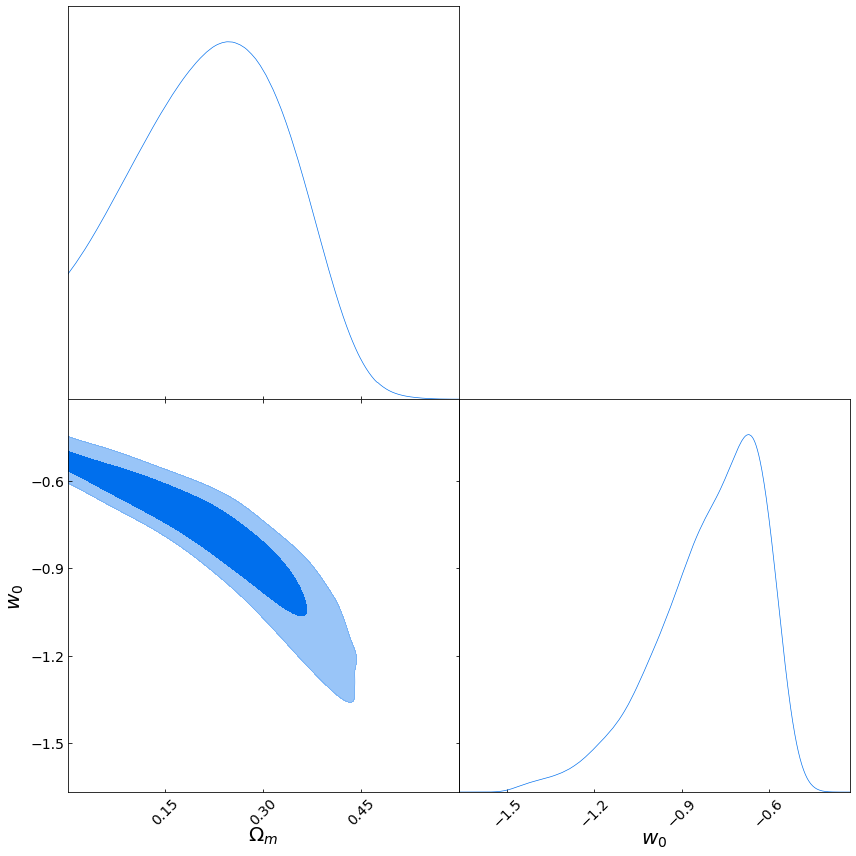

Population 42/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 3870 samples, validate on 430 samples
Epoch 1/100
3870/3870 [==============================] - 5s 1ms/step - loss: 1.3597 - val_loss: 1.3609
Epoch 2/100
3870/3870 [==============================] - 5s 1ms/step - loss: 1.3564 - val_loss: 1.3608
Epoch 3/100
3870/3870 [==============================] - 5s 1ms/step - loss: 1.3567 - val_loss: 1.3530
Epoch 4/100
3870/3870 [==============================] - 5s 1ms/step - loss: 1.3526 - val_loss: 1.3771
Epoch 5/100
3870/3870 [==============================] - 5s 1ms/step - loss: 1.3623 - val_loss: 1.3680
Epoch 6/100
3870/3870 [==============================] - 5s 1ms/step - loss: 1.3519 - val_loss: 1.3690
Epoch 7/100
3870/3870 [==============================] - 5s 1ms/step - loss: 1.3521 - val_loss: 1.3907
Epoch 8/100
3870/3870 [==============================] - 5s 1ms/step - loss: 1.3545 - val_loss: 1.3657
Train on 3870 samples, validate on 430 samples
Epoc

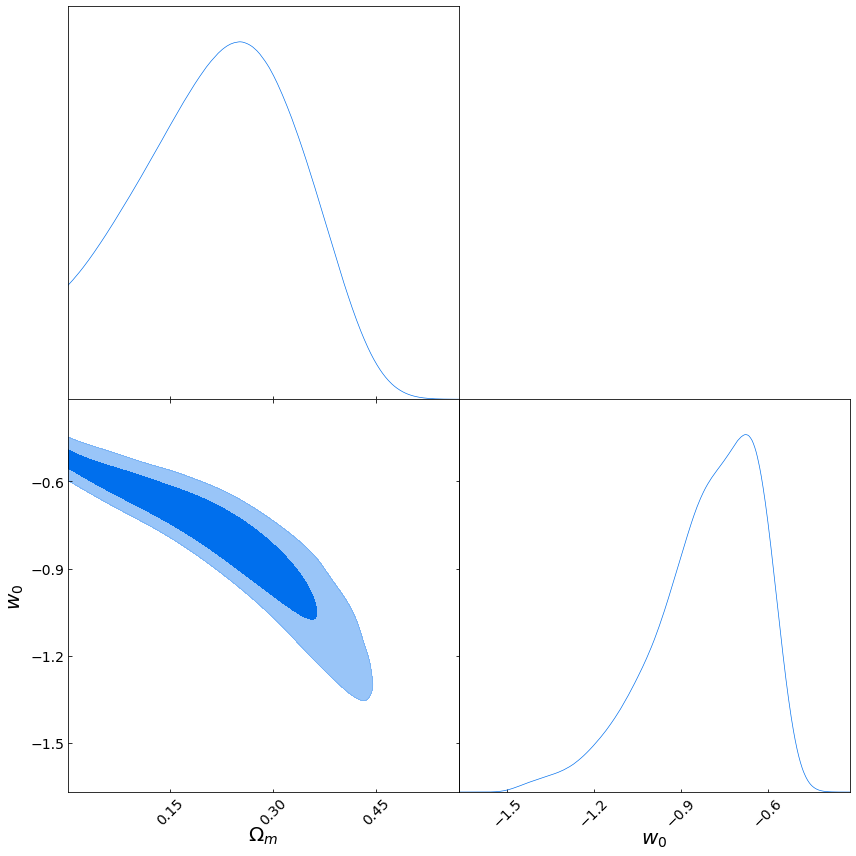

Population 43/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 3960 samples, validate on 440 samples
Epoch 1/100
3960/3960 [==============================] - 6s 2ms/step - loss: 1.3569 - val_loss: 1.3164
Epoch 2/100
3960/3960 [==============================] - 6s 2ms/step - loss: 1.3583 - val_loss: 1.3455
Epoch 3/100
3960/3960 [==============================] - 6s 2ms/step - loss: 1.3589 - val_loss: 1.3170
Epoch 4/100
3960/3960 [==============================] - 6s 2ms/step - loss: 1.3615 - val_loss: 1.3486
Epoch 5/100
3960/3960 [==============================] - 7s 2ms/step - loss: 1.3708 - val_loss: 1.3145
Epoch 6/100
3960/3960 [==============================] - 7s 2ms/step - loss: 1.3632 - val_loss: 1.3286
Epoch 7/100
3960/3960 [==============================] - 6s 2ms/step - loss: 1.3595 - val_loss: 1.3331
Epoch 8/100
3960/3960 [==============================] - 6s 2ms/step - loss: 1.3615 - val_loss: 1.3309
Epoch 9/100
3960/3960 [============================

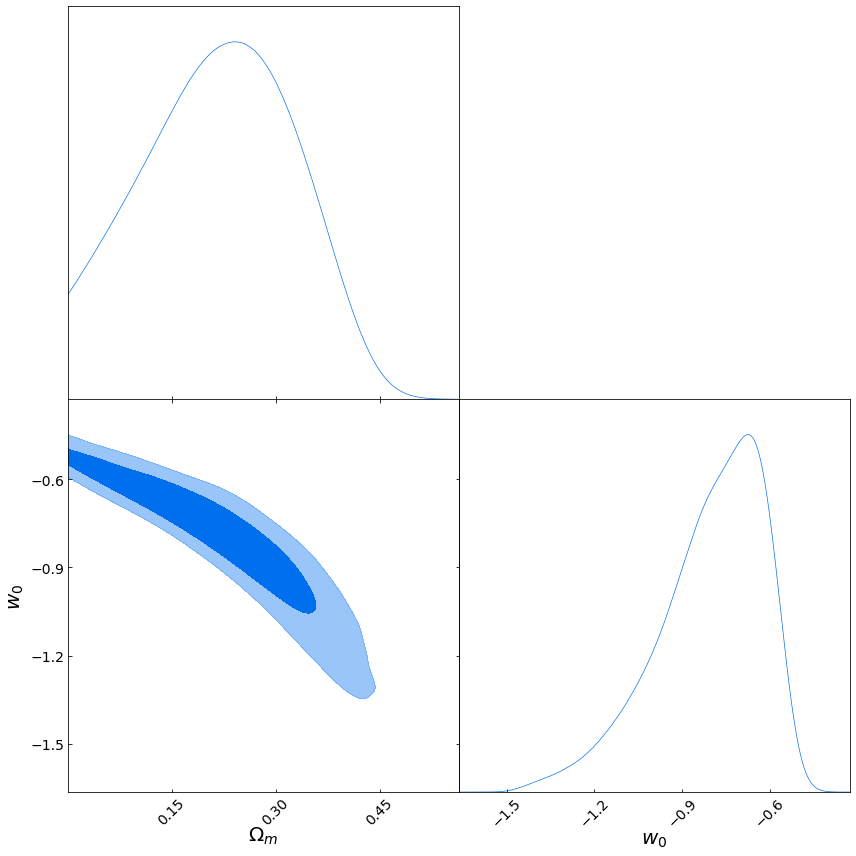

Population 44/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 4050 samples, validate on 450 samples
Epoch 1/100
4050/4050 [==============================] - 5s 1ms/step - loss: 1.3547 - val_loss: 1.3541
Epoch 2/100
4050/4050 [==============================] - 5s 1ms/step - loss: 1.3575 - val_loss: 1.3488
Epoch 3/100
4050/4050 [==============================] - 5s 1ms/step - loss: 1.3566 - val_loss: 1.3752
Epoch 4/100
4050/4050 [==============================] - 5s 1ms/step - loss: 1.3571 - val_loss: 1.3451
Epoch 5/100
4050/4050 [==============================] - 5s 1ms/step - loss: 1.3607 - val_loss: 1.3498
Epoch 6/100
4050/4050 [==============================] - 5s 1ms/step - loss: 1.3570 - val_loss: 1.3426
Epoch 7/100
4050/4050 [==============================] - 6s 2ms/step - loss: 1.3629 - val_loss: 1.3930
Epoch 8/100
4050/4050 [==============================] - 6s 2ms/step - loss: 1.3645 - val_loss: 1.3535
Epoch 9/100
4050/4050 [============================

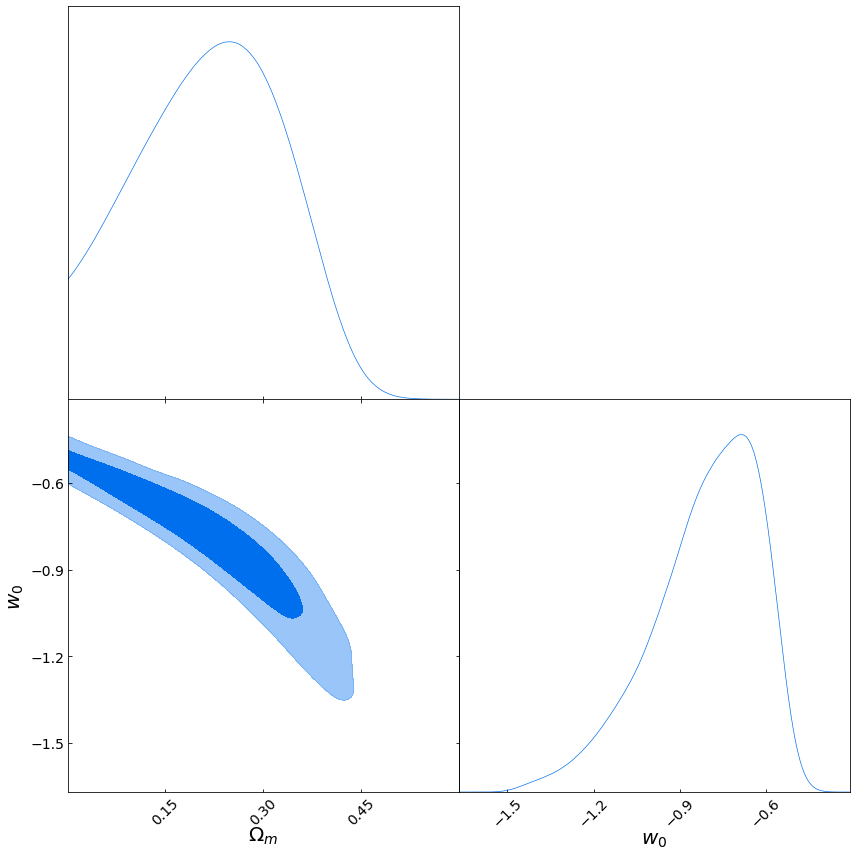

Population 45/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 4140 samples, validate on 460 samples
Epoch 1/100
4140/4140 [==============================] - 6s 1ms/step - loss: 1.3569 - val_loss: 1.3570
Epoch 2/100
4140/4140 [==============================] - 6s 1ms/step - loss: 1.3526 - val_loss: 1.3529
Epoch 3/100
4140/4140 [==============================] - 7s 2ms/step - loss: 1.3574 - val_loss: 1.3463
Epoch 4/100
4140/4140 [==============================] - 7s 2ms/step - loss: 1.3527 - val_loss: 1.3571
Epoch 5/100
4140/4140 [==============================] - 7s 2ms/step - loss: 1.3566 - val_loss: 1.3540
Epoch 6/100
4140/4140 [==============================] - 7s 2ms/step - loss: 1.3576 - val_loss: 1.3461
Epoch 7/100
4140/4140 [==============================] - 7s 2ms/step - loss: 1.3598 - val_loss: 1.3519
Epoch 8/100
4140/4140 [==============================] - 7s 2ms/step - loss: 1.3574 - val_loss: 1.3558
Epoch 9/100
4140/4140 [============================

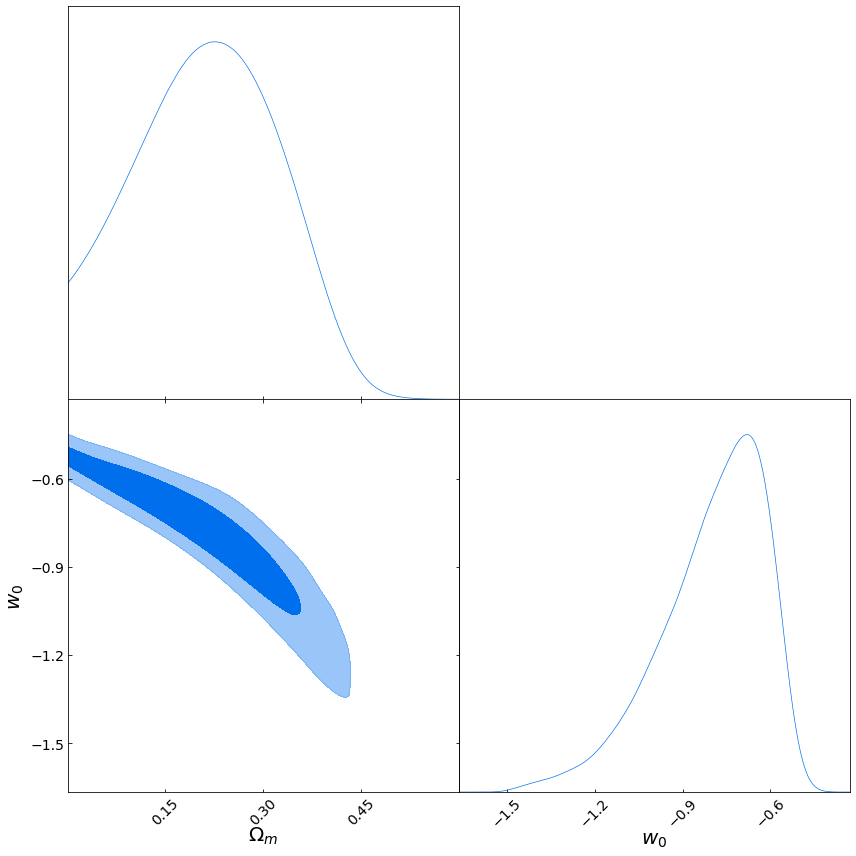

Population 46/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 4230 samples, validate on 470 samples
Epoch 1/100
4230/4230 [==============================] - 6s 1ms/step - loss: 1.3521 - val_loss: 1.3783
Epoch 2/100
4230/4230 [==============================] - 6s 1ms/step - loss: 1.3565 - val_loss: 1.3824
Epoch 3/100
4230/4230 [==============================] - 6s 1ms/step - loss: 1.3566 - val_loss: 1.3642
Epoch 4/100
4230/4230 [==============================] - 6s 1ms/step - loss: 1.3511 - val_loss: 1.3863
Epoch 5/100
4230/4230 [==============================] - 6s 1ms/step - loss: 1.3538 - val_loss: 1.3674
Epoch 6/100
4230/4230 [==============================] - 7s 2ms/step - loss: 1.3560 - val_loss: 1.3794
Epoch 7/100
4230/4230 [==============================] - 6s 1ms/step - loss: 1.3518 - val_loss: 1.3691
Epoch 8/100
4230/4230 [==============================] - 6s 1ms/step - loss: 1.3530 - val_loss: 1.3710
Train on 4230 samples, validate on 470 samples
Epoc

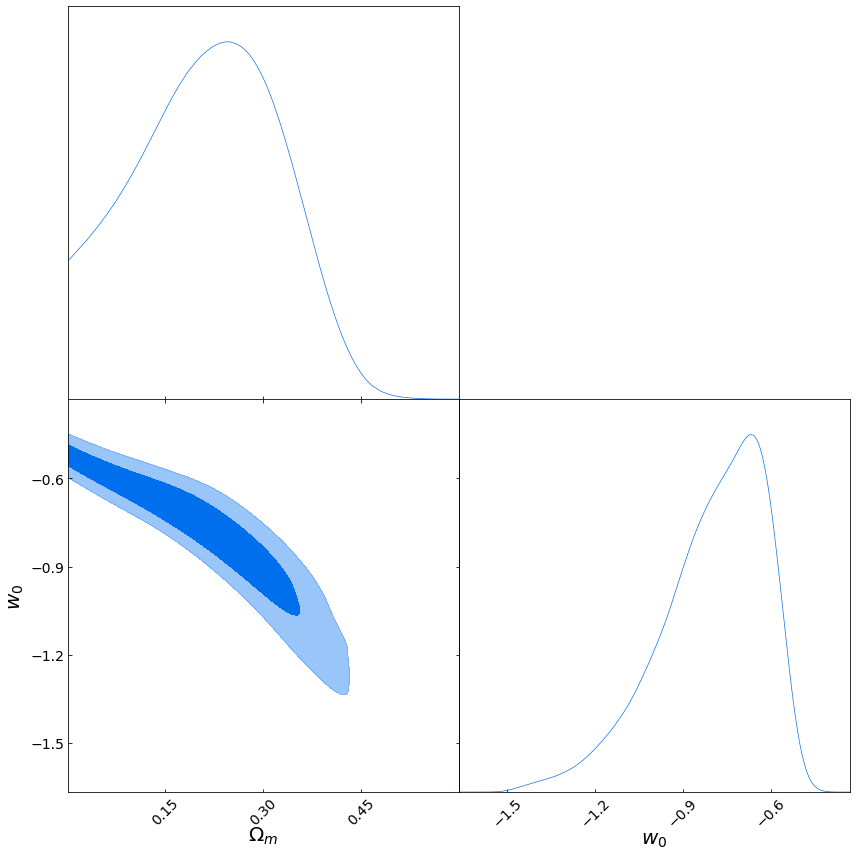

Population 47/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 4320 samples, validate on 480 samples
Epoch 1/100
4320/4320 [==============================] - 7s 2ms/step - loss: 1.3526 - val_loss: 1.3820
Epoch 2/100
4320/4320 [==============================] - 7s 2ms/step - loss: 1.3590 - val_loss: 1.3681
Epoch 3/100
4320/4320 [==============================] - 7s 2ms/step - loss: 1.3570 - val_loss: 1.3663
Epoch 4/100
4320/4320 [==============================] - 7s 2ms/step - loss: 1.3576 - val_loss: 1.3790
Epoch 5/100
4320/4320 [==============================] - 6s 1ms/step - loss: 1.3532 - val_loss: 1.3712
Epoch 6/100
4320/4320 [==============================] - 6s 1ms/step - loss: 1.3549 - val_loss: 1.3633
Epoch 7/100
4320/4320 [==============================] - 6s 1ms/step - loss: 1.3530 - val_loss: 1.3648
Epoch 8/100
4320/4320 [==============================] - 7s 2ms/step - loss: 1.3584 - val_loss: 1.3847
Epoch 9/100
4320/4320 [============================

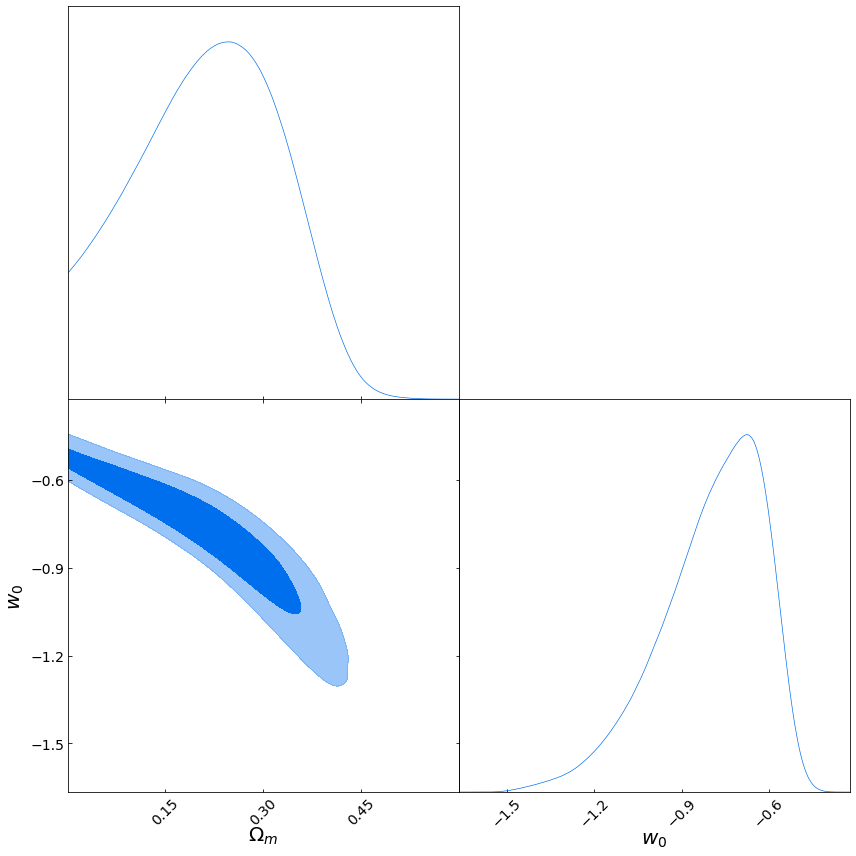

Population 48/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 4410 samples, validate on 490 samples
Epoch 1/100
4410/4410 [==============================] - 6s 1ms/step - loss: 1.3600 - val_loss: 1.3833
Epoch 2/100
4410/4410 [==============================] - 6s 1ms/step - loss: 1.3559 - val_loss: 1.3865
Epoch 3/100
4410/4410 [==============================] - 6s 1ms/step - loss: 1.3575 - val_loss: 1.3622
Epoch 4/100
4410/4410 [==============================] - 6s 1ms/step - loss: 1.3618 - val_loss: 1.3774
Epoch 5/100
4410/4410 [==============================] - 6s 1ms/step - loss: 1.3499 - val_loss: 1.3743
Epoch 6/100
4410/4410 [==============================] - 7s 1ms/step - loss: 1.3560 - val_loss: 1.3700
Epoch 7/100
4410/4410 [==============================] - 6s 1ms/step - loss: 1.3535 - val_loss: 1.3759
Epoch 8/100
4410/4410 [==============================] - 6s 1ms/step - loss: 1.3527 - val_loss: 1.3674
Train on 4410 samples, validate on 490 samples
Epoc

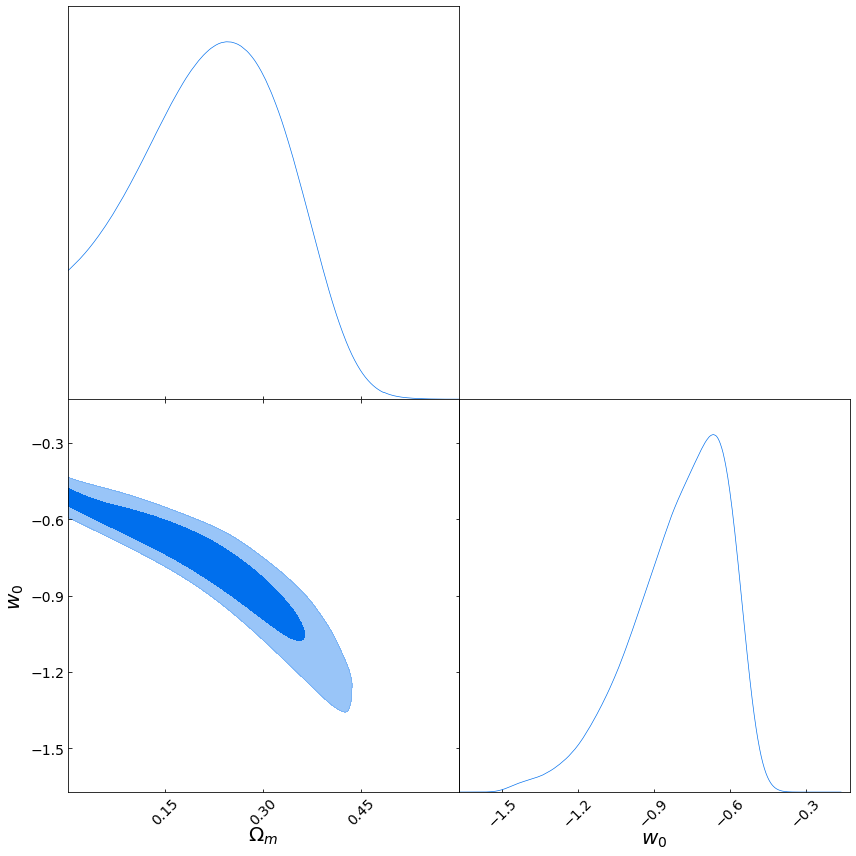

Population 49/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 7s 1ms/step - loss: 1.3565 - val_loss: 1.3719
Epoch 2/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3533 - val_loss: 1.3803
Epoch 3/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3528 - val_loss: 1.3743
Epoch 4/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3574 - val_loss: 1.3799
Epoch 5/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3557 - val_loss: 1.3675
Epoch 6/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3667 - val_loss: 1.3712
Epoch 7/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3584 - val_loss: 1.3726
Epoch 8/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3527 - val_loss: 1.3846
Epoch 9/100
4500/4500 [============================

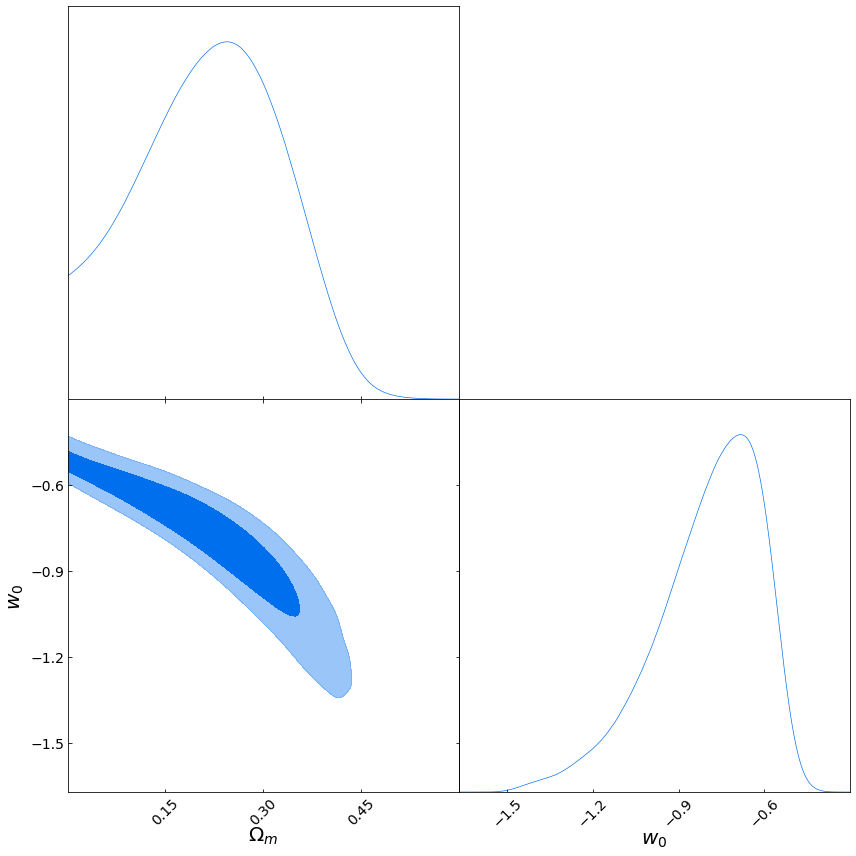

Population 50/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 4590 samples, validate on 510 samples
Epoch 1/100
4590/4590 [==============================] - 6s 1ms/step - loss: 1.3500 - val_loss: 1.3989
Epoch 2/100
4590/4590 [==============================] - 6s 1ms/step - loss: 1.3566 - val_loss: 1.4170
Epoch 3/100
4590/4590 [==============================] - 6s 1ms/step - loss: 1.3539 - val_loss: 1.4112
Epoch 4/100
4590/4590 [==============================] - 6s 1ms/step - loss: 1.3559 - val_loss: 1.4161
Epoch 5/100
4590/4590 [==============================] - 6s 1ms/step - loss: 1.3516 - val_loss: 1.4018
Epoch 6/100
4590/4590 [==============================] - 6s 1ms/step - loss: 1.3516 - val_loss: 1.4029
Train on 4590 samples, validate on 510 samples
Epoch 1/100
4590/4590 [==============================] - 7s 2ms/step - loss: 1.3495 - val_loss: 1.4067
Epoch 2/100
4590/4590 [==============================] - 7s 2ms/step - loss: 1.3520 - val_loss: 1.4095
Epoc

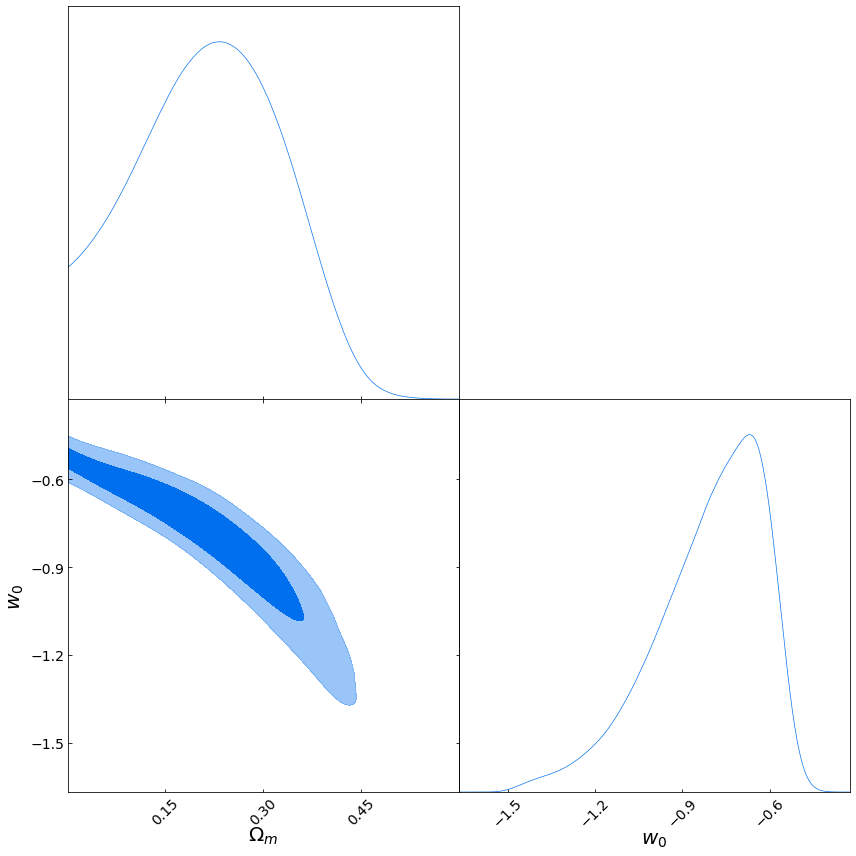

Population 51/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 4680 samples, validate on 520 samples
Epoch 1/100
4680/4680 [==============================] - 8s 2ms/step - loss: 1.3523 - val_loss: 1.3985
Epoch 2/100
4680/4680 [==============================] - 8s 2ms/step - loss: 1.3588 - val_loss: 1.4296
Epoch 3/100
4680/4680 [==============================] - 8s 2ms/step - loss: 1.3606 - val_loss: 1.4011
Epoch 4/100
4680/4680 [==============================] - 8s 2ms/step - loss: 1.3527 - val_loss: 1.3947
Epoch 5/100
4680/4680 [==============================] - 8s 2ms/step - loss: 1.3500 - val_loss: 1.4049
Epoch 6/100
4680/4680 [==============================] - 8s 2ms/step - loss: 1.3518 - val_loss: 1.4021
Epoch 7/100
4680/4680 [==============================] - 8s 2ms/step - loss: 1.3527 - val_loss: 1.3931
Epoch 8/100
4680/4680 [==============================] - 8s 2ms/step - loss: 1.3558 - val_loss: 1.3940
Epoch 9/100
4680/4680 [============================

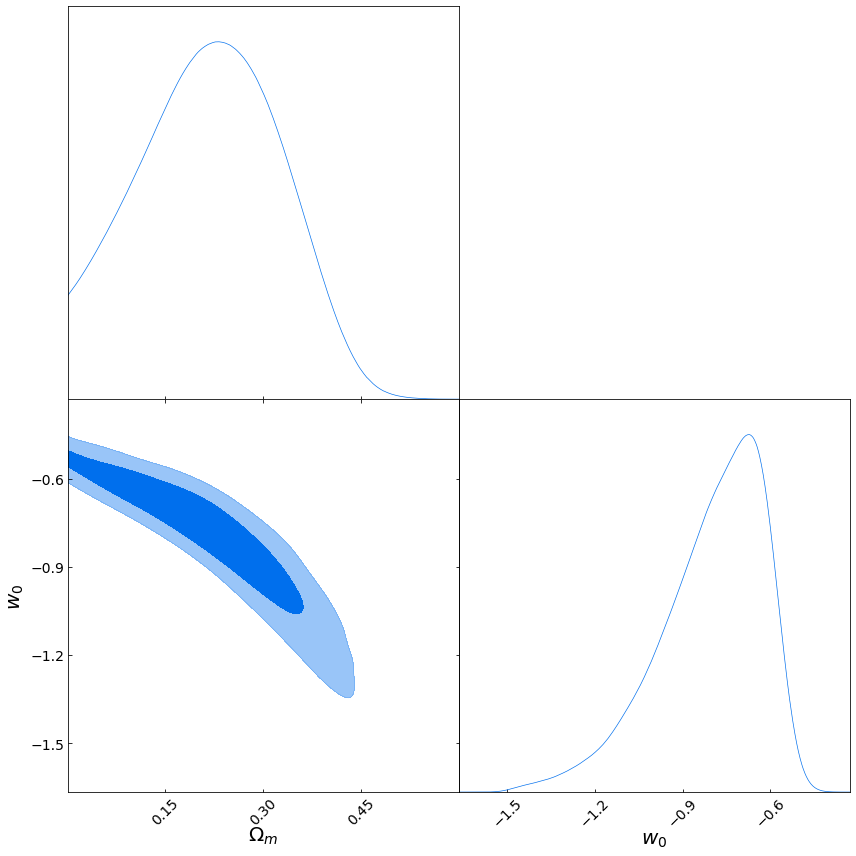

Population 52/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 4770 samples, validate on 530 samples
Epoch 1/100
4770/4770 [==============================] - 7s 1ms/step - loss: 1.3520 - val_loss: 1.4342
Epoch 2/100
4770/4770 [==============================] - 7s 1ms/step - loss: 1.3523 - val_loss: 1.4450
Epoch 3/100
4770/4770 [==============================] - 7s 1ms/step - loss: 1.3576 - val_loss: 1.4370
Epoch 4/100
4770/4770 [==============================] - 7s 1ms/step - loss: 1.3527 - val_loss: 1.4372
Epoch 5/100
4770/4770 [==============================] - 7s 1ms/step - loss: 1.3511 - val_loss: 1.4391
Epoch 6/100
4770/4770 [==============================] - 7s 1ms/step - loss: 1.3535 - val_loss: 1.4418
Train on 4770 samples, validate on 530 samples
Epoch 1/100
4770/4770 [==============================] - 7s 2ms/step - loss: 1.3459 - val_loss: 1.4390
Epoch 2/100
4770/4770 [==============================] - 7s 2ms/step - loss: 1.3446 - val_loss: 1.4362
Epoc

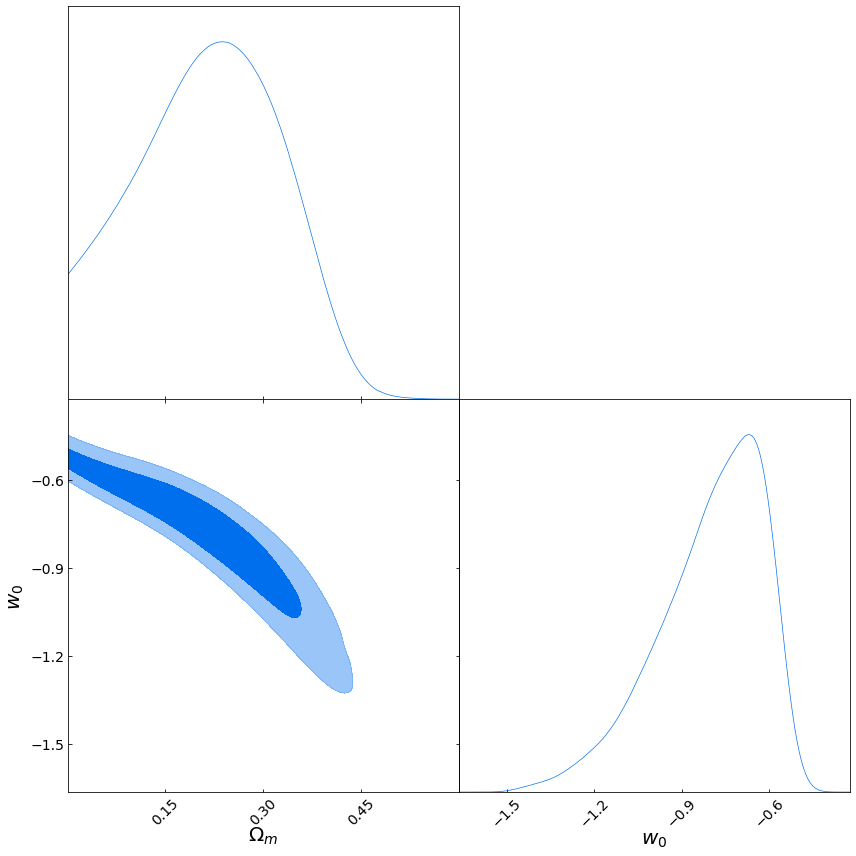

Population 53/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 4860 samples, validate on 540 samples
Epoch 1/100
4860/4860 [==============================] - 8s 2ms/step - loss: 1.3537 - val_loss: 1.3802
Epoch 2/100
4860/4860 [==============================] - 8s 2ms/step - loss: 1.3556 - val_loss: 1.3850
Epoch 3/100
4860/4860 [==============================] - 8s 2ms/step - loss: 1.3558 - val_loss: 1.3862
Epoch 4/100
4860/4860 [==============================] - 10s 2ms/step - loss: 1.3538 - val_loss: 1.3973
Epoch 5/100
4860/4860 [==============================] - 8s 2ms/step - loss: 1.3522 - val_loss: 1.3931
Epoch 6/100
4860/4860 [==============================] - 8s 2ms/step - loss: 1.3534 - val_loss: 1.3971
Train on 4860 samples, validate on 540 samples
Epoch 1/100
4860/4860 [==============================] - 10s 2ms/step - loss: 1.3487 - val_loss: 1.3980
Epoch 2/100
4860/4860 [==============================] - 10s 2ms/step - loss: 1.3495 - val_loss: 1.3979
E

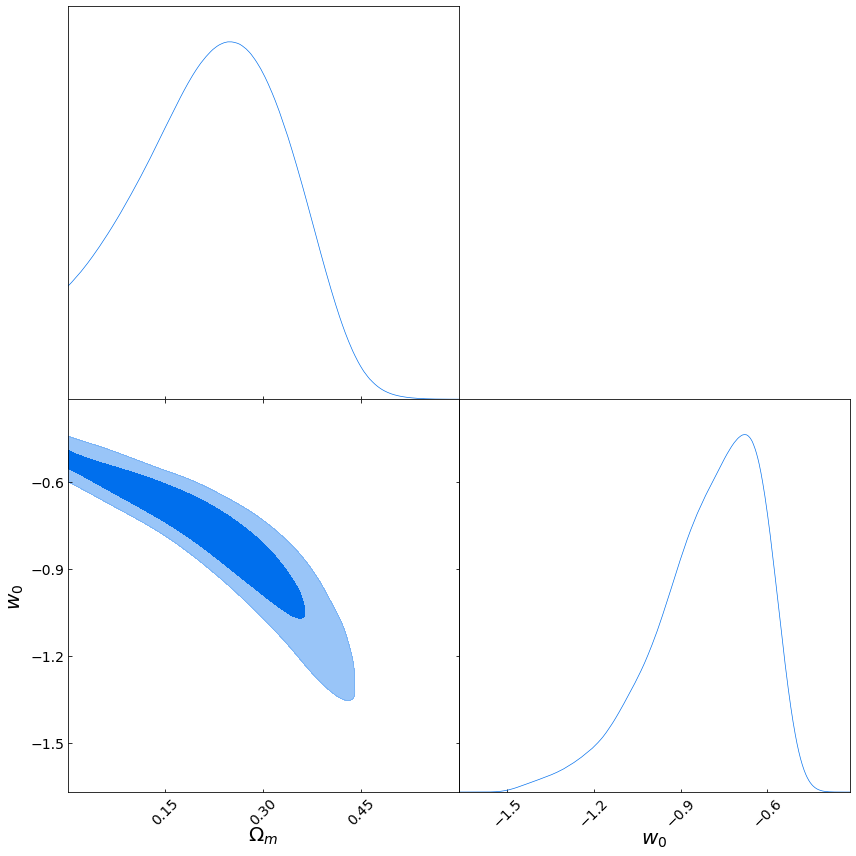

Population 54/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 4950 samples, validate on 550 samples
Epoch 1/100
4950/4950 [==============================] - 7s 1ms/step - loss: 1.3538 - val_loss: 1.4252
Epoch 2/100
4950/4950 [==============================] - 7s 1ms/step - loss: 1.3630 - val_loss: 1.4101
Epoch 3/100
4950/4950 [==============================] - 7s 1ms/step - loss: 1.3528 - val_loss: 1.4138
Epoch 4/100
4950/4950 [==============================] - 7s 1ms/step - loss: 1.3538 - val_loss: 1.4133
Epoch 5/100
4950/4950 [==============================] - 7s 1ms/step - loss: 1.3567 - val_loss: 1.4126
Epoch 6/100
4950/4950 [==============================] - 7s 1ms/step - loss: 1.3657 - val_loss: 1.4117
Epoch 7/100
4950/4950 [==============================] - 7s 1ms/step - loss: 1.3553 - val_loss: 1.4133
Train on 4950 samples, validate on 550 samples
Epoch 1/100
4950/4950 [==============================] - 8s 2ms/step - loss: 1.3501 - val_loss: 1.4122
Epoc

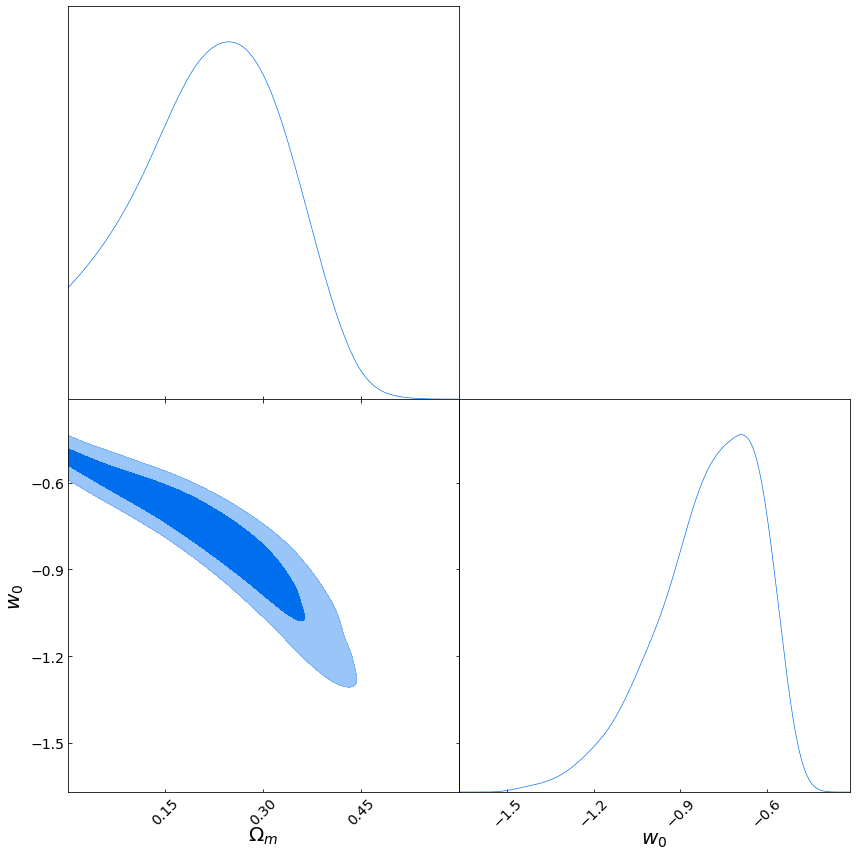

Population 55/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 5040 samples, validate on 560 samples
Epoch 1/100
5040/5040 [==============================] - 9s 2ms/step - loss: 1.3555 - val_loss: 1.4162
Epoch 2/100
5040/5040 [==============================] - 9s 2ms/step - loss: 1.3532 - val_loss: 1.4173
Epoch 3/100
5040/5040 [==============================] - 10s 2ms/step - loss: 1.3599 - val_loss: 1.4146
Epoch 4/100
5040/5040 [==============================] - 9s 2ms/step - loss: 1.3558 - val_loss: 1.4177
Epoch 5/100
5040/5040 [==============================] - 10s 2ms/step - loss: 1.3520 - val_loss: 1.4130
Epoch 6/100
5040/5040 [==============================] - 9s 2ms/step - loss: 1.3616 - val_loss: 1.4151
Epoch 7/100
5040/5040 [==============================] - 9s 2ms/step - loss: 1.3541 - val_loss: 1.4143
Epoch 8/100
5040/5040 [==============================] - 9s 2ms/step - loss: 1.3577 - val_loss: 1.4153
Epoch 9/100
5040/5040 [==========================

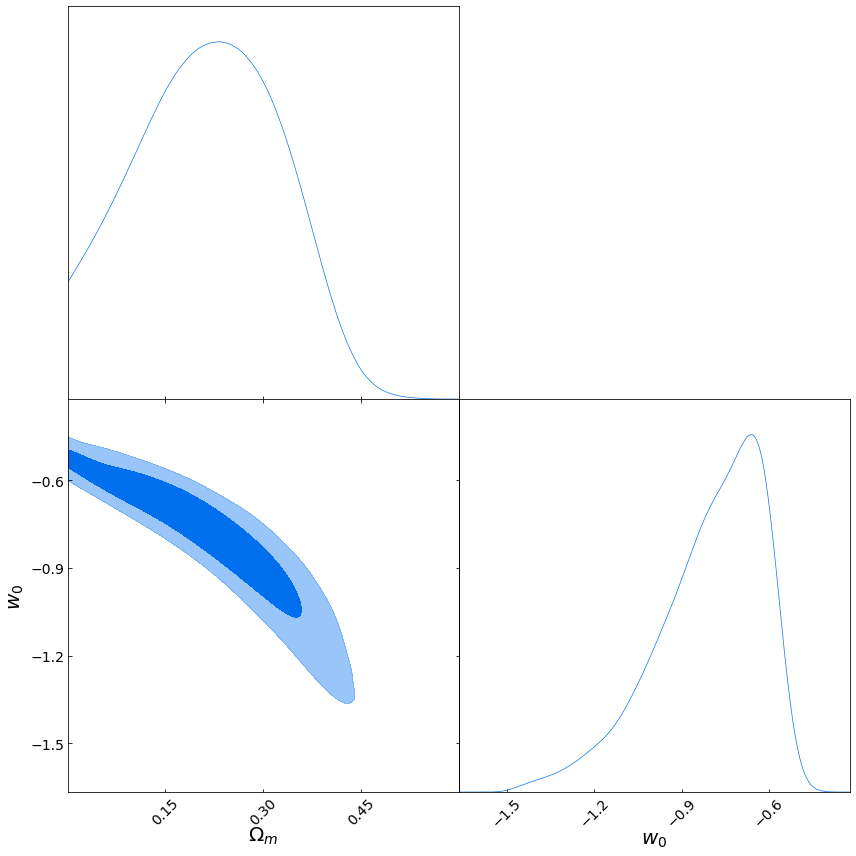

Population 56/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 5130 samples, validate on 570 samples
Epoch 1/100
5130/5130 [==============================] - 7s 1ms/step - loss: 1.3586 - val_loss: 1.4133
Epoch 2/100
5130/5130 [==============================] - 7s 1ms/step - loss: 1.3602 - val_loss: 1.4039
Epoch 3/100
5130/5130 [==============================] - 7s 1ms/step - loss: 1.3540 - val_loss: 1.3995
Epoch 4/100
5130/5130 [==============================] - 7s 1ms/step - loss: 1.3584 - val_loss: 1.4039
Epoch 5/100
5130/5130 [==============================] - 8s 1ms/step - loss: 1.3573 - val_loss: 1.3990
Epoch 6/100
5130/5130 [==============================] - 8s 2ms/step - loss: 1.3580 - val_loss: 1.4078
Epoch 7/100
5130/5130 [==============================] - 9s 2ms/step - loss: 1.3599 - val_loss: 1.3952
Epoch 8/100
5130/5130 [==============================] - 9s 2ms/step - loss: 1.3568 - val_loss: 1.4029
Epoch 9/100
5130/5130 [============================

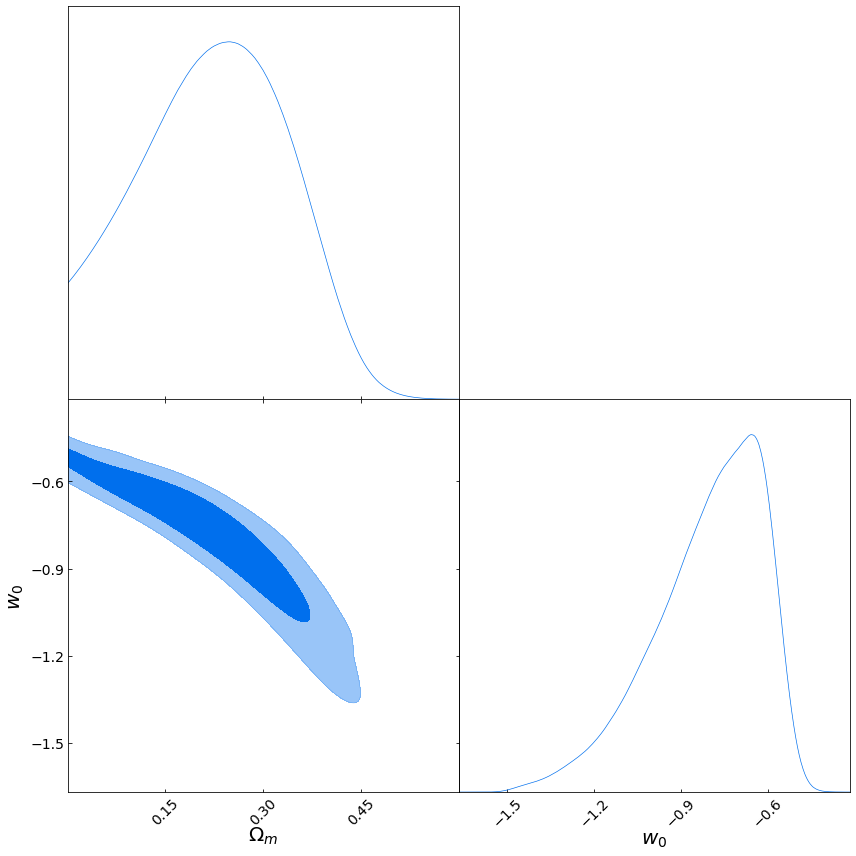

Population 57/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 5220 samples, validate on 580 samples
Epoch 1/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3607 - val_loss: 1.4159
Epoch 2/100
5220/5220 [==============================] - 9s 2ms/step - loss: 1.3615 - val_loss: 1.3960
Epoch 3/100
5220/5220 [==============================] - 9s 2ms/step - loss: 1.3565 - val_loss: 1.3919
Epoch 4/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3640 - val_loss: 1.3924
Epoch 5/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3601 - val_loss: 1.3903
Epoch 6/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3573 - val_loss: 1.4116
Epoch 7/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3622 - val_loss: 1.3929
Epoch 8/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3609 - val_loss: 1.3930
Epoch 9/100
5220/5220 [============================

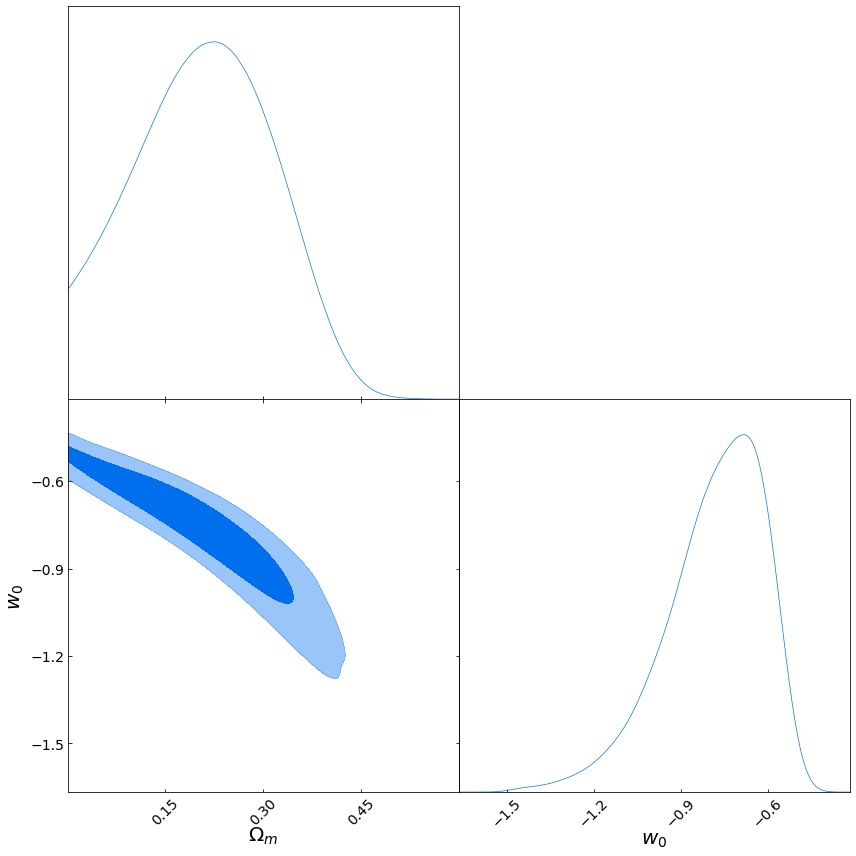

Population 58/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 5310 samples, validate on 590 samples
Epoch 1/100
5310/5310 [==============================] - 7s 1ms/step - loss: 1.3618 - val_loss: 1.3854
Epoch 2/100
5310/5310 [==============================] - 7s 1ms/step - loss: 1.3597 - val_loss: 1.3695
Epoch 3/100
5310/5310 [==============================] - 7s 1ms/step - loss: 1.3682 - val_loss: 1.3775
Epoch 4/100
5310/5310 [==============================] - 7s 1ms/step - loss: 1.3629 - val_loss: 1.3901
Epoch 5/100
5310/5310 [==============================] - 7s 1ms/step - loss: 1.3680 - val_loss: 1.3804
Epoch 6/100
5310/5310 [==============================] - 7s 1ms/step - loss: 1.3635 - val_loss: 1.4065
Epoch 7/100
5310/5310 [==============================] - 7s 1ms/step - loss: 1.3703 - val_loss: 1.3785
Train on 5310 samples, validate on 590 samples
Epoch 1/100
5310/5310 [==============================] - 9s 2ms/step - loss: 1.3586 - val_loss: 1.3784
Epoc

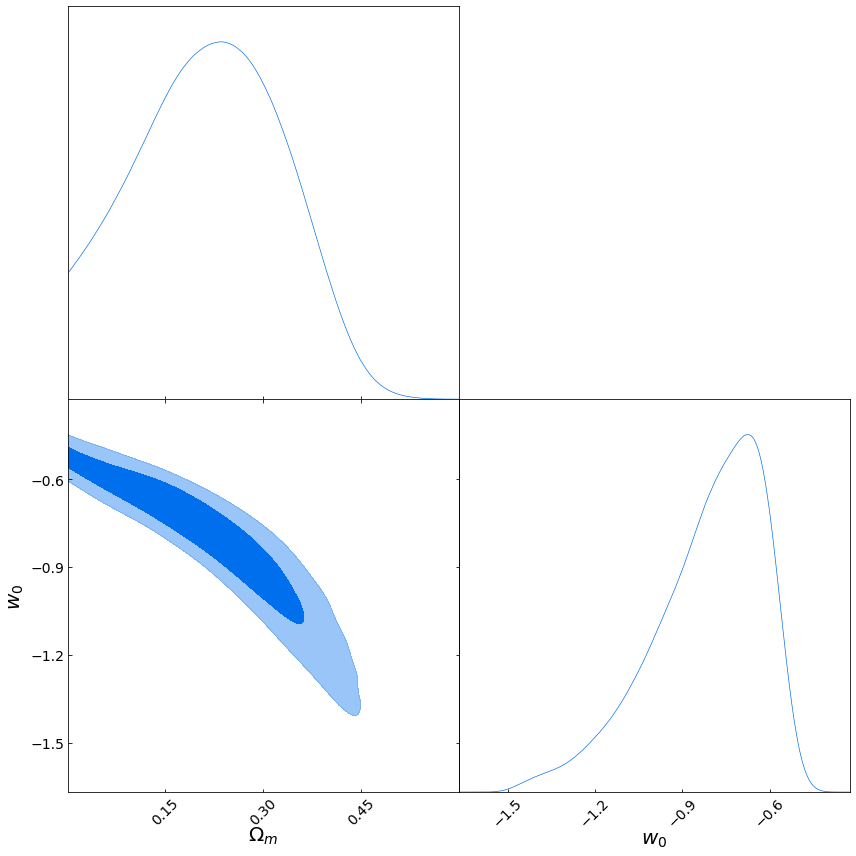

Population 59/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - 10s 2ms/step - loss: 1.3563 - val_loss: 1.4643
Epoch 2/100
5400/5400 [==============================] - 8s 1ms/step - loss: 1.3586 - val_loss: 1.4536
Epoch 3/100
5400/5400 [==============================] - 8s 1ms/step - loss: 1.3571 - val_loss: 1.4402
Epoch 4/100
5400/5400 [==============================] - 8s 1ms/step - loss: 1.3592 - val_loss: 1.4352
Epoch 5/100
5400/5400 [==============================] - 8s 1ms/step - loss: 1.3581 - val_loss: 1.4353
Epoch 6/100
5400/5400 [==============================] - 8s 2ms/step - loss: 1.3578 - val_loss: 1.4380
Epoch 7/100
5400/5400 [==============================] - 7s 1ms/step - loss: 1.3593 - val_loss: 1.4496
Epoch 8/100
5400/5400 [==============================] - 7s 1ms/step - loss: 1.3542 - val_loss: 1.4331
Epoch 9/100
5400/5400 [===========================

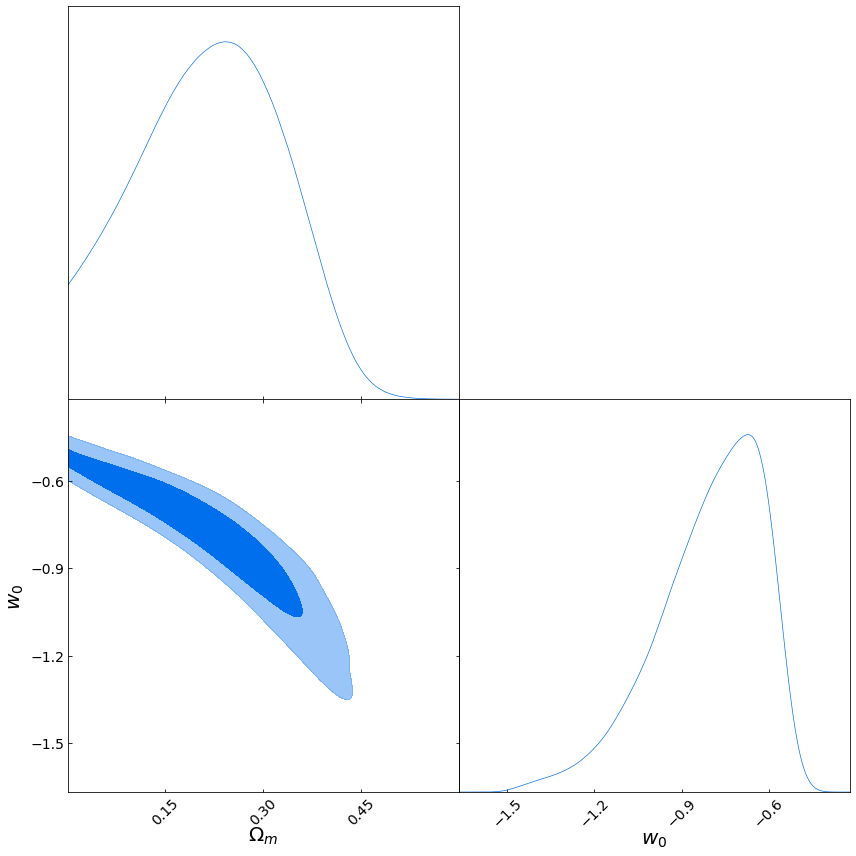

Population 60/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 5490 samples, validate on 610 samples
Epoch 1/100
5490/5490 [==============================] - 8s 1ms/step - loss: 1.3584 - val_loss: 1.4293
Epoch 2/100
5490/5490 [==============================] - 9s 2ms/step - loss: 1.3584 - val_loss: 1.4326
Epoch 3/100
5490/5490 [==============================] - 9s 2ms/step - loss: 1.3598 - val_loss: 1.4338
Epoch 4/100
5490/5490 [==============================] - 9s 2ms/step - loss: 1.3641 - val_loss: 1.4268
Epoch 5/100
5490/5490 [==============================] - 10s 2ms/step - loss: 1.3570 - val_loss: 1.4313
Epoch 6/100
5490/5490 [==============================] - 11s 2ms/step - loss: 1.3643 - val_loss: 1.4337
Epoch 7/100
5490/5490 [==============================] - 16s 3ms/step - loss: 1.3586 - val_loss: 1.4316
Epoch 8/100
5490/5490 [==============================] - 10s 2ms/step - loss: 1.3608 - val_loss: 1.4293
Epoch 9/100
5490/5490 [========================

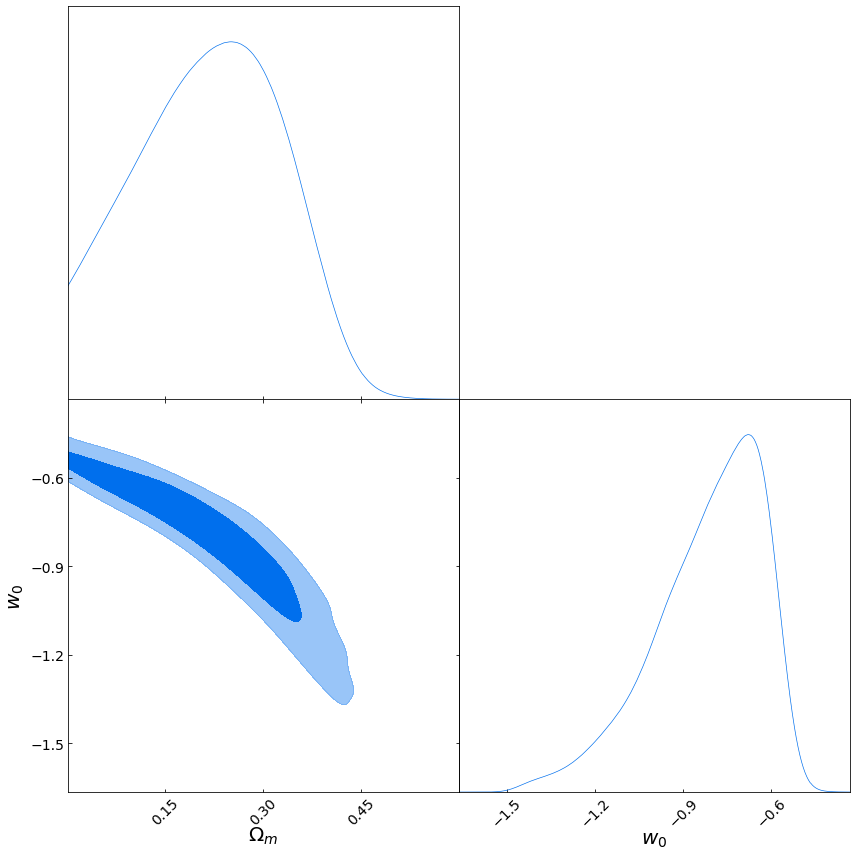

Population 61/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 5580 samples, validate on 620 samples
Epoch 1/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3587 - val_loss: 1.4032
Epoch 2/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3596 - val_loss: 1.3997
Epoch 3/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3613 - val_loss: 1.4040
Epoch 4/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3596 - val_loss: 1.4007
Epoch 5/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3587 - val_loss: 1.4071
Epoch 6/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3602 - val_loss: 1.4085
Epoch 7/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3602 - val_loss: 1.4100
Train on 5580 samples, validate on 620 samples
Epoch 1/100
5580/5580 [==============================] - 9s 2ms/step - loss: 1.3552 - val_loss: 1.4113
Epoc

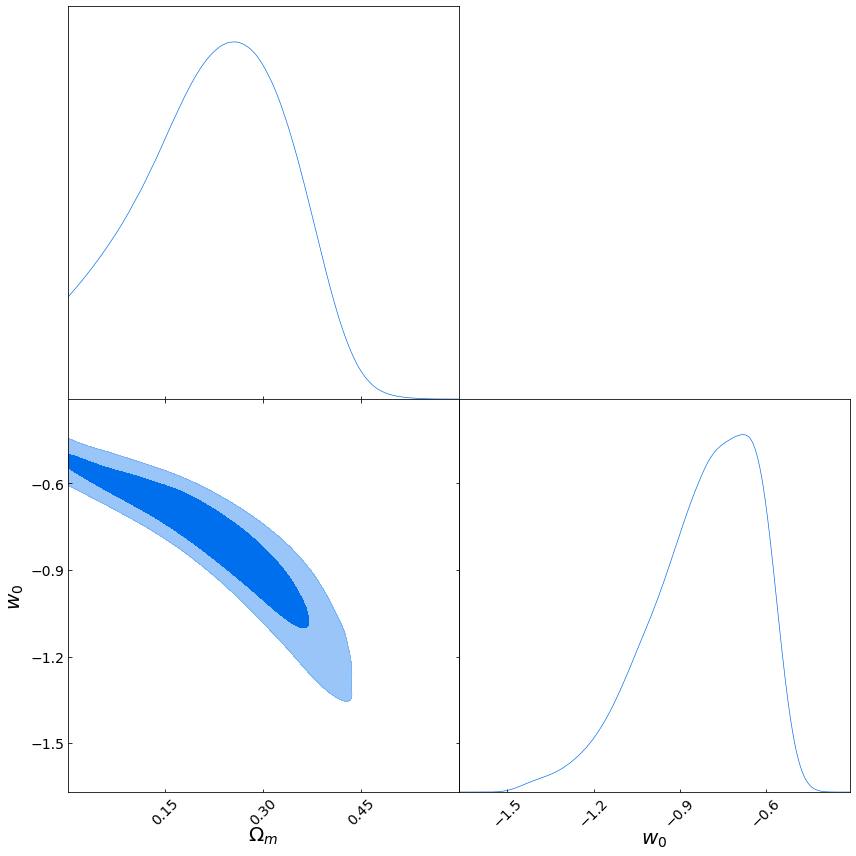

Population 62/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 5670 samples, validate on 630 samples
Epoch 1/100
5670/5670 [==============================] - 8s 1ms/step - loss: 1.3580 - val_loss: 1.4258
Epoch 2/100
5670/5670 [==============================] - 9s 2ms/step - loss: 1.3570 - val_loss: 1.4214
Epoch 3/100
5670/5670 [==============================] - 10s 2ms/step - loss: 1.3591 - val_loss: 1.4262
Epoch 4/100
5670/5670 [==============================] - 10s 2ms/step - loss: 1.3608 - val_loss: 1.4205
Epoch 5/100
5670/5670 [==============================] - 10s 2ms/step - loss: 1.3610 - val_loss: 1.4178
Epoch 6/100
5670/5670 [==============================] - 10s 2ms/step - loss: 1.3607 - val_loss: 1.4171
Epoch 7/100
5670/5670 [==============================] - 10s 2ms/step - loss: 1.3648 - val_loss: 1.4215
Epoch 8/100
5670/5670 [==============================] - 10s 2ms/step - loss: 1.3589 - val_loss: 1.4194
Epoch 9/100
5670/5670 [======================

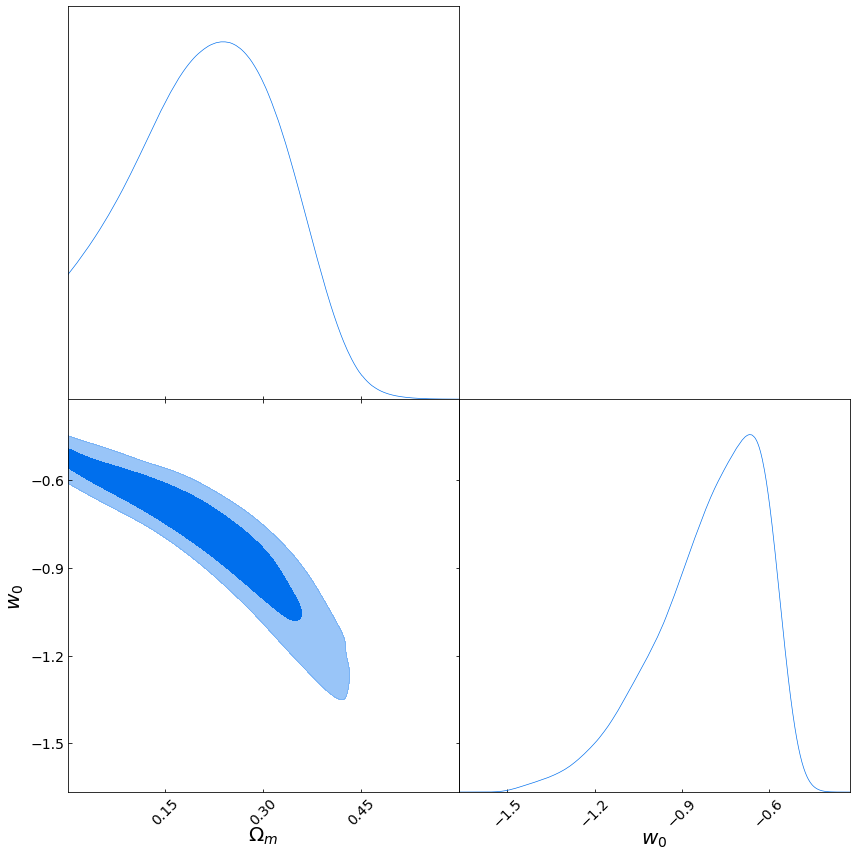

Population 63/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 5760 samples, validate on 640 samples
Epoch 1/100
5760/5760 [==============================] - 10s 2ms/step - loss: 1.3560 - val_loss: 1.3961
Epoch 2/100
5760/5760 [==============================] - 10s 2ms/step - loss: 1.3626 - val_loss: 1.3966
Epoch 3/100
5760/5760 [==============================] - 10s 2ms/step - loss: 1.3596 - val_loss: 1.3971
Epoch 4/100
5760/5760 [==============================] - 10s 2ms/step - loss: 1.3585 - val_loss: 1.4000
Epoch 5/100
5760/5760 [==============================] - 10s 2ms/step - loss: 1.3638 - val_loss: 1.4032
Epoch 6/100
5760/5760 [==============================] - 10s 2ms/step - loss: 1.3620 - val_loss: 1.3981
Train on 5760 samples, validate on 640 samples
Epoch 1/100
5760/5760 [==============================] - 12s 2ms/step - loss: 1.3501 - val_loss: 1.3975
Epoch 2/100
5760/5760 [==============================] - 13s 2ms/step - loss: 1.3496 - val_loss: 1.3

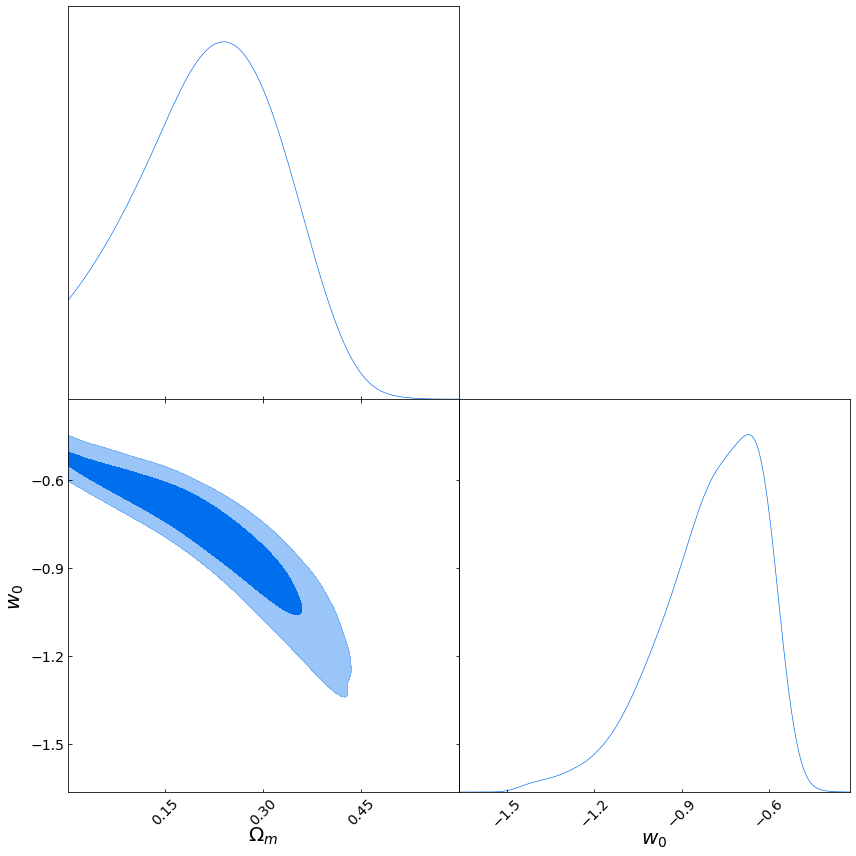

Population 64/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 5850 samples, validate on 650 samples
Epoch 1/100
5850/5850 [==============================] - 8s 1ms/step - loss: 1.3575 - val_loss: 1.4227
Epoch 2/100
5850/5850 [==============================] - 8s 1ms/step - loss: 1.3626 - val_loss: 1.4036
Epoch 3/100
5850/5850 [==============================] - 8s 1ms/step - loss: 1.3624 - val_loss: 1.4003
Epoch 4/100
5850/5850 [==============================] - 8s 1ms/step - loss: 1.3613 - val_loss: 1.3982
Epoch 5/100
5850/5850 [==============================] - 9s 2ms/step - loss: 1.3626 - val_loss: 1.4097
Epoch 6/100
5850/5850 [==============================] - 8s 1ms/step - loss: 1.3616 - val_loss: 1.4137
Epoch 7/100
5850/5850 [==============================] - 8s 1ms/step - loss: 1.3646 - val_loss: 1.3965
Epoch 8/100
5850/5850 [==============================] - 8s 1ms/step - loss: 1.3611 - val_loss: 1.4074
Epoch 9/100
5850/5850 [============================

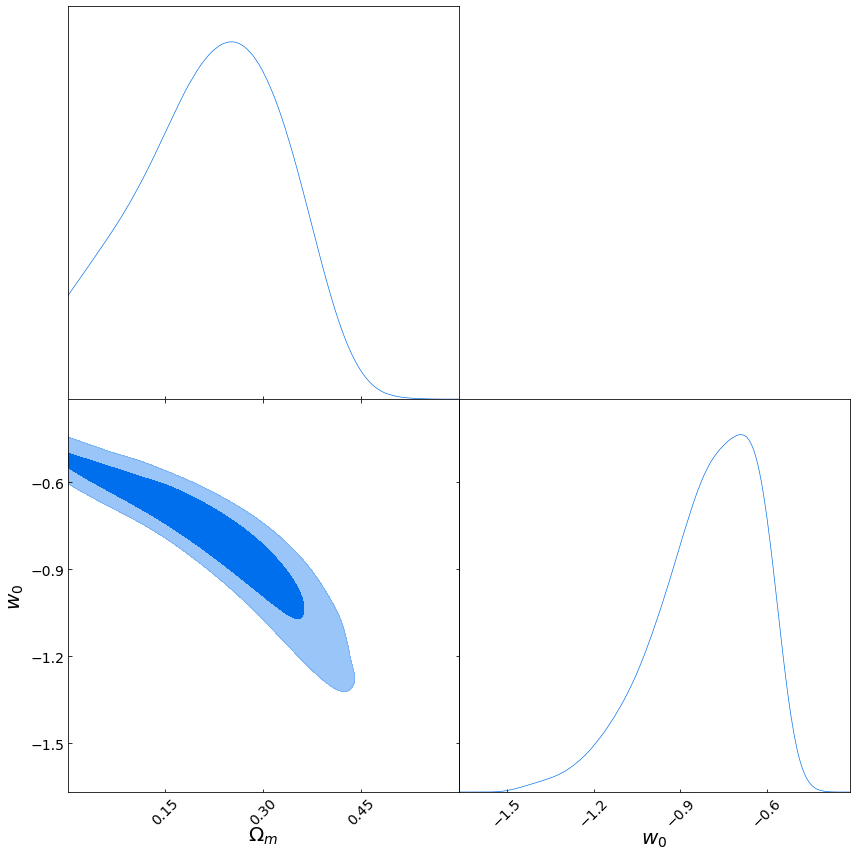

Population 65/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 5940 samples, validate on 660 samples
Epoch 1/100
5940/5940 [==============================] - 8s 1ms/step - loss: 1.3624 - val_loss: 1.3850
Epoch 2/100
5940/5940 [==============================] - 8s 1ms/step - loss: 1.3651 - val_loss: 1.3785
Epoch 3/100
5940/5940 [==============================] - 8s 1ms/step - loss: 1.3640 - val_loss: 1.3740
Epoch 4/100
5940/5940 [==============================] - 8s 1ms/step - loss: 1.3648 - val_loss: 1.3732
Epoch 5/100
5940/5940 [==============================] - 8s 1ms/step - loss: 1.3616 - val_loss: 1.3815
Epoch 6/100
5940/5940 [==============================] - 8s 1ms/step - loss: 1.3627 - val_loss: 1.3960
Epoch 7/100
5940/5940 [==============================] - 8s 1ms/step - loss: 1.3630 - val_loss: 1.3928
Epoch 8/100
5940/5940 [==============================] - 8s 1ms/step - loss: 1.3631 - val_loss: 1.4071
Epoch 9/100
5940/5940 [============================

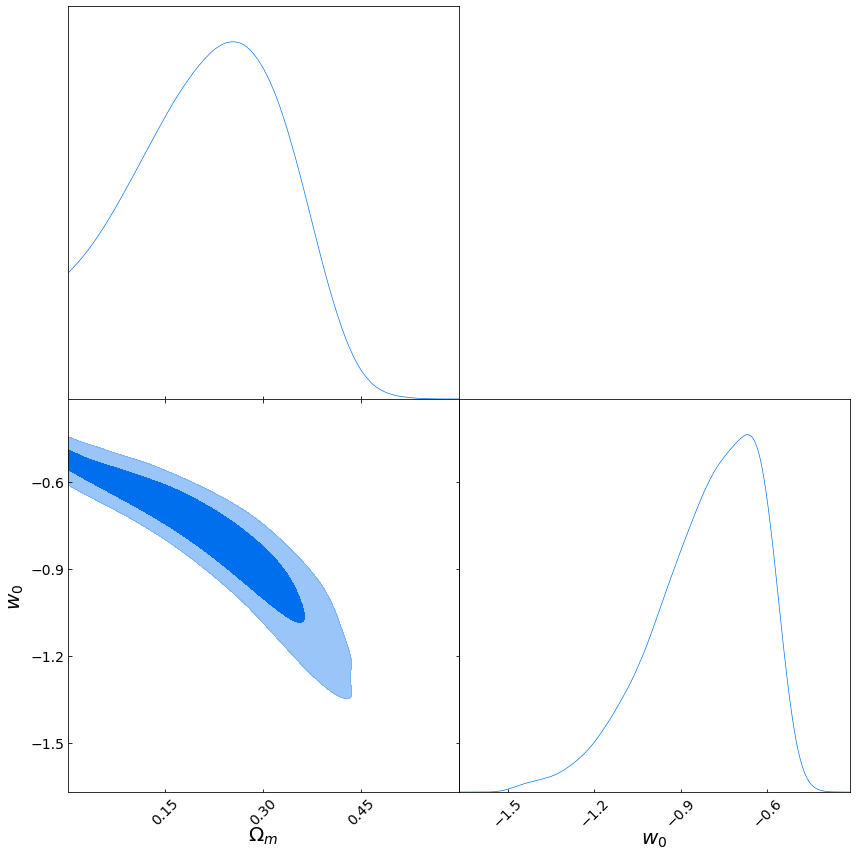

Population 66/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 6030 samples, validate on 670 samples
Epoch 1/100
6030/6030 [==============================] - 8s 1ms/step - loss: 1.3636 - val_loss: 1.3627
Epoch 2/100
6030/6030 [==============================] - 8s 1ms/step - loss: 1.3645 - val_loss: 1.3554
Epoch 3/100
6030/6030 [==============================] - 8s 1ms/step - loss: 1.3681 - val_loss: 1.3957
Epoch 4/100
6030/6030 [==============================] - 8s 1ms/step - loss: 1.3694 - val_loss: 1.3655
Epoch 5/100
6030/6030 [==============================] - 9s 1ms/step - loss: 1.3644 - val_loss: 1.3553
Epoch 6/100
6030/6030 [==============================] - 10s 2ms/step - loss: 1.3658 - val_loss: 1.3551
Epoch 7/100
6030/6030 [==============================] - 9s 1ms/step - loss: 1.3662 - val_loss: 1.3676
Epoch 8/100
6030/6030 [==============================] - 8s 1ms/step - loss: 1.3646 - val_loss: 1.3697
Epoch 9/100
6030/6030 [===========================

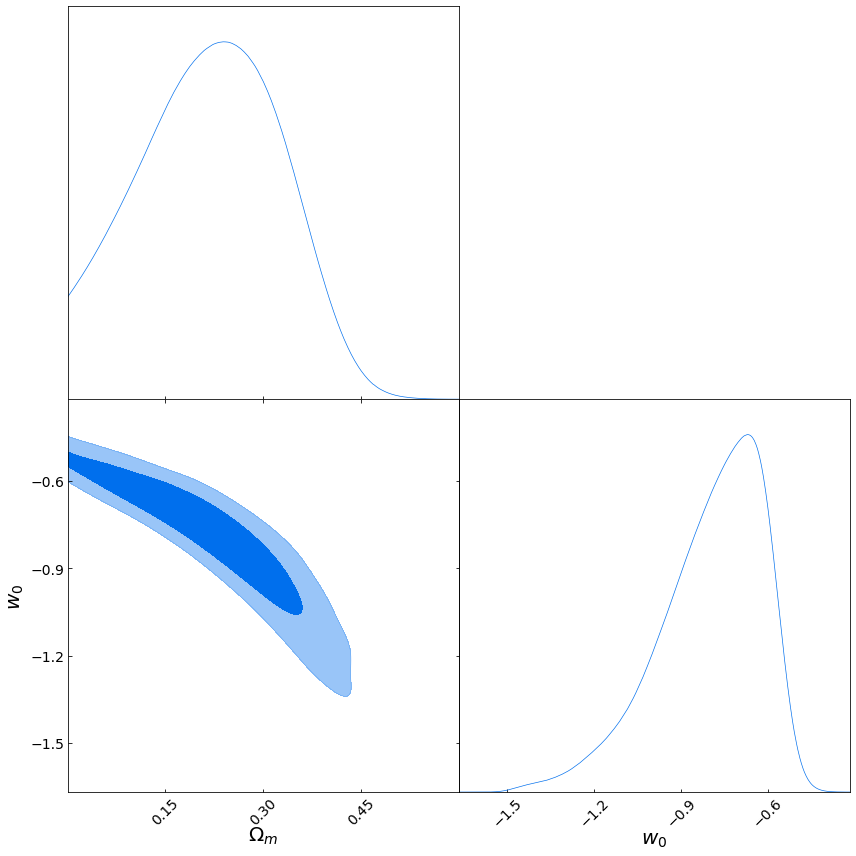

Population 67/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 6120 samples, validate on 680 samples
Epoch 1/100
6120/6120 [==============================] - 11s 2ms/step - loss: 1.3622 - val_loss: 1.3604
Epoch 2/100
6120/6120 [==============================] - 11s 2ms/step - loss: 1.3634 - val_loss: 1.3860
Epoch 3/100
6120/6120 [==============================] - 11s 2ms/step - loss: 1.3670 - val_loss: 1.3523
Epoch 4/100
6120/6120 [==============================] - 11s 2ms/step - loss: 1.3633 - val_loss: 1.3589
Epoch 5/100
6120/6120 [==============================] - 11s 2ms/step - loss: 1.3635 - val_loss: 1.3618
Epoch 6/100
6120/6120 [==============================] - 11s 2ms/step - loss: 1.3672 - val_loss: 1.3609
Epoch 7/100
6120/6120 [==============================] - 11s 2ms/step - loss: 1.3706 - val_loss: 1.3675
Epoch 8/100
6120/6120 [==============================] - 11s 2ms/step - loss: 1.3652 - val_loss: 1.3592
Train on 6120 samples, validate on 680 samp

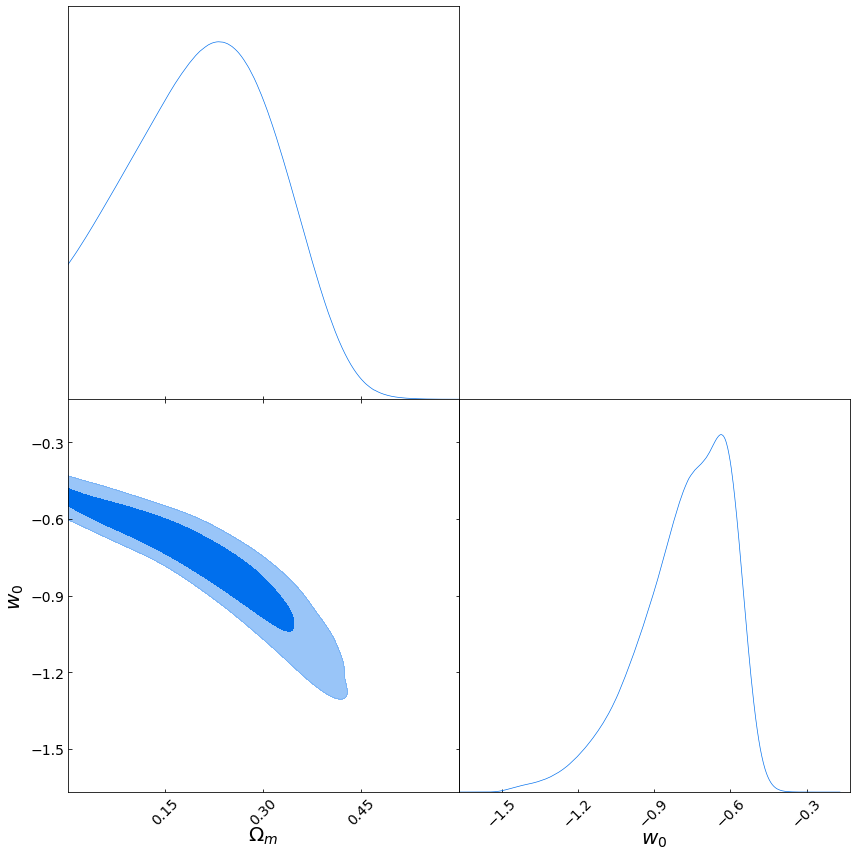

Population 68/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 6210 samples, validate on 690 samples
Epoch 1/100
6210/6210 [==============================] - 13s 2ms/step - loss: 1.3596 - val_loss: 1.3527
Epoch 2/100
6210/6210 [==============================] - 11s 2ms/step - loss: 1.3646 - val_loss: 1.3837
Epoch 3/100
6210/6210 [==============================] - 11s 2ms/step - loss: 1.3665 - val_loss: 1.3425
Epoch 4/100
6210/6210 [==============================] - 11s 2ms/step - loss: 1.3654 - val_loss: 1.3546
Epoch 5/100
6210/6210 [==============================] - 11s 2ms/step - loss: 1.3659 - val_loss: 1.3564
Epoch 6/100
6210/6210 [==============================] - 11s 2ms/step - loss: 1.3632 - val_loss: 1.3431
Epoch 7/100
6210/6210 [==============================] - 11s 2ms/step - loss: 1.3626 - val_loss: 1.3460
Epoch 8/100
6210/6210 [==============================] - 11s 2ms/step - loss: 1.3621 - val_loss: 1.3446
Train on 6210 samples, validate on 690 samp

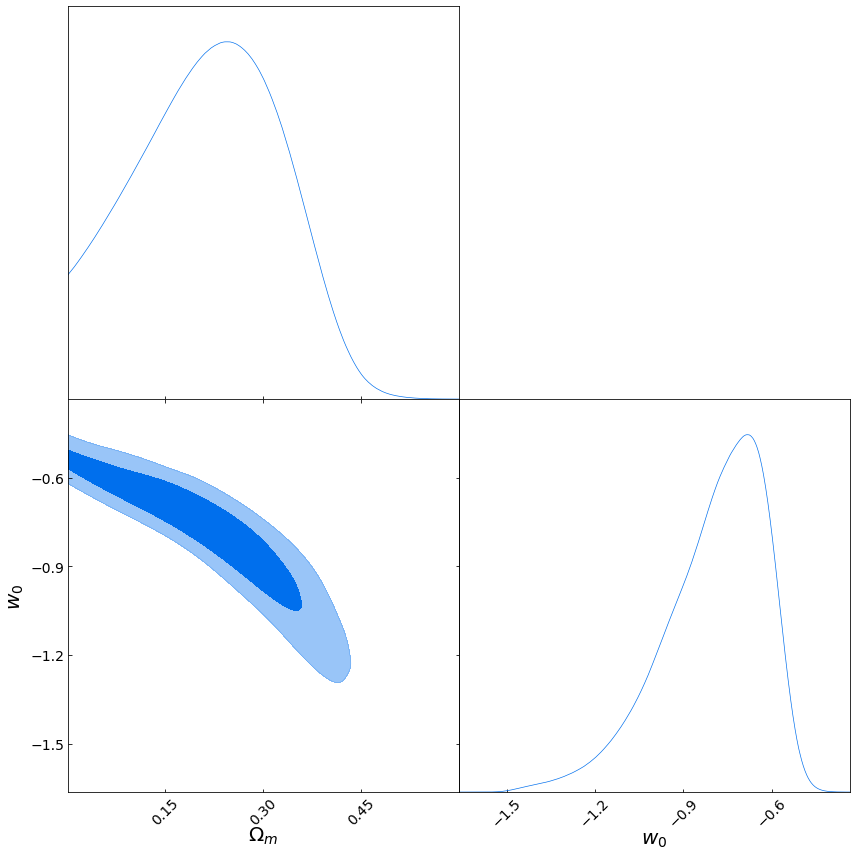

Population 69/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 6300 samples, validate on 700 samples
Epoch 1/100
6300/6300 [==============================] - 8s 1ms/step - loss: 1.3621 - val_loss: 1.3163
Epoch 2/100
6300/6300 [==============================] - 8s 1ms/step - loss: 1.3646 - val_loss: 1.3379
Epoch 3/100
6300/6300 [==============================] - 9s 1ms/step - loss: 1.3626 - val_loss: 1.3241
Epoch 4/100
6300/6300 [==============================] - 10s 2ms/step - loss: 1.3676 - val_loss: 1.3386
Epoch 5/100
6300/6300 [==============================] - 8s 1ms/step - loss: 1.3647 - val_loss: 1.3350
Epoch 6/100
6300/6300 [==============================] - 8s 1ms/step - loss: 1.3732 - val_loss: 1.3309
Train on 6300 samples, validate on 700 samples
Epoch 1/100
6300/6300 [==============================] - 10s 2ms/step - loss: 1.3622 - val_loss: 1.3302
Epoch 2/100
6300/6300 [==============================] - 10s 2ms/step - loss: 1.3588 - val_loss: 1.3322
E

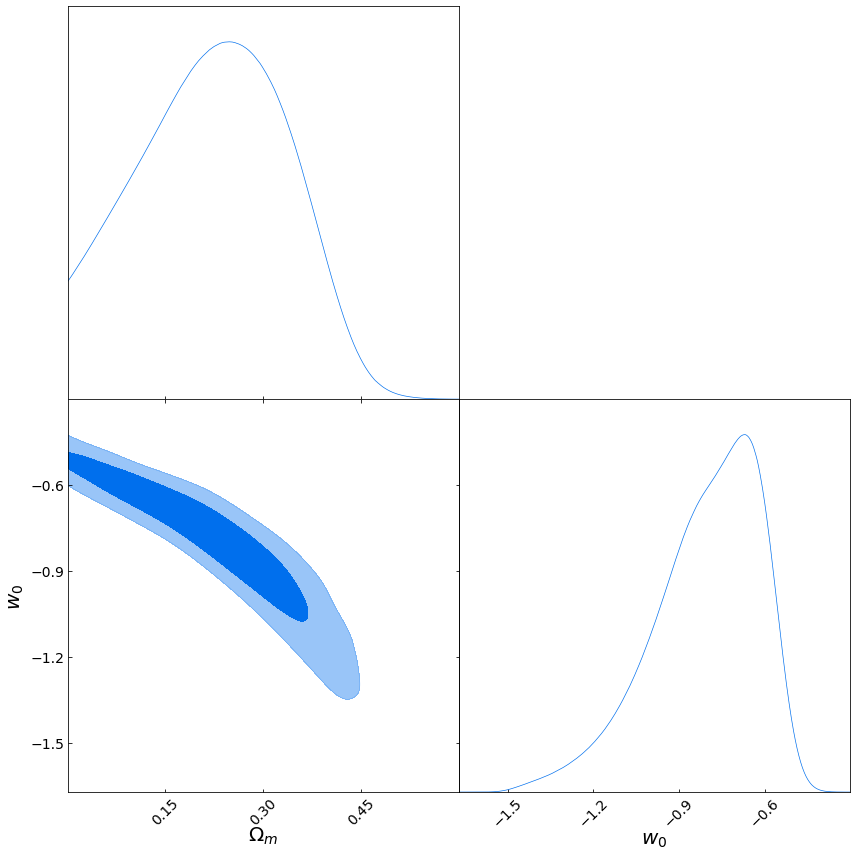

Population 70/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 6390 samples, validate on 710 samples
Epoch 1/100
6390/6390 [==============================] - 9s 1ms/step - loss: 1.3683 - val_loss: 1.3511
Epoch 2/100
6390/6390 [==============================] - 11s 2ms/step - loss: 1.3664 - val_loss: 1.3364
Epoch 3/100
6390/6390 [==============================] - 11s 2ms/step - loss: 1.3629 - val_loss: 1.3418
Epoch 4/100
6390/6390 [==============================] - 11s 2ms/step - loss: 1.3679 - val_loss: 1.3364
Epoch 5/100
6390/6390 [==============================] - 11s 2ms/step - loss: 1.3644 - val_loss: 1.3629
Epoch 6/100
6390/6390 [==============================] - 11s 2ms/step - loss: 1.3677 - val_loss: 1.3600
Epoch 7/100
6390/6390 [==============================] - 11s 2ms/step - loss: 1.3682 - val_loss: 1.3413
Epoch 8/100
6390/6390 [==============================] - 11s 2ms/step - loss: 1.3646 - val_loss: 1.3462
Epoch 9/100
6390/6390 [=====================

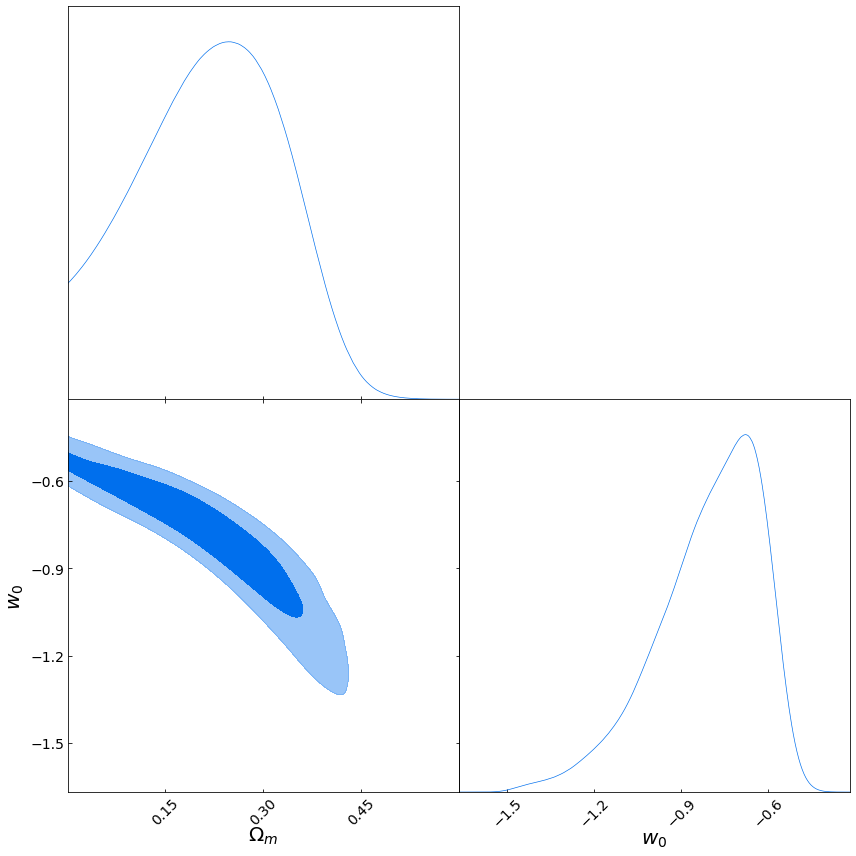

Population 71/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 6480 samples, validate on 720 samples
Epoch 1/100
6480/6480 [==============================] - 12s 2ms/step - loss: 1.3614 - val_loss: 1.3401
Epoch 2/100
6480/6480 [==============================] - 11s 2ms/step - loss: 1.3656 - val_loss: 1.3401
Epoch 3/100
6480/6480 [==============================] - 12s 2ms/step - loss: 1.3626 - val_loss: 1.3590
Epoch 4/100
6480/6480 [==============================] - 13s 2ms/step - loss: 1.3630 - val_loss: 1.3536
Epoch 5/100
6480/6480 [==============================] - 12s 2ms/step - loss: 1.3645 - val_loss: 1.3431
Epoch 6/100
6480/6480 [==============================] - 13s 2ms/step - loss: 1.3645 - val_loss: 1.3467
Train on 6480 samples, validate on 720 samples
Epoch 1/100
6480/6480 [==============================] - 14s 2ms/step - loss: 1.3630 - val_loss: 1.3455
Epoch 2/100
6480/6480 [==============================] - 14s 2ms/step - loss: 1.3621 - val_loss: 1.3

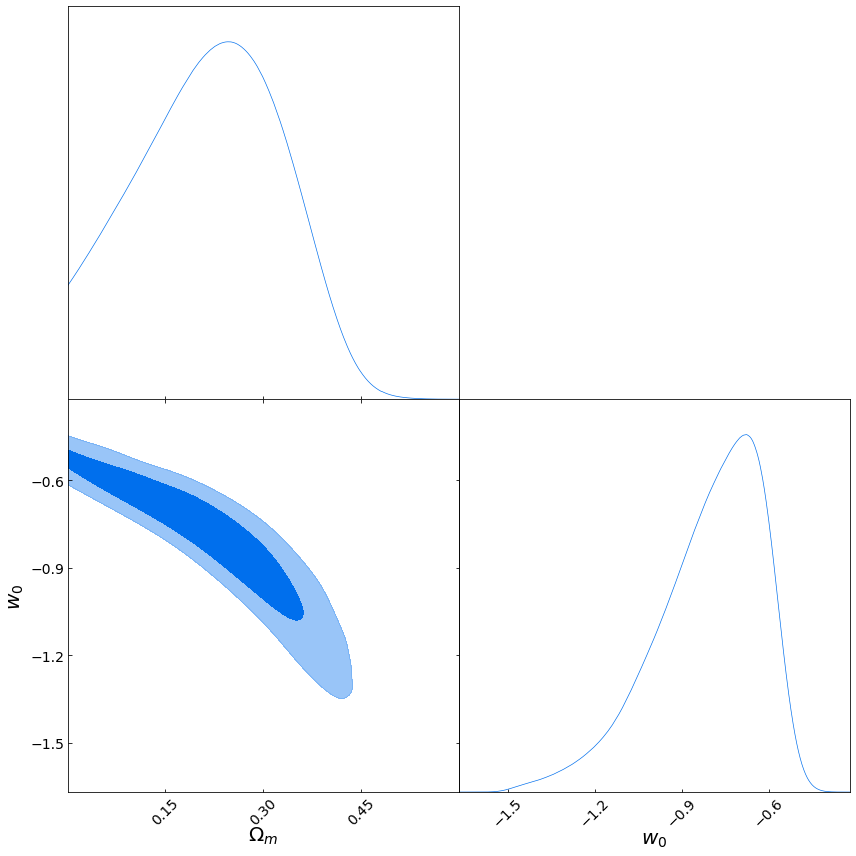

Population 72/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 6570 samples, validate on 730 samples
Epoch 1/100
6570/6570 [==============================] - 13s 2ms/step - loss: 1.3676 - val_loss: 1.3433
Epoch 2/100
6570/6570 [==============================] - 11s 2ms/step - loss: 1.3630 - val_loss: 1.3469
Epoch 3/100
6570/6570 [==============================] - 9s 1ms/step - loss: 1.3666 - val_loss: 1.3493
Epoch 4/100
6570/6570 [==============================] - 9s 1ms/step - loss: 1.3648 - val_loss: 1.3607
Epoch 5/100
6570/6570 [==============================] - 9s 1ms/step - loss: 1.3649 - val_loss: 1.3499
Epoch 6/100
6570/6570 [==============================] - 9s 1ms/step - loss: 1.3637 - val_loss: 1.3511
Train on 6570 samples, validate on 730 samples
Epoch 1/100
6570/6570 [==============================] - 11s 2ms/step - loss: 1.3596 - val_loss: 1.3537
Epoch 2/100
6570/6570 [==============================] - 11s 2ms/step - loss: 1.3614 - val_loss: 1.3550


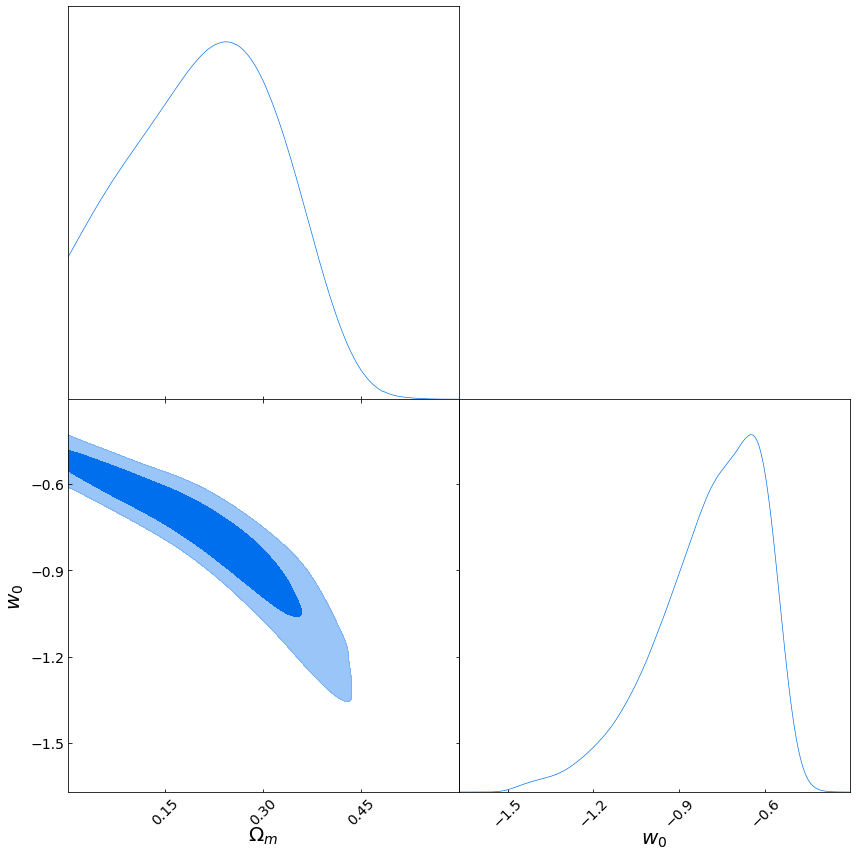

Population 73/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 6660 samples, validate on 740 samples
Epoch 1/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3654 - val_loss: 1.3478
Epoch 2/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3726 - val_loss: 1.3441
Epoch 3/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3647 - val_loss: 1.3567
Epoch 4/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3625 - val_loss: 1.3389
Epoch 5/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3629 - val_loss: 1.3373
Epoch 6/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3688 - val_loss: 1.3488
Epoch 7/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3670 - val_loss: 1.3497
Epoch 8/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3642 - val_loss: 1.3482
Epoch 9/100
6660/6660 [============================

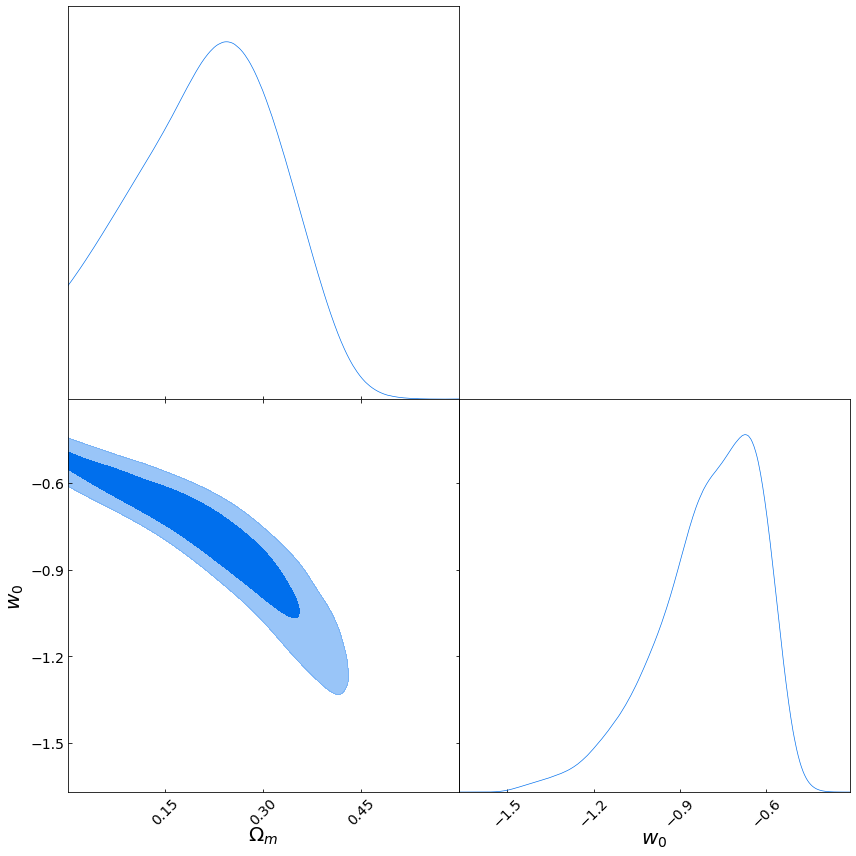

Population 74/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 6750 samples, validate on 750 samples
Epoch 1/100
6750/6750 [==============================] - 12s 2ms/step - loss: 1.3617 - val_loss: 1.3693
Epoch 2/100
6750/6750 [==============================] - 12s 2ms/step - loss: 1.3623 - val_loss: 1.3563
Epoch 3/100
6750/6750 [==============================] - 12s 2ms/step - loss: 1.3689 - val_loss: 1.3623
Epoch 4/100
6750/6750 [==============================] - 12s 2ms/step - loss: 1.3696 - val_loss: 1.3655
Epoch 5/100
6750/6750 [==============================] - 12s 2ms/step - loss: 1.3633 - val_loss: 1.3602
Epoch 6/100
6750/6750 [==============================] - 12s 2ms/step - loss: 1.3658 - val_loss: 1.3599
Epoch 7/100
6750/6750 [==============================] - 12s 2ms/step - loss: 1.3622 - val_loss: 1.3539
Epoch 8/100
6750/6750 [==============================] - 12s 2ms/step - loss: 1.3605 - val_loss: 1.3580
Epoch 9/100
6750/6750 [====================

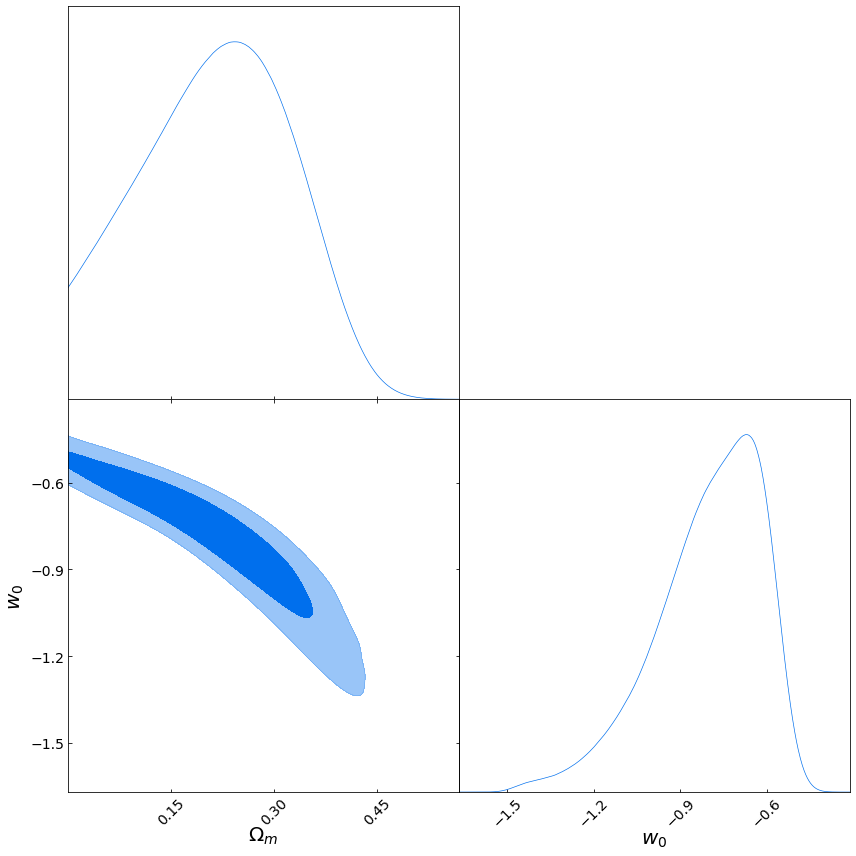

Population 75/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 6840 samples, validate on 760 samples
Epoch 1/100
6840/6840 [==============================] - 12s 2ms/step - loss: 1.3594 - val_loss: 1.3895
Epoch 2/100
6840/6840 [==============================] - 12s 2ms/step - loss: 1.3603 - val_loss: 1.3961
Epoch 3/100
6840/6840 [==============================] - 12s 2ms/step - loss: 1.3639 - val_loss: 1.3884
Epoch 4/100
6840/6840 [==============================] - 12s 2ms/step - loss: 1.3659 - val_loss: 1.3976
Epoch 5/100
6840/6840 [==============================] - 12s 2ms/step - loss: 1.3598 - val_loss: 1.3912
Epoch 6/100
6840/6840 [==============================] - 12s 2ms/step - loss: 1.3659 - val_loss: 1.3843
Epoch 7/100
6840/6840 [==============================] - 12s 2ms/step - loss: 1.3620 - val_loss: 1.4030
Epoch 8/100
6840/6840 [==============================] - 12s 2ms/step - loss: 1.3643 - val_loss: 1.3961
Epoch 9/100
6840/6840 [====================

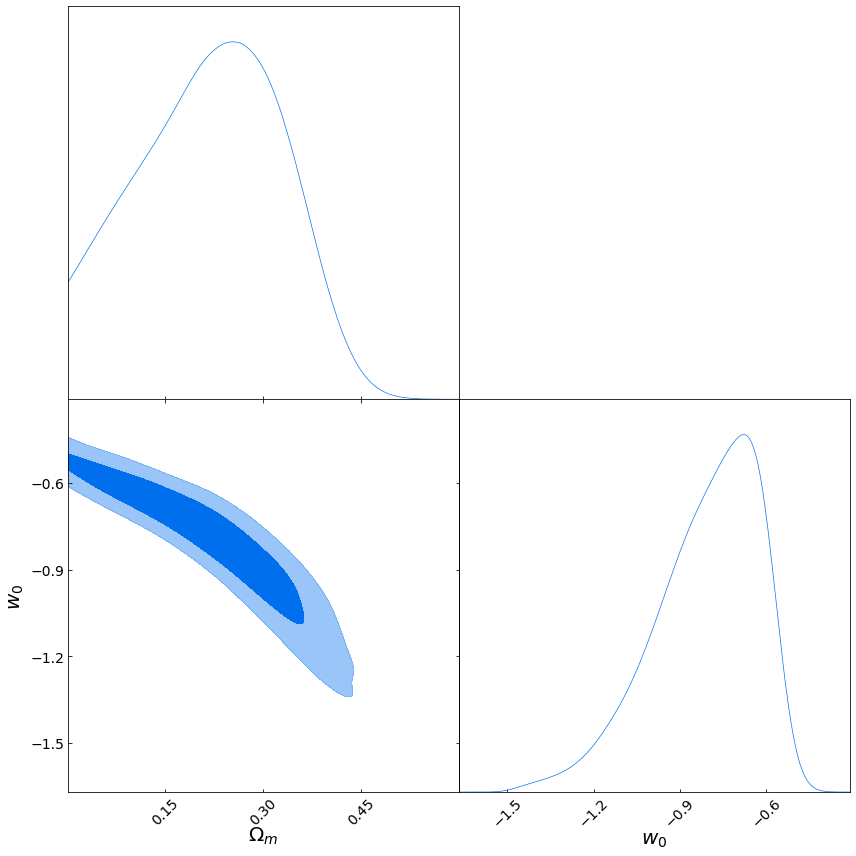

Population 76/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 6930 samples, validate on 770 samples
Epoch 1/100
6930/6930 [==============================] - 10s 1ms/step - loss: 1.3571 - val_loss: 1.4138
Epoch 2/100
6930/6930 [==============================] - 10s 1ms/step - loss: 1.3590 - val_loss: 1.4112
Epoch 3/100
6930/6930 [==============================] - 10s 1ms/step - loss: 1.3606 - val_loss: 1.4155
Epoch 4/100
6930/6930 [==============================] - 10s 1ms/step - loss: 1.3621 - val_loss: 1.4296
Epoch 5/100
6930/6930 [==============================] - 10s 1ms/step - loss: 1.3598 - val_loss: 1.4128
Epoch 6/100
6930/6930 [==============================] - 10s 1ms/step - loss: 1.3624 - val_loss: 1.4144
Epoch 7/100
6930/6930 [==============================] - 10s 2ms/step - loss: 1.3586 - val_loss: 1.4089
Epoch 8/100
6930/6930 [==============================] - 12s 2ms/step - loss: 1.3578 - val_loss: 1.4166
Epoch 9/100
6930/6930 [====================

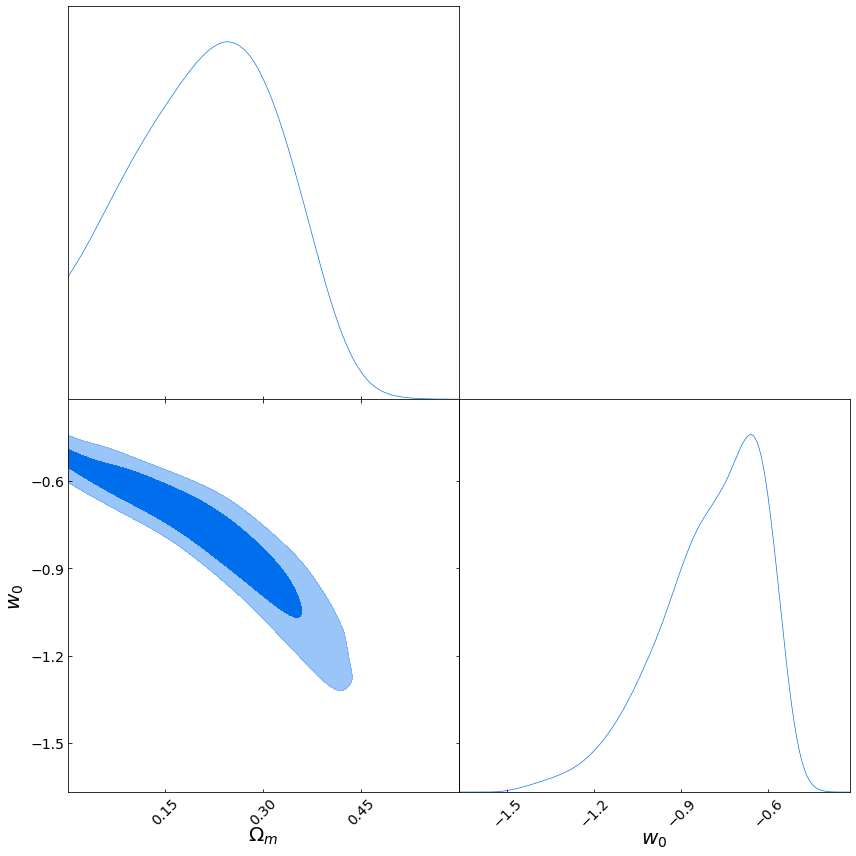

Population 77/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 7020 samples, validate on 780 samples
Epoch 1/100
7020/7020 [==============================] - 12s 2ms/step - loss: 1.3595 - val_loss: 1.4157
Epoch 2/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3576 - val_loss: 1.4077
Epoch 3/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3595 - val_loss: 1.4094
Epoch 4/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3614 - val_loss: 1.4231
Epoch 5/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3636 - val_loss: 1.4179
Epoch 6/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3642 - val_loss: 1.4017
Epoch 7/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3587 - val_loss: 1.4090
Epoch 8/100
7020/7020 [==============================] - 11s 2ms/step - loss: 1.3591 - val_loss: 1.4099
Epoch 9/100
7020/7020 [====================

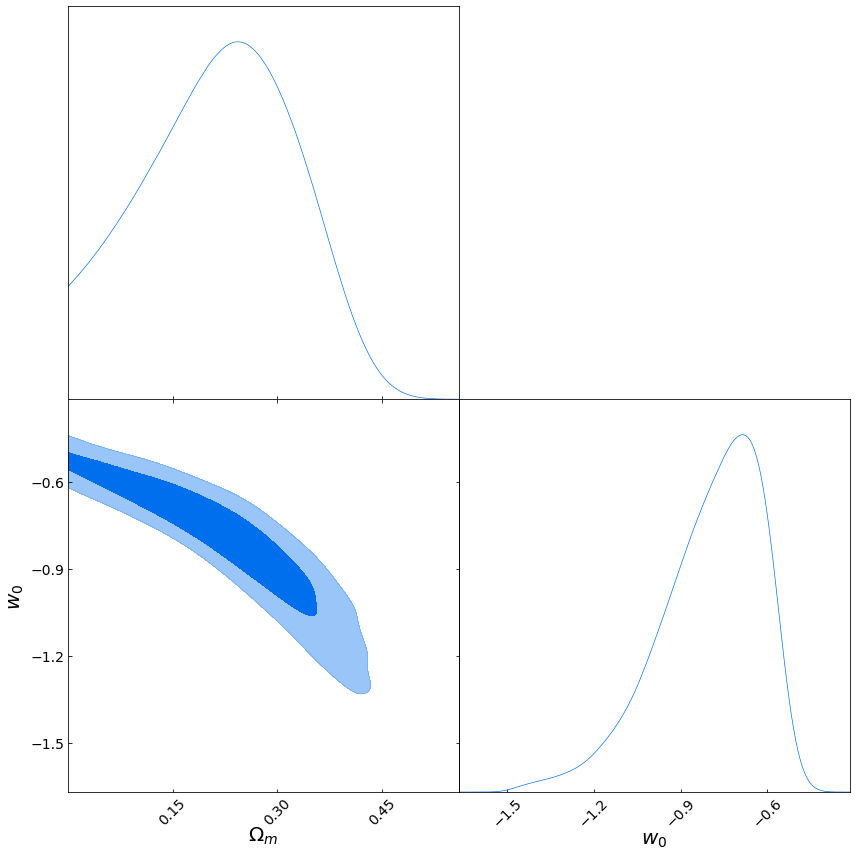

Population 78/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 7110 samples, validate on 790 samples
Epoch 1/100
7110/7110 [==============================] - 9s 1ms/step - loss: 1.3575 - val_loss: 1.3902
Epoch 2/100
7110/7110 [==============================] - 9s 1ms/step - loss: 1.3594 - val_loss: 1.3870
Epoch 3/100
7110/7110 [==============================] - 10s 1ms/step - loss: 1.3611 - val_loss: 1.3863
Epoch 4/100
7110/7110 [==============================] - 10s 1ms/step - loss: 1.3583 - val_loss: 1.3873
Epoch 5/100
7110/7110 [==============================] - 10s 1ms/step - loss: 1.3579 - val_loss: 1.3878
Epoch 6/100
7110/7110 [==============================] - 10s 1ms/step - loss: 1.3612 - val_loss: 1.3879
Epoch 7/100
7110/7110 [==============================] - 10s 1ms/step - loss: 1.3649 - val_loss: 1.3937
Epoch 8/100
7110/7110 [==============================] - 10s 1ms/step - loss: 1.3603 - val_loss: 1.3895
Train on 7110 samples, validate on 790 sample

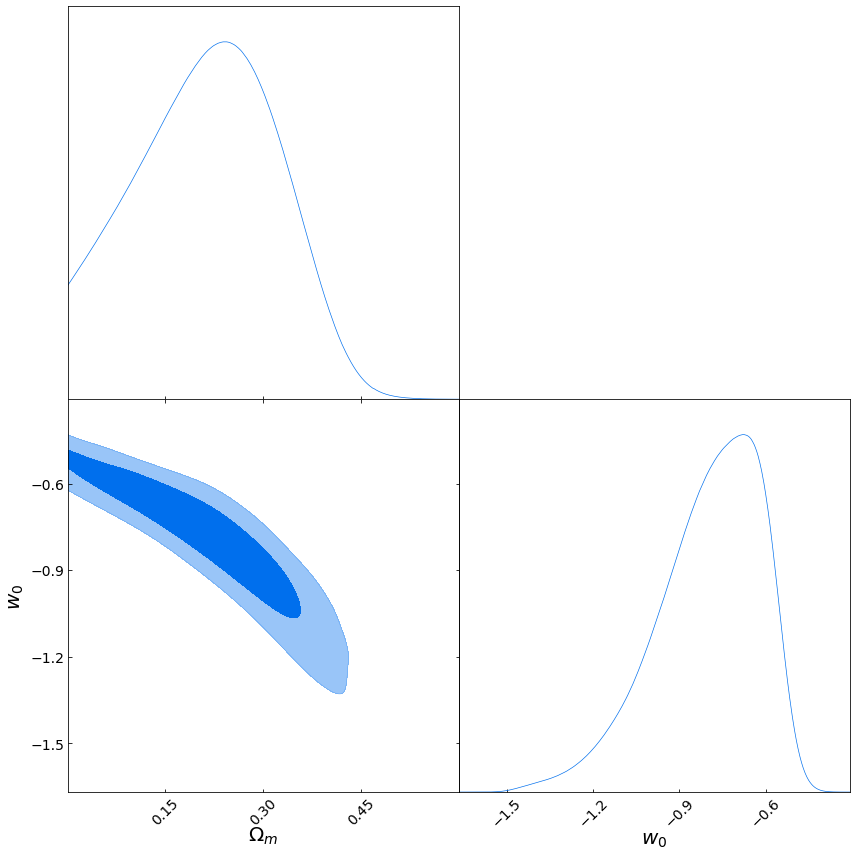

Population 79/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 7200 samples, validate on 800 samples
Epoch 1/100
7200/7200 [==============================] - 13s 2ms/step - loss: 1.3616 - val_loss: 1.3894
Epoch 2/100
7200/7200 [==============================] - 13s 2ms/step - loss: 1.3568 - val_loss: 1.4046
Epoch 3/100
7200/7200 [==============================] - 13s 2ms/step - loss: 1.3643 - val_loss: 1.3805
Epoch 4/100
7200/7200 [==============================] - 13s 2ms/step - loss: 1.3571 - val_loss: 1.4049
Epoch 5/100
7200/7200 [==============================] - 13s 2ms/step - loss: 1.3617 - val_loss: 1.3808
Epoch 6/100
7200/7200 [==============================] - 15s 2ms/step - loss: 1.3646 - val_loss: 1.3941
Epoch 7/100
7200/7200 [==============================] - 13s 2ms/step - loss: 1.3585 - val_loss: 1.3904
Epoch 8/100
7200/7200 [==============================] - 13s 2ms/step - loss: 1.3605 - val_loss: 1.3920
Train on 7200 samples, validate on 800 samp

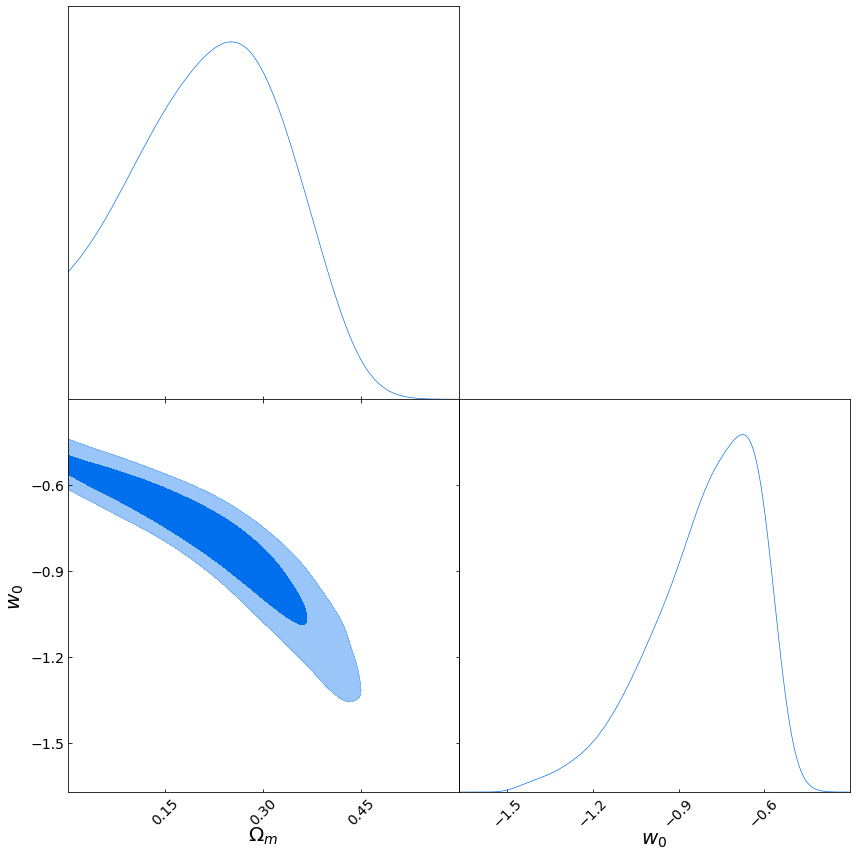

Population 80/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 7290 samples, validate on 810 samples
Epoch 1/100
7290/7290 [==============================] - 13s 2ms/step - loss: 1.3598 - val_loss: 1.3700
Epoch 2/100
7290/7290 [==============================] - 13s 2ms/step - loss: 1.3594 - val_loss: 1.3705
Epoch 3/100
7290/7290 [==============================] - 13s 2ms/step - loss: 1.3596 - val_loss: 1.3722
Epoch 4/100
7290/7290 [==============================] - 13s 2ms/step - loss: 1.3600 - val_loss: 1.3734
Epoch 5/100
7290/7290 [==============================] - 13s 2ms/step - loss: 1.3600 - val_loss: 1.3810
Epoch 6/100
7290/7290 [==============================] - 13s 2ms/step - loss: 1.3599 - val_loss: 1.3722
Train on 7290 samples, validate on 810 samples
Epoch 1/100
7290/7290 [==============================] - 16s 2ms/step - loss: 1.3546 - val_loss: 1.3729
Epoch 2/100
7290/7290 [==============================] - 16s 2ms/step - loss: 1.3547 - val_loss: 1.3

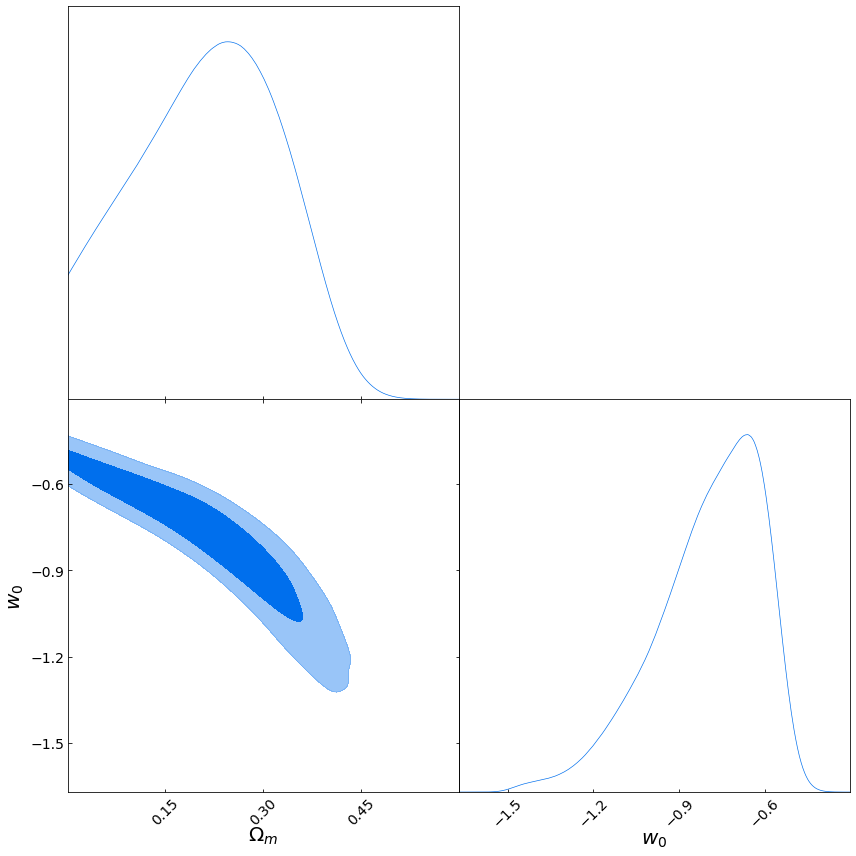

Population 81/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 7380 samples, validate on 820 samples
Epoch 1/100
7380/7380 [==============================] - 13s 2ms/step - loss: 1.3603 - val_loss: 1.3466
Epoch 2/100
7380/7380 [==============================] - 12s 2ms/step - loss: 1.3611 - val_loss: 1.3457
Epoch 3/100
7380/7380 [==============================] - 10s 1ms/step - loss: 1.3590 - val_loss: 1.3617
Epoch 4/100
7380/7380 [==============================] - 10s 1ms/step - loss: 1.3603 - val_loss: 1.3529
Epoch 5/100
7380/7380 [==============================] - 10s 1ms/step - loss: 1.3642 - val_loss: 1.3578
Epoch 6/100
7380/7380 [==============================] - 10s 1ms/step - loss: 1.3618 - val_loss: 1.3535
Epoch 7/100
7380/7380 [==============================] - 10s 1ms/step - loss: 1.3623 - val_loss: 1.3539
Train on 7380 samples, validate on 820 samples
Epoch 1/100
7380/7380 [==============================] - 15s 2ms/step - loss: 1.3603 - val_loss: 1.3

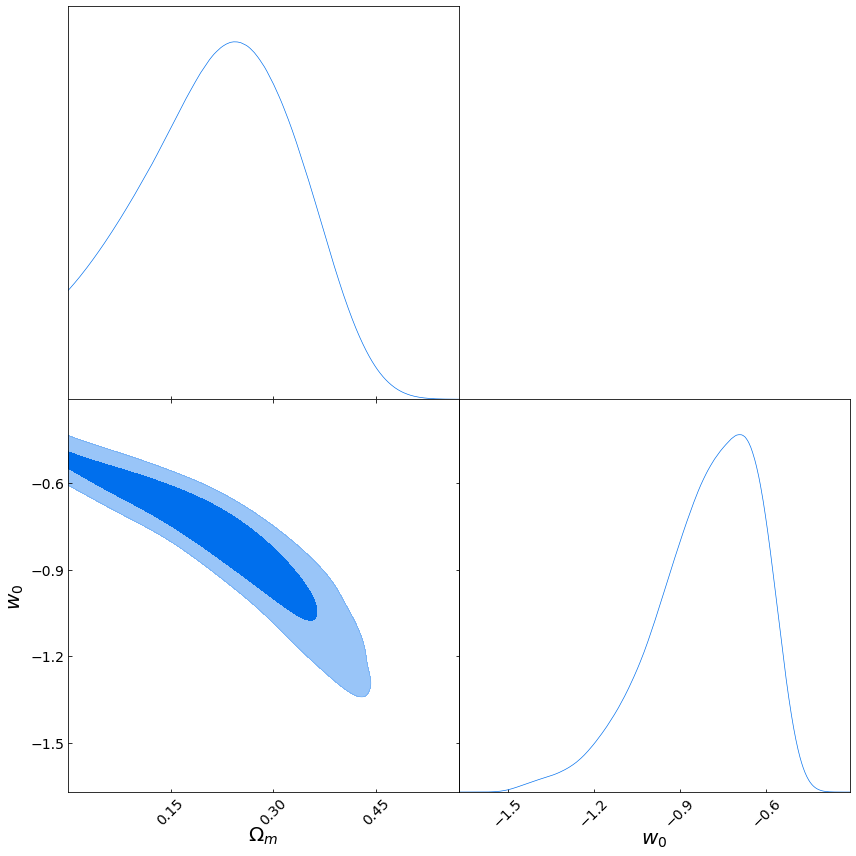

Population 82/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 7470 samples, validate on 830 samples
Epoch 1/100
7470/7470 [==============================] - 10s 1ms/step - loss: 1.3619 - val_loss: 1.3645
Epoch 2/100
7470/7470 [==============================] - 10s 1ms/step - loss: 1.3618 - val_loss: 1.3612
Epoch 3/100
7470/7470 [==============================] - 10s 1ms/step - loss: 1.3580 - val_loss: 1.3559
Epoch 4/100
7470/7470 [==============================] - 10s 1ms/step - loss: 1.3595 - val_loss: 1.3783
Epoch 5/100
7470/7470 [==============================] - 10s 1ms/step - loss: 1.3617 - val_loss: 1.3817
Epoch 6/100
7470/7470 [==============================] - 10s 1ms/step - loss: 1.3624 - val_loss: 1.3737
Epoch 7/100
7470/7470 [==============================] - 10s 1ms/step - loss: 1.3600 - val_loss: 1.3566
Epoch 8/100
7470/7470 [==============================] - 10s 1ms/step - loss: 1.3618 - val_loss: 1.3821
Train on 7470 samples, validate on 830 samp

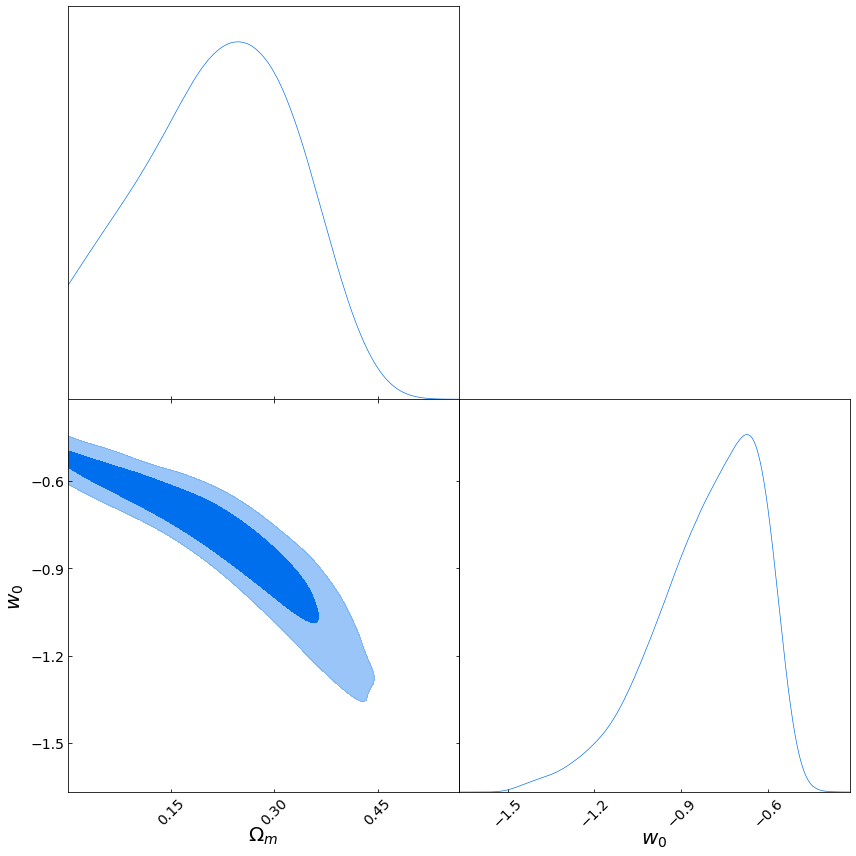

Population 83/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 7560 samples, validate on 840 samples
Epoch 1/100
7560/7560 [==============================] - 10s 1ms/step - loss: 1.3577 - val_loss: 1.3384
Epoch 2/100
7560/7560 [==============================] - 10s 1ms/step - loss: 1.3593 - val_loss: 1.3369
Epoch 3/100
7560/7560 [==============================] - 10s 1ms/step - loss: 1.3585 - val_loss: 1.3369
Epoch 4/100
7560/7560 [==============================] - 10s 1ms/step - loss: 1.3584 - val_loss: 1.3340
Epoch 5/100
7560/7560 [==============================] - 10s 1ms/step - loss: 1.3601 - val_loss: 1.3384
Epoch 6/100
7560/7560 [==============================] - 10s 1ms/step - loss: 1.3582 - val_loss: 1.3369
Epoch 7/100
7560/7560 [==============================] - 10s 1ms/step - loss: 1.3604 - val_loss: 1.3389
Epoch 8/100
7560/7560 [==============================] - 10s 1ms/step - loss: 1.3621 - val_loss: 1.3398
Epoch 9/100
7560/7560 [====================

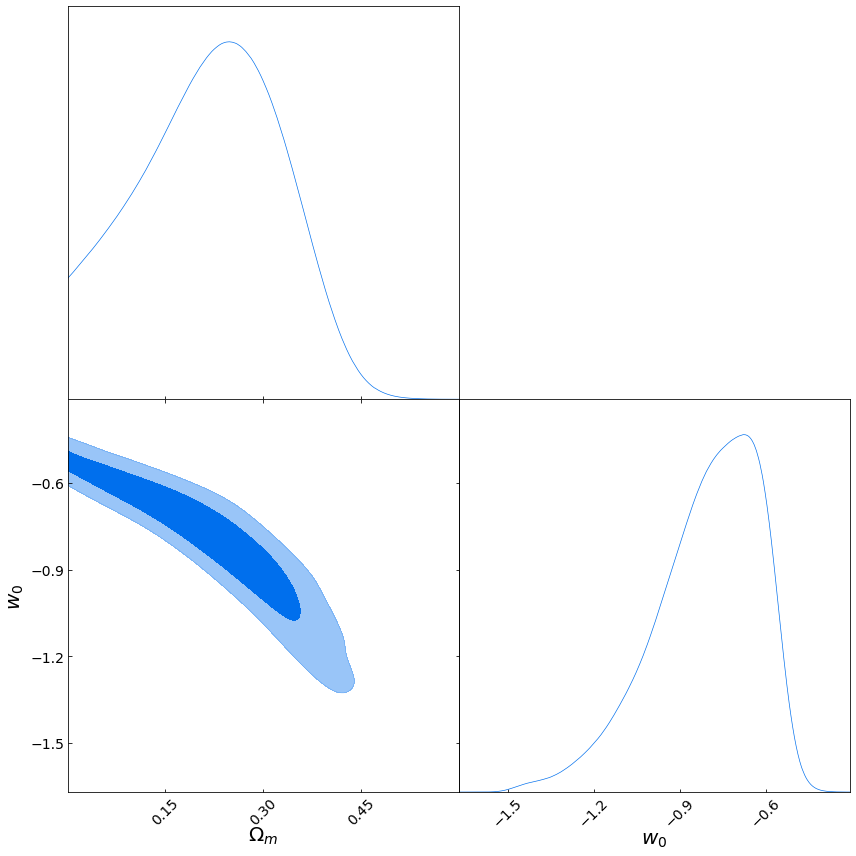

Population 84/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 7650 samples, validate on 850 samples
Epoch 1/100
7650/7650 [==============================] - 10s 1ms/step - loss: 1.3627 - val_loss: 1.3130
Epoch 2/100
7650/7650 [==============================] - 10s 1ms/step - loss: 1.3670 - val_loss: 1.2942
Epoch 3/100
7650/7650 [==============================] - 10s 1ms/step - loss: 1.3615 - val_loss: 1.2886
Epoch 4/100
7650/7650 [==============================] - 10s 1ms/step - loss: 1.3627 - val_loss: 1.2863
Epoch 5/100
7650/7650 [==============================] - 10s 1ms/step - loss: 1.3647 - val_loss: 1.2903
Epoch 6/100
7650/7650 [==============================] - 10s 1ms/step - loss: 1.3684 - val_loss: 1.2872
Epoch 7/100
7650/7650 [==============================] - 10s 1ms/step - loss: 1.3645 - val_loss: 1.2923
Epoch 8/100
7650/7650 [==============================] - 10s 1ms/step - loss: 1.3646 - val_loss: 1.2929
Epoch 9/100
7650/7650 [====================

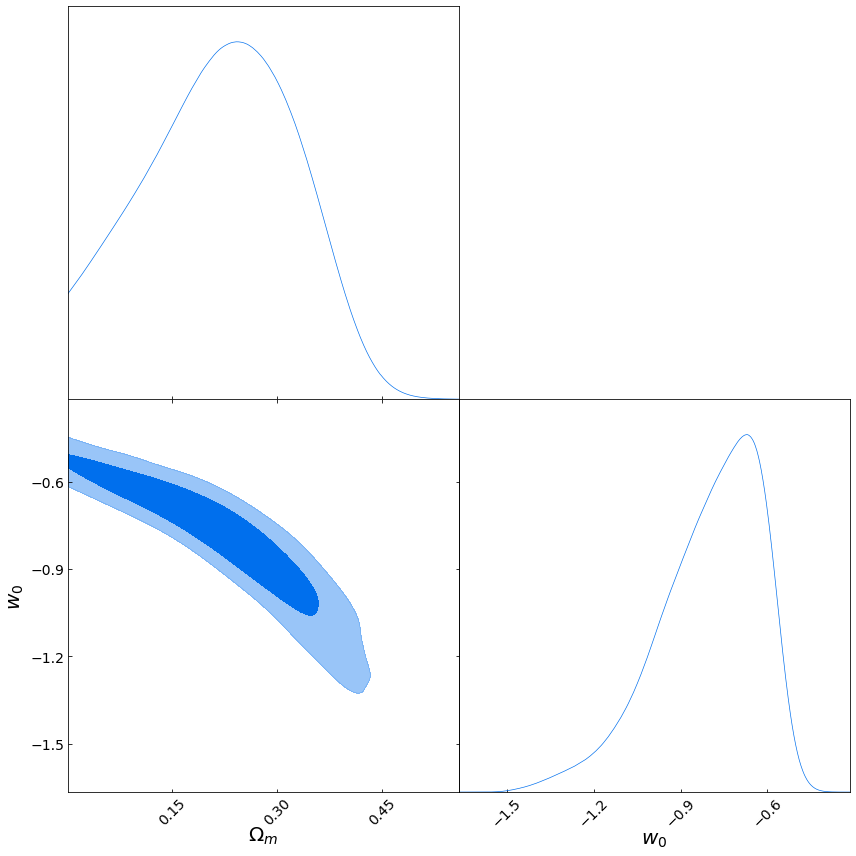

Population 85/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 7740 samples, validate on 860 samples
Epoch 1/100
7740/7740 [==============================] - 10s 1ms/step - loss: 1.3623 - val_loss: 1.2896
Epoch 2/100
7740/7740 [==============================] - 10s 1ms/step - loss: 1.3662 - val_loss: 1.2884
Epoch 3/100
7740/7740 [==============================] - 10s 1ms/step - loss: 1.3649 - val_loss: 1.2841
Epoch 4/100
7740/7740 [==============================] - 10s 1ms/step - loss: 1.3624 - val_loss: 1.2940
Epoch 5/100
7740/7740 [==============================] - 11s 1ms/step - loss: 1.3638 - val_loss: 1.2992
Epoch 6/100
7740/7740 [==============================] - 10s 1ms/step - loss: 1.3617 - val_loss: 1.3005
Epoch 7/100
7740/7740 [==============================] - 10s 1ms/step - loss: 1.3639 - val_loss: 1.2893
Epoch 8/100
7740/7740 [==============================] - 10s 1ms/step - loss: 1.3625 - val_loss: 1.2873
Train on 7740 samples, validate on 860 samp

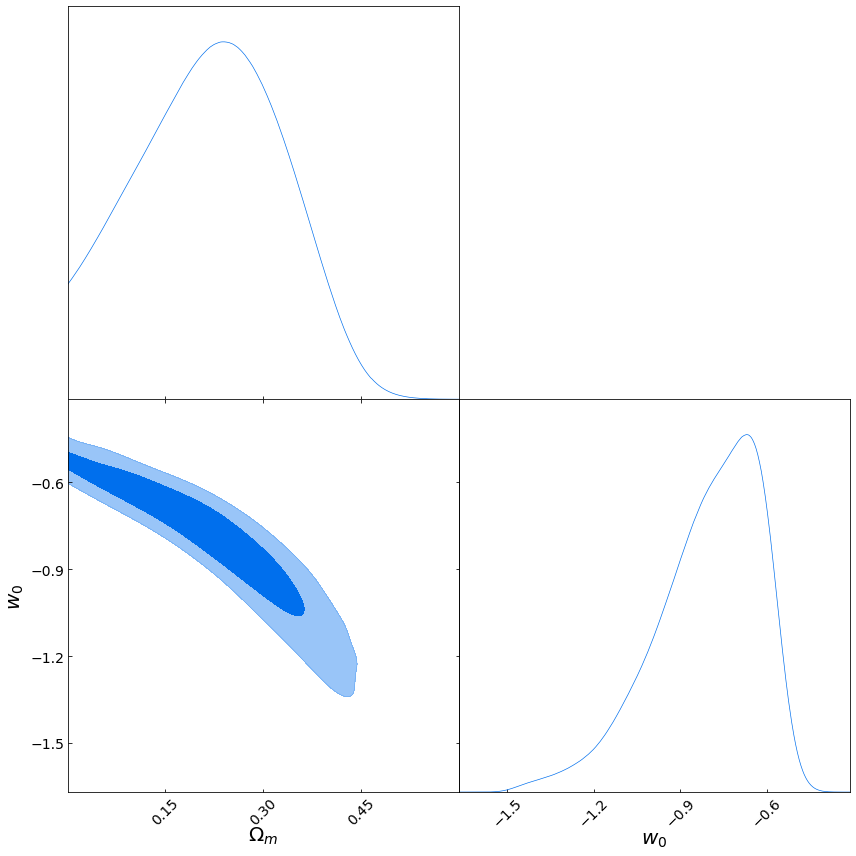

Population 86/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 7830 samples, validate on 870 samples
Epoch 1/100
7830/7830 [==============================] - 10s 1ms/step - loss: 1.3610 - val_loss: 1.2923
Epoch 2/100
7830/7830 [==============================] - 14s 2ms/step - loss: 1.3654 - val_loss: 1.3026
Epoch 3/100
7830/7830 [==============================] - 10s 1ms/step - loss: 1.3617 - val_loss: 1.2925
Epoch 4/100
7830/7830 [==============================] - 10s 1ms/step - loss: 1.3622 - val_loss: 1.2914
Epoch 5/100
7830/7830 [==============================] - 10s 1ms/step - loss: 1.3599 - val_loss: 1.2883
Epoch 6/100
7830/7830 [==============================] - 10s 1ms/step - loss: 1.3617 - val_loss: 1.3047
Epoch 7/100
7830/7830 [==============================] - 10s 1ms/step - loss: 1.3623 - val_loss: 1.2930
Epoch 8/100
7830/7830 [==============================] - 10s 1ms/step - loss: 1.3618 - val_loss: 1.3039
Epoch 9/100
7830/7830 [====================

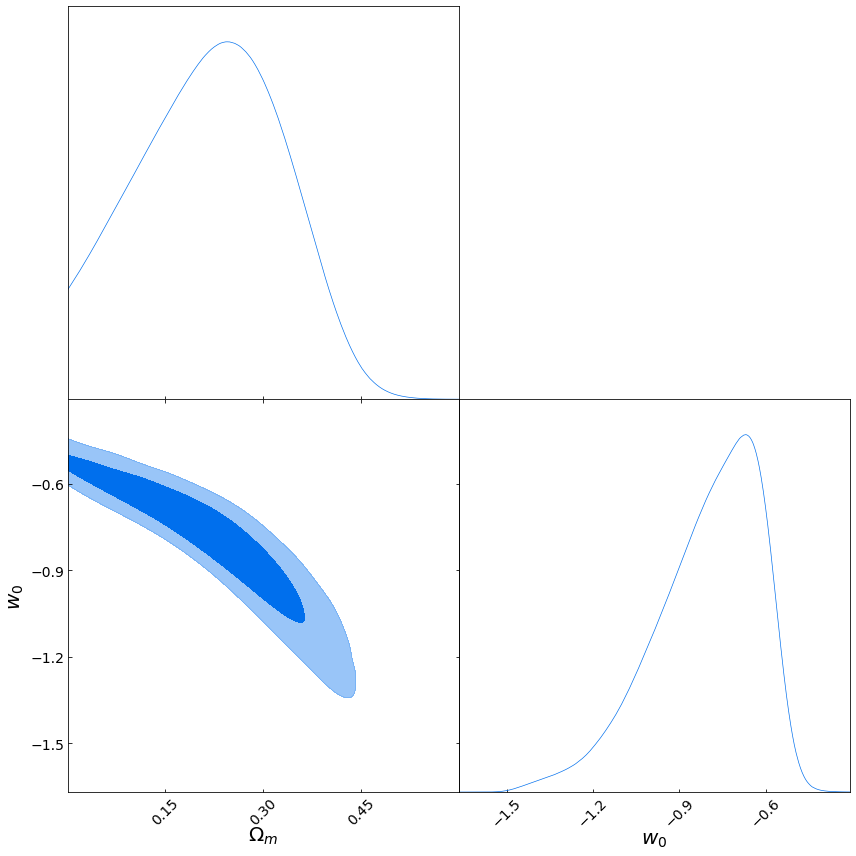

Population 87/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 7920 samples, validate on 880 samples
Epoch 1/100
7920/7920 [==============================] - 10s 1ms/step - loss: 1.3620 - val_loss: 1.2872
Epoch 2/100
7920/7920 [==============================] - 10s 1ms/step - loss: 1.3609 - val_loss: 1.2892
Epoch 3/100
7920/7920 [==============================] - 11s 1ms/step - loss: 1.3608 - val_loss: 1.2824
Epoch 4/100
7920/7920 [==============================] - 10s 1ms/step - loss: 1.3657 - val_loss: 1.2905
Epoch 5/100
7920/7920 [==============================] - 10s 1ms/step - loss: 1.3608 - val_loss: 1.2864
Epoch 6/100
7920/7920 [==============================] - 11s 1ms/step - loss: 1.3653 - val_loss: 1.2874
Epoch 7/100
7920/7920 [==============================] - 10s 1ms/step - loss: 1.3627 - val_loss: 1.2905
Epoch 8/100
7920/7920 [==============================] - 10s 1ms/step - loss: 1.3604 - val_loss: 1.2819
Epoch 9/100
7920/7920 [====================

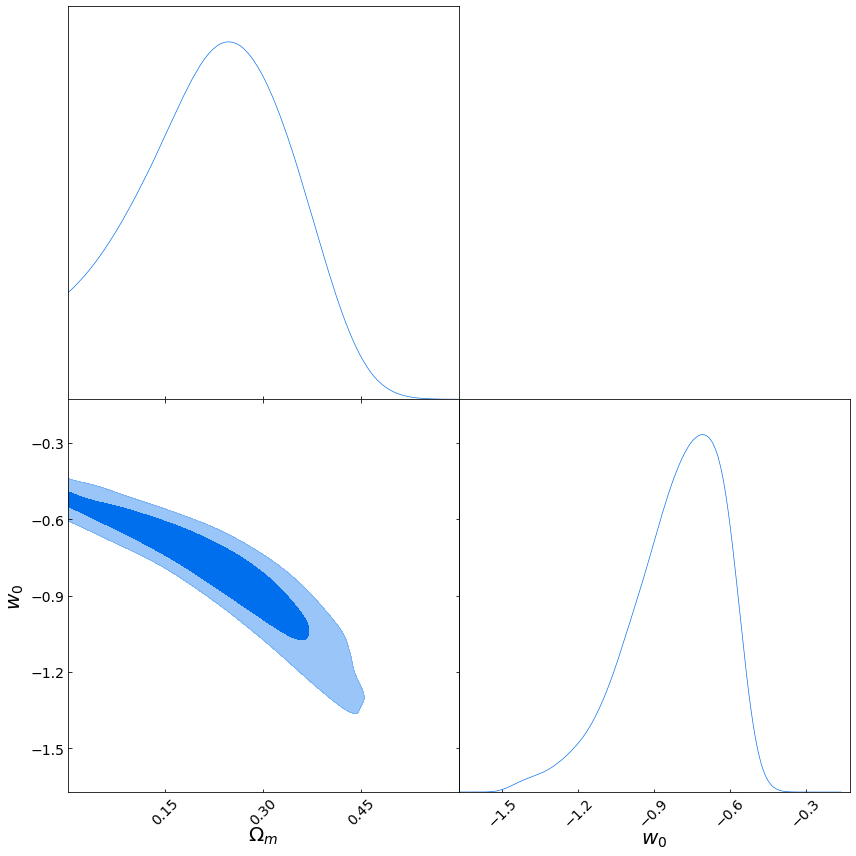

Population 88/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 8010 samples, validate on 890 samples
Epoch 1/100
8010/8010 [==============================] - 10s 1ms/step - loss: 1.3632 - val_loss: 1.2910
Epoch 2/100
8010/8010 [==============================] - 11s 1ms/step - loss: 1.3634 - val_loss: 1.2938
Epoch 3/100
8010/8010 [==============================] - 10s 1ms/step - loss: 1.3636 - val_loss: 1.2815
Epoch 4/100
8010/8010 [==============================] - 10s 1ms/step - loss: 1.3599 - val_loss: 1.2888
Epoch 5/100
8010/8010 [==============================] - 11s 1ms/step - loss: 1.3626 - val_loss: 1.2801
Epoch 6/100
8010/8010 [==============================] - 10s 1ms/step - loss: 1.3660 - val_loss: 1.2799
Epoch 7/100
8010/8010 [==============================] - 10s 1ms/step - loss: 1.3628 - val_loss: 1.2810
Epoch 8/100
8010/8010 [==============================] - 10s 1ms/step - loss: 1.3631 - val_loss: 1.2909
Epoch 9/100
8010/8010 [====================

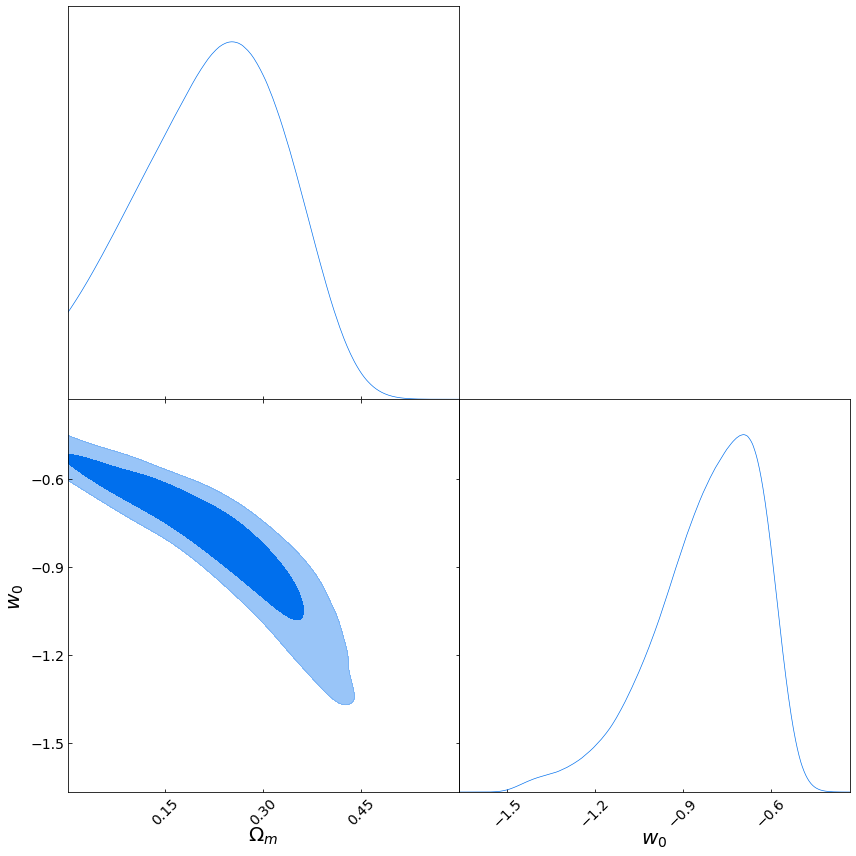

Population 89/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 8100 samples, validate on 900 samples
Epoch 1/100
8100/8100 [==============================] - 10s 1ms/step - loss: 1.3591 - val_loss: 1.2883
Epoch 2/100
8100/8100 [==============================] - 10s 1ms/step - loss: 1.3630 - val_loss: 1.2740
Epoch 3/100
8100/8100 [==============================] - 10s 1ms/step - loss: 1.3594 - val_loss: 1.2826
Epoch 4/100
8100/8100 [==============================] - 11s 1ms/step - loss: 1.3589 - val_loss: 1.2757
Epoch 5/100
8100/8100 [==============================] - 11s 1ms/step - loss: 1.3592 - val_loss: 1.2793
Epoch 6/100
8100/8100 [==============================] - 10s 1ms/step - loss: 1.3641 - val_loss: 1.2811
Epoch 7/100
8100/8100 [==============================] - 10s 1ms/step - loss: 1.3601 - val_loss: 1.2721
Epoch 8/100
8100/8100 [==============================] - 10s 1ms/step - loss: 1.3612 - val_loss: 1.2766
Epoch 9/100
8100/8100 [====================

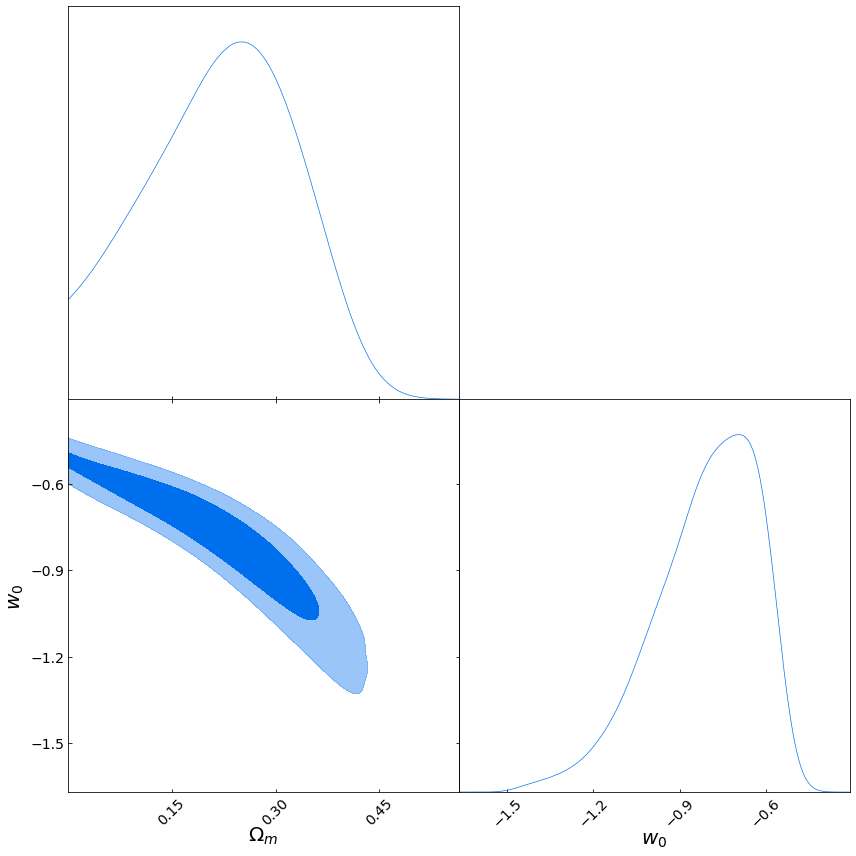

Population 90/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 8190 samples, validate on 910 samples
Epoch 1/100
8190/8190 [==============================] - 11s 1ms/step - loss: 1.3594 - val_loss: 1.2823
Epoch 2/100
8190/8190 [==============================] - 11s 1ms/step - loss: 1.3565 - val_loss: 1.2859
Epoch 3/100
8190/8190 [==============================] - 11s 1ms/step - loss: 1.3570 - val_loss: 1.2860
Epoch 4/100
8190/8190 [==============================] - 11s 1ms/step - loss: 1.3578 - val_loss: 1.2789
Epoch 5/100
8190/8190 [==============================] - 10s 1ms/step - loss: 1.3603 - val_loss: 1.2862
Epoch 6/100
8190/8190 [==============================] - 11s 1ms/step - loss: 1.3586 - val_loss: 1.2853
Epoch 7/100
8190/8190 [==============================] - 11s 1ms/step - loss: 1.3612 - val_loss: 1.2835
Epoch 8/100
8190/8190 [==============================] - 11s 1ms/step - loss: 1.3574 - val_loss: 1.2762
Epoch 9/100
8190/8190 [====================

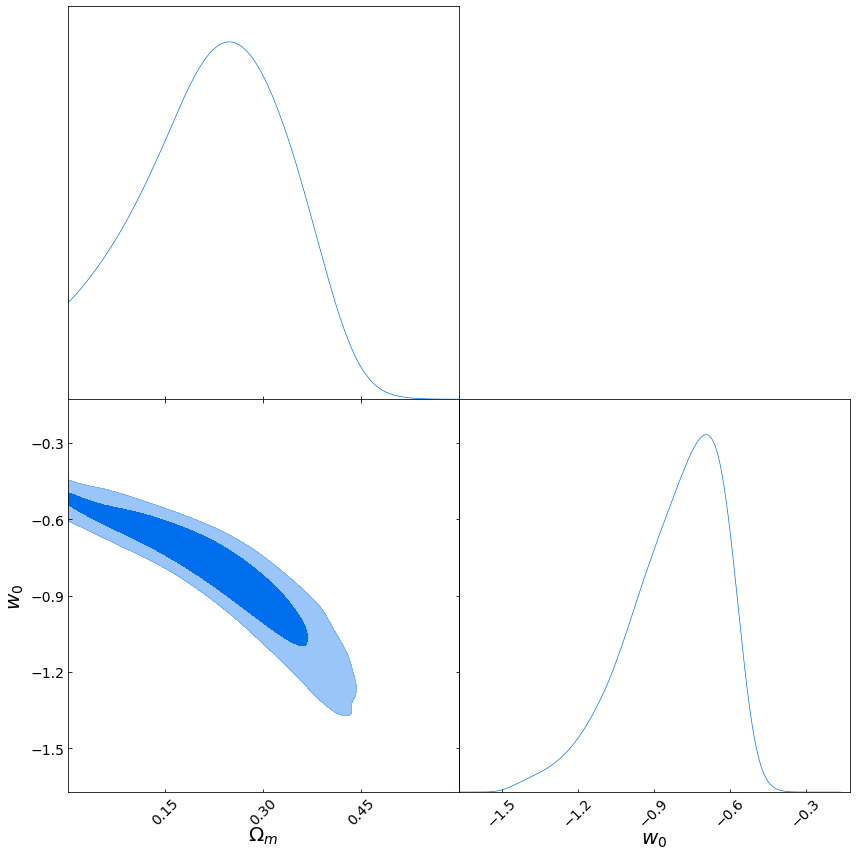

Population 91/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 8280 samples, validate on 920 samples
Epoch 1/100
8280/8280 [==============================] - 11s 1ms/step - loss: 1.3583 - val_loss: 1.2621
Epoch 2/100
8280/8280 [==============================] - 11s 1ms/step - loss: 1.3581 - val_loss: 1.2664
Epoch 3/100
8280/8280 [==============================] - 11s 1ms/step - loss: 1.3560 - val_loss: 1.2719
Epoch 4/100
8280/8280 [==============================] - 11s 1ms/step - loss: 1.3597 - val_loss: 1.2624
Epoch 5/100
8280/8280 [==============================] - 11s 1ms/step - loss: 1.3596 - val_loss: 1.2729
Epoch 6/100
8280/8280 [==============================] - 11s 1ms/step - loss: 1.3644 - val_loss: 1.2665
Train on 8280 samples, validate on 920 samples
Epoch 1/100
8280/8280 [==============================] - 14s 2ms/step - loss: 1.3540 - val_loss: 1.2679
Epoch 2/100
8280/8280 [==============================] - 14s 2ms/step - loss: 1.3556 - val_loss: 1.2

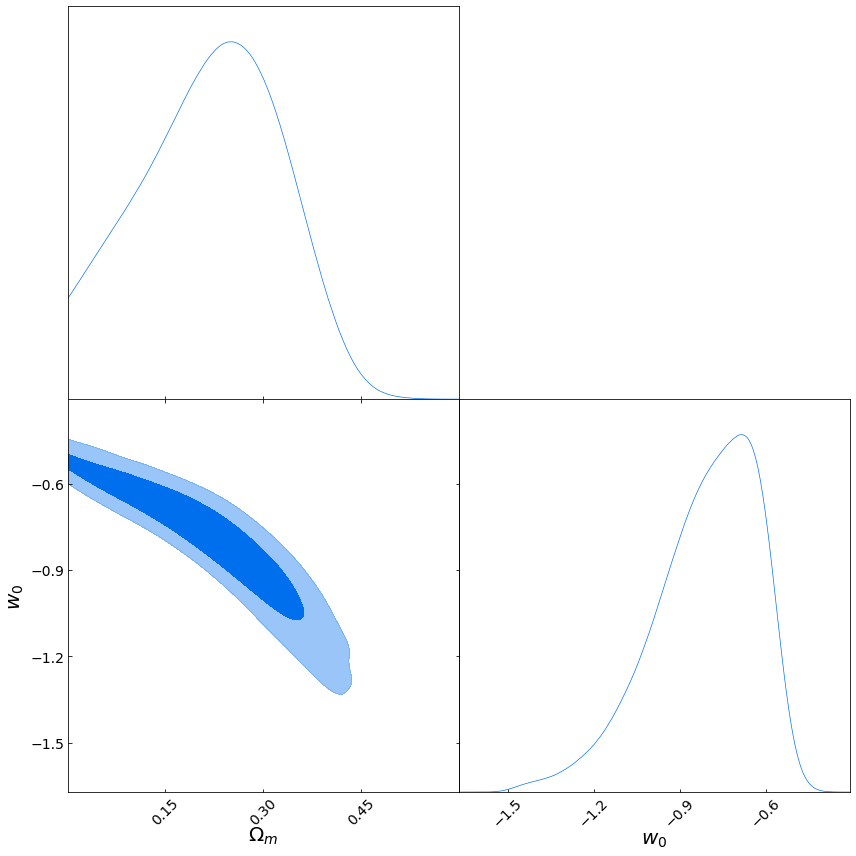

Population 92/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 8370 samples, validate on 930 samples
Epoch 1/100
8370/8370 [==============================] - 11s 1ms/step - loss: 1.3567 - val_loss: 1.2839
Epoch 2/100
8370/8370 [==============================] - 11s 1ms/step - loss: 1.3577 - val_loss: 1.2799
Epoch 3/100
8370/8370 [==============================] - 11s 1ms/step - loss: 1.3594 - val_loss: 1.2817
Epoch 4/100
8370/8370 [==============================] - 11s 1ms/step - loss: 1.3542 - val_loss: 1.2927
Epoch 5/100
8370/8370 [==============================] - 12s 1ms/step - loss: 1.3581 - val_loss: 1.2960
Epoch 6/100
8370/8370 [==============================] - 11s 1ms/step - loss: 1.3572 - val_loss: 1.2862
Epoch 7/100
8370/8370 [==============================] - 11s 1ms/step - loss: 1.3548 - val_loss: 1.2842
Train on 8370 samples, validate on 930 samples
Epoch 1/100
8370/8370 [==============================] - 15s 2ms/step - loss: 1.3589 - val_loss: 1.2

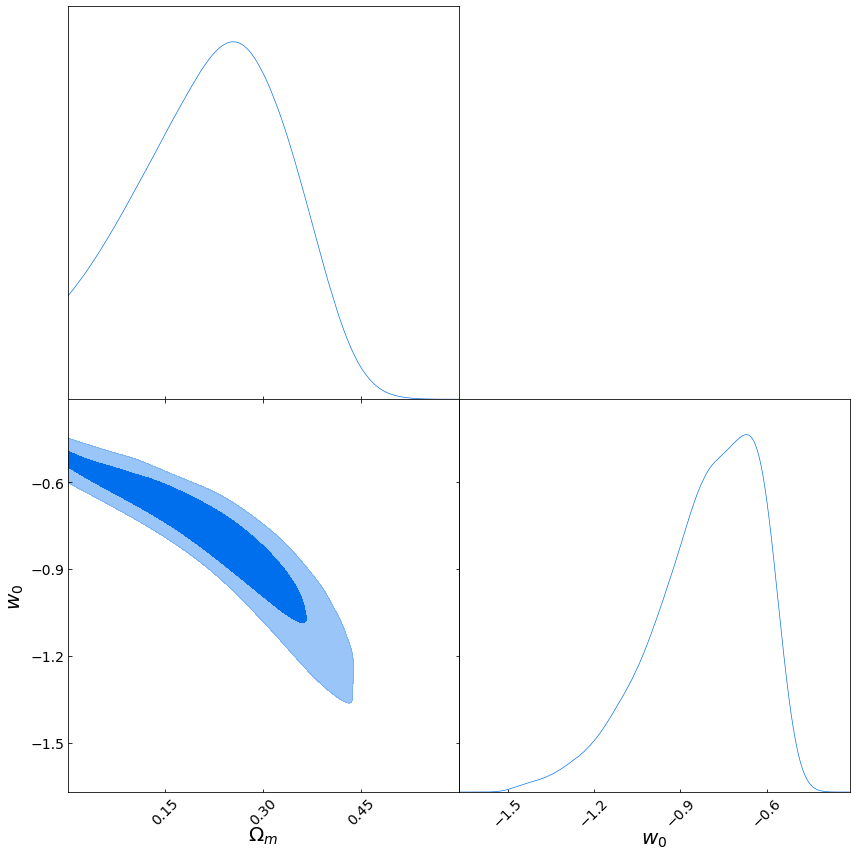

Population 93/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 8460 samples, validate on 940 samples
Epoch 1/100
8460/8460 [==============================] - 11s 1ms/step - loss: 1.3572 - val_loss: 1.3211
Epoch 2/100
8460/8460 [==============================] - 11s 1ms/step - loss: 1.3576 - val_loss: 1.3166
Epoch 3/100
8460/8460 [==============================] - 11s 1ms/step - loss: 1.3546 - val_loss: 1.3148
Epoch 4/100
8460/8460 [==============================] - 11s 1ms/step - loss: 1.3530 - val_loss: 1.3162
Epoch 5/100
8460/8460 [==============================] - 11s 1ms/step - loss: 1.3540 - val_loss: 1.3176
Epoch 6/100
8460/8460 [==============================] - 11s 1ms/step - loss: 1.3572 - val_loss: 1.3216
Epoch 7/100
8460/8460 [==============================] - 11s 1ms/step - loss: 1.3538 - val_loss: 1.3222
Epoch 8/100
8460/8460 [==============================] - 11s 1ms/step - loss: 1.3557 - val_loss: 1.3141
Epoch 9/100
8460/8460 [====================

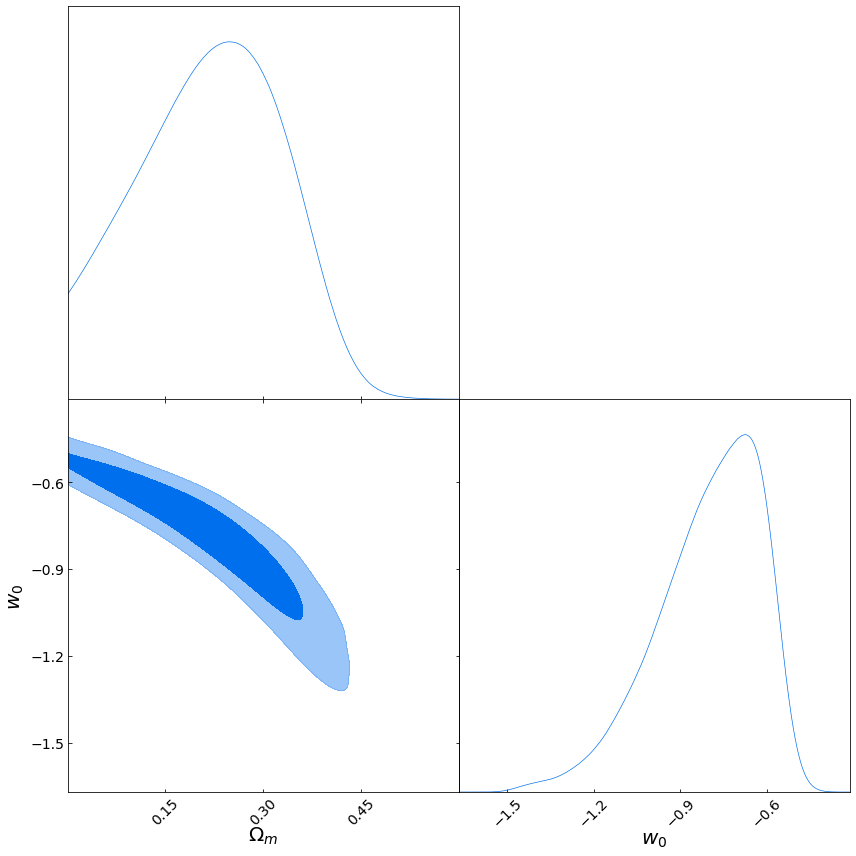

Population 94/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 8550 samples, validate on 950 samples
Epoch 1/100
8550/8550 [==============================] - 11s 1ms/step - loss: 1.3539 - val_loss: 1.3035
Epoch 2/100
8550/8550 [==============================] - 11s 1ms/step - loss: 1.3551 - val_loss: 1.3082
Epoch 3/100
8550/8550 [==============================] - 11s 1ms/step - loss: 1.3538 - val_loss: 1.3079
Epoch 4/100
8550/8550 [==============================] - 11s 1ms/step - loss: 1.3552 - val_loss: 1.3074
Epoch 5/100
8550/8550 [==============================] - 11s 1ms/step - loss: 1.3549 - val_loss: 1.3170
Epoch 6/100
8550/8550 [==============================] - 11s 1ms/step - loss: 1.3554 - val_loss: 1.3073
Train on 8550 samples, validate on 950 samples
Epoch 1/100
8550/8550 [==============================] - 14s 2ms/step - loss: 1.3507 - val_loss: 1.3079
Epoch 2/100
8550/8550 [==============================] - 14s 2ms/step - loss: 1.3514 - val_loss: 1.3

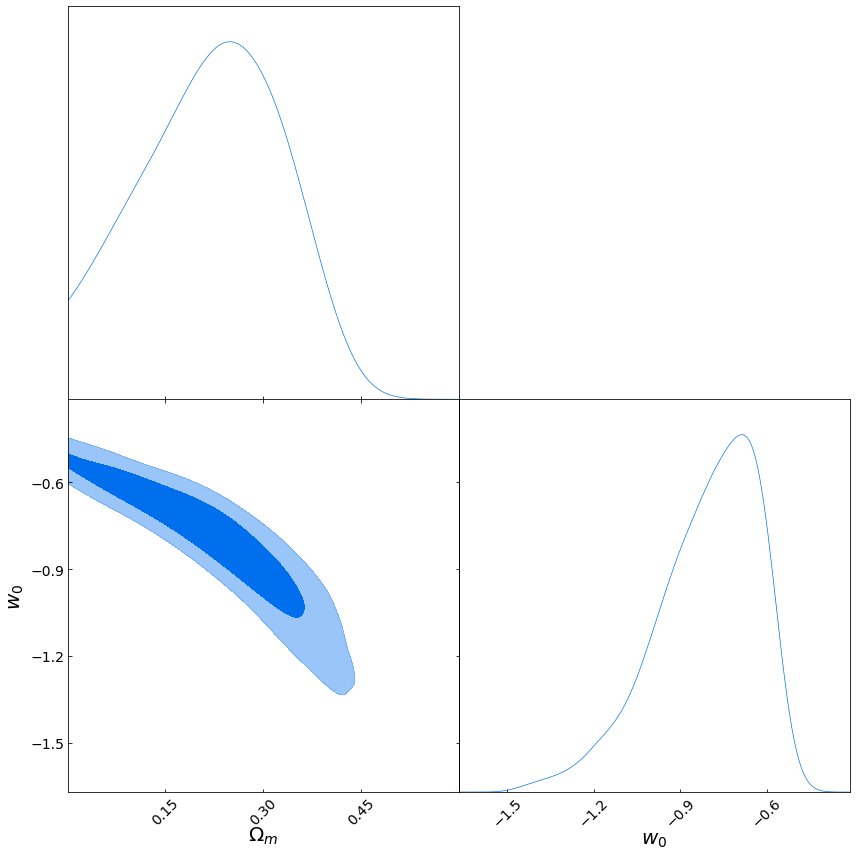

Population 95/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 8640 samples, validate on 960 samples
Epoch 1/100
8640/8640 [==============================] - 11s 1ms/step - loss: 1.3529 - val_loss: 1.2998
Epoch 2/100
8640/8640 [==============================] - 11s 1ms/step - loss: 1.3556 - val_loss: 1.3032
Epoch 3/100
8640/8640 [==============================] - 11s 1ms/step - loss: 1.3580 - val_loss: 1.3083
Epoch 4/100
8640/8640 [==============================] - 11s 1ms/step - loss: 1.3543 - val_loss: 1.3045
Epoch 5/100
8640/8640 [==============================] - 11s 1ms/step - loss: 1.3527 - val_loss: 1.3017
Epoch 6/100
8640/8640 [==============================] - 11s 1ms/step - loss: 1.3539 - val_loss: 1.3019
Train on 8640 samples, validate on 960 samples
Epoch 1/100
8640/8640 [==============================] - 14s 2ms/step - loss: 1.3517 - val_loss: 1.3012
Epoch 2/100
8640/8640 [==============================] - 15s 2ms/step - loss: 1.3509 - val_loss: 1.3

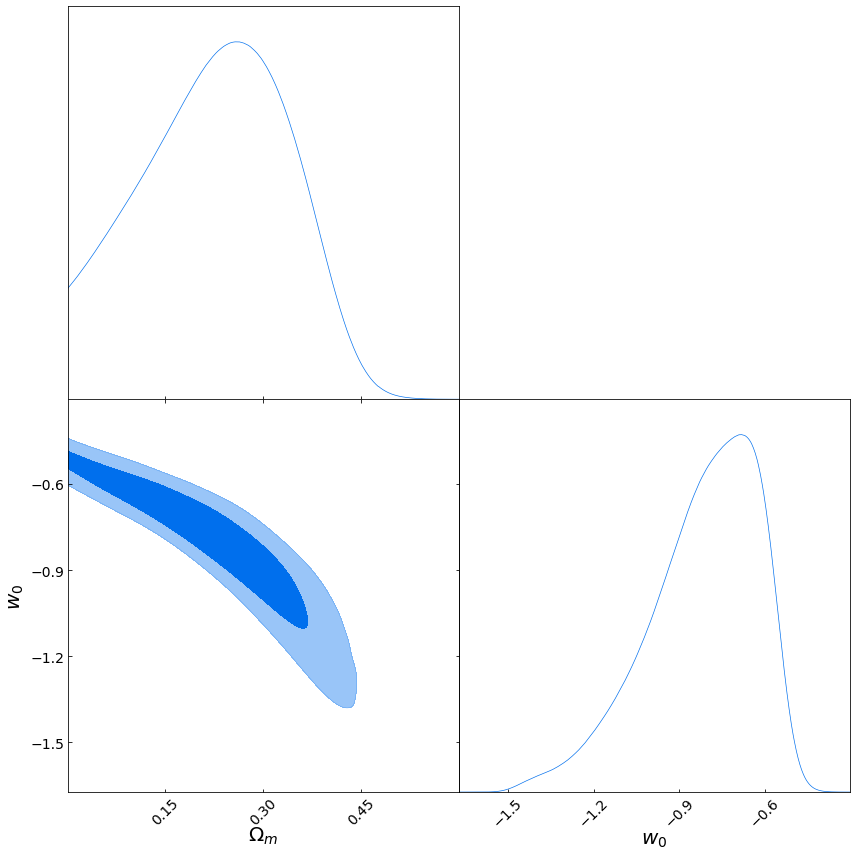

Population 96/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 8730 samples, validate on 970 samples
Epoch 1/100
8730/8730 [==============================] - 11s 1ms/step - loss: 1.3496 - val_loss: 1.3173
Epoch 2/100
8730/8730 [==============================] - 11s 1ms/step - loss: 1.3572 - val_loss: 1.3119
Epoch 3/100
8730/8730 [==============================] - 11s 1ms/step - loss: 1.3567 - val_loss: 1.3173
Epoch 4/100
8730/8730 [==============================] - 11s 1ms/step - loss: 1.3570 - val_loss: 1.3115
Epoch 5/100
8730/8730 [==============================] - 11s 1ms/step - loss: 1.3505 - val_loss: 1.3123
Epoch 6/100
8730/8730 [==============================] - 12s 1ms/step - loss: 1.3531 - val_loss: 1.3057
Epoch 7/100
8730/8730 [==============================] - 11s 1ms/step - loss: 1.3558 - val_loss: 1.3127
Epoch 8/100
8730/8730 [==============================] - 11s 1ms/step - loss: 1.3590 - val_loss: 1.3092
Epoch 9/100
8730/8730 [====================

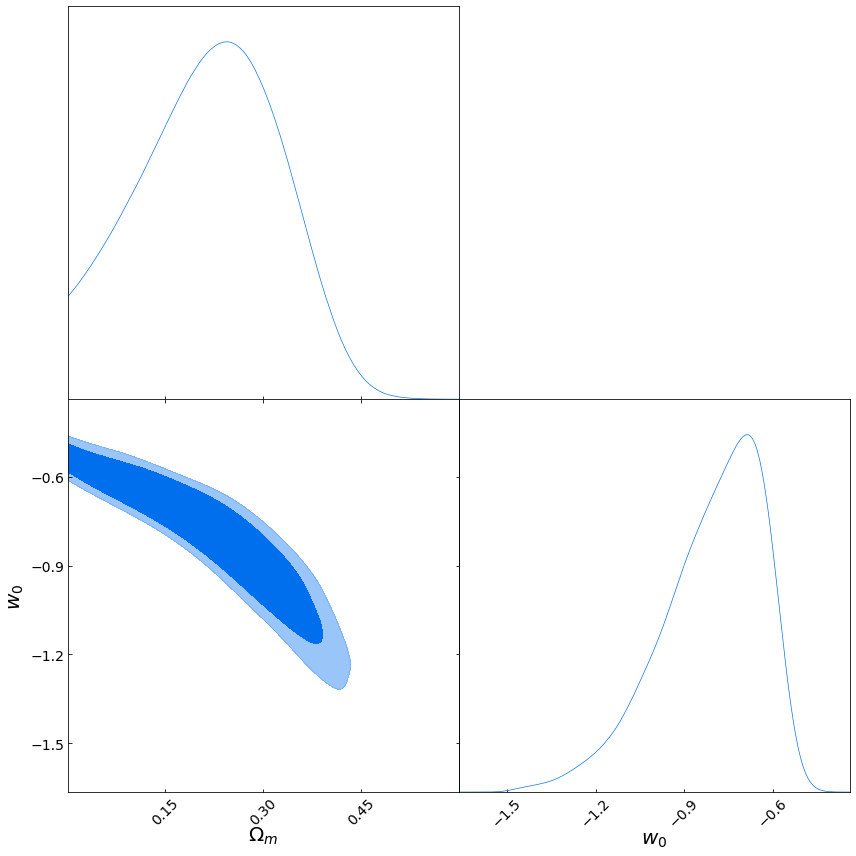

Population 97/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 8820 samples, validate on 980 samples
Epoch 1/100
8820/8820 [==============================] - 11s 1ms/step - loss: 1.3516 - val_loss: 1.3054
Epoch 2/100
8820/8820 [==============================] - 12s 1ms/step - loss: 1.3539 - val_loss: 1.3071
Epoch 3/100
8820/8820 [==============================] - 12s 1ms/step - loss: 1.3581 - val_loss: 1.3172
Epoch 4/100
8820/8820 [==============================] - 11s 1ms/step - loss: 1.3562 - val_loss: 1.3196
Epoch 5/100
8820/8820 [==============================] - 11s 1ms/step - loss: 1.3517 - val_loss: 1.3153
Epoch 6/100
8820/8820 [==============================] - 11s 1ms/step - loss: 1.3532 - val_loss: 1.3099
Train on 8820 samples, validate on 980 samples
Epoch 1/100
8820/8820 [==============================] - 15s 2ms/step - loss: 1.3475 - val_loss: 1.3088
Epoch 2/100
8820/8820 [==============================] - 15s 2ms/step - loss: 1.3465 - val_loss: 1.3

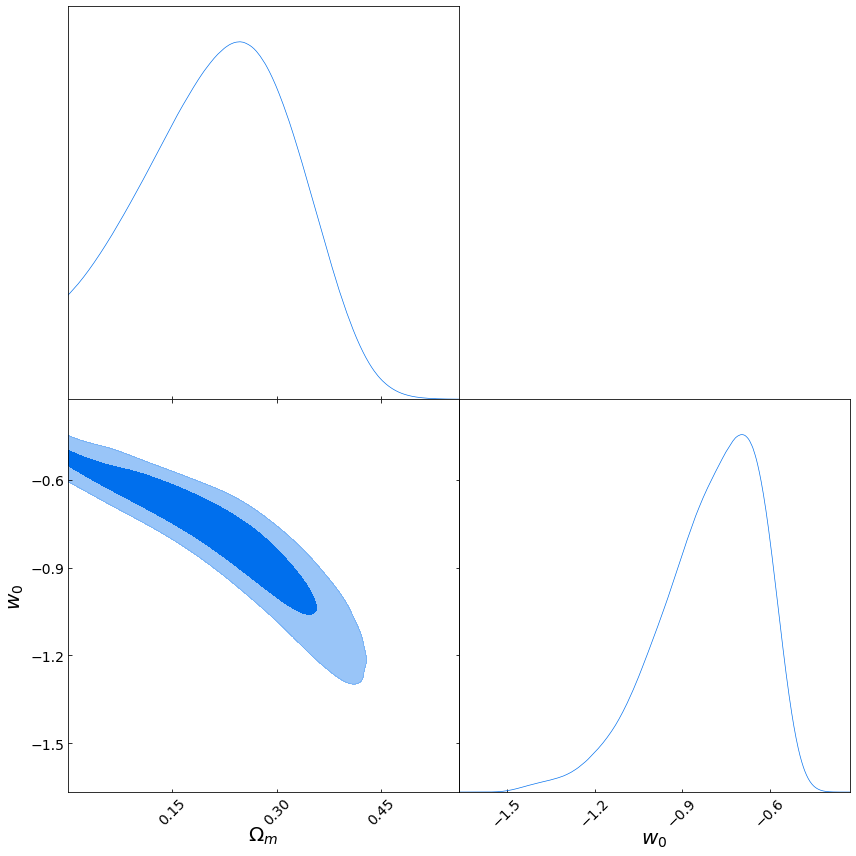

Population 98/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 8910 samples, validate on 990 samples
Epoch 1/100
8910/8910 [==============================] - 14s 2ms/step - loss: 1.3549 - val_loss: 1.3109
Epoch 2/100
8910/8910 [==============================] - 12s 1ms/step - loss: 1.3536 - val_loss: 1.3067
Epoch 3/100
8910/8910 [==============================] - 12s 1ms/step - loss: 1.3591 - val_loss: 1.3014
Epoch 4/100
8910/8910 [==============================] - 12s 1ms/step - loss: 1.3530 - val_loss: 1.3013
Epoch 5/100
8910/8910 [==============================] - 12s 1ms/step - loss: 1.3508 - val_loss: 1.3035
Epoch 6/100
8910/8910 [==============================] - 12s 1ms/step - loss: 1.3525 - val_loss: 1.3005
Epoch 7/100
8910/8910 [==============================] - 12s 1ms/step - loss: 1.3531 - val_loss: 1.3136
Epoch 8/100
8910/8910 [==============================] - 12s 1ms/step - loss: 1.3518 - val_loss: 1.3050
Epoch 9/100
8910/8910 [====================

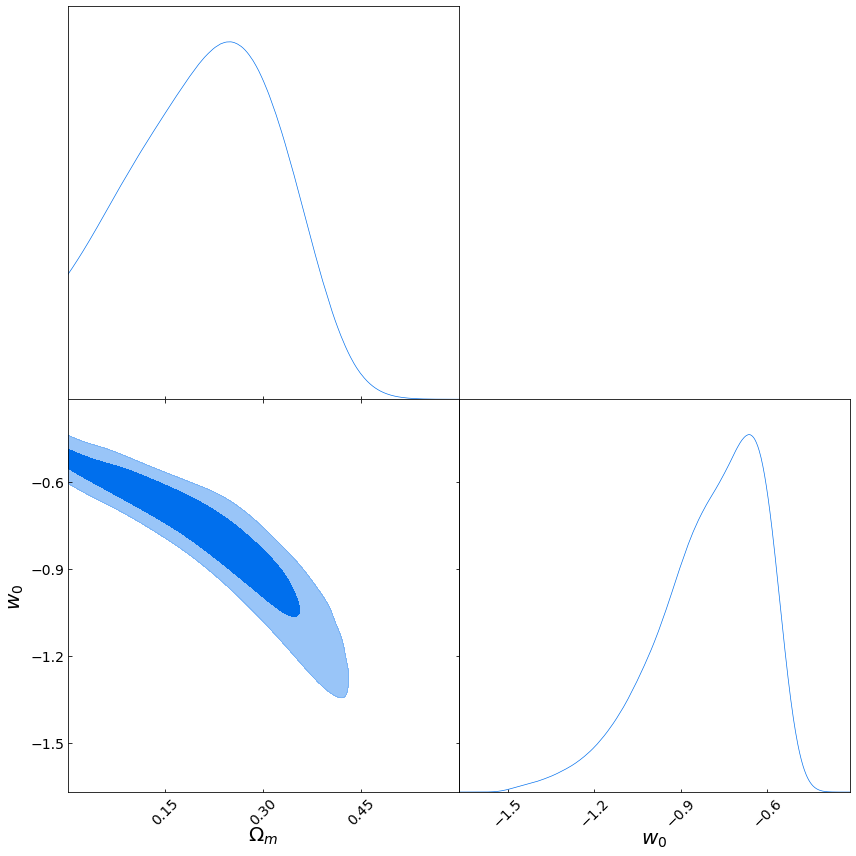

Population 99/99
Sampling proposal density...
Done.
Running 100 sims...
Done.
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 12s 1ms/step - loss: 1.3506 - val_loss: 1.3075
Epoch 2/100
9000/9000 [==============================] - 12s 1ms/step - loss: 1.3508 - val_loss: 1.3098
Epoch 3/100
9000/9000 [==============================] - 12s 1ms/step - loss: 1.3515 - val_loss: 1.3085
Epoch 4/100
9000/9000 [==============================] - 12s 1ms/step - loss: 1.3510 - val_loss: 1.3154
Epoch 5/100
9000/9000 [==============================] - 12s 1ms/step - loss: 1.3508 - val_loss: 1.3191
Epoch 6/100
9000/9000 [==============================] - 12s 1ms/step - loss: 1.3515 - val_loss: 1.3269
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 15s 2ms/step - loss: 1.3636 - val_loss: 1.3215
Epoch 2/100
9000/9000 [==============================] - 16s 2ms/step - loss: 1.3595 - val_loss: 1

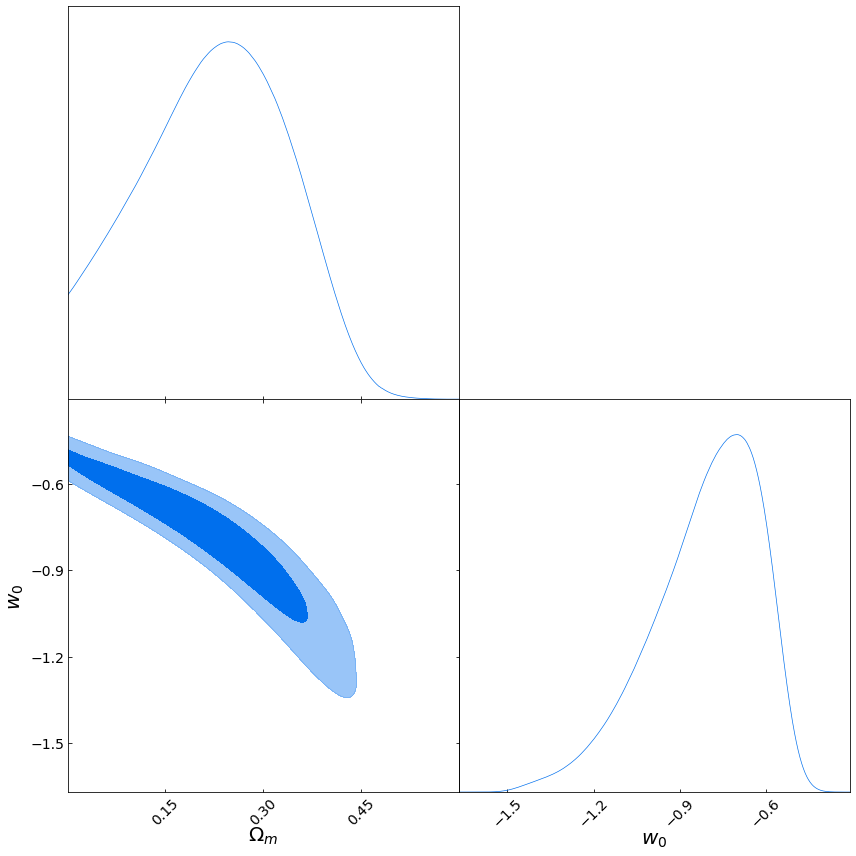

In [7]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 100
n_batch = 100
n_populations = 99

# Do the SNL training
mdn.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, proposal, simulator_args=simulator_args, compressor_args=compressor_args)

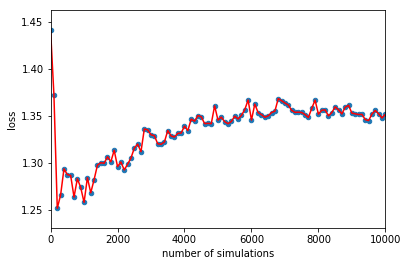

In [8]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()